In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch


In [3]:
!pip install pytorch-metric-learning

In [4]:
import pandas as pd
import os
import cv2
#import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

folder = '/content/drive/My Drive/PROJECTE DEEP LEARNING/IMAGES_OF_Vincent van Gogh'
all_pictures = os.listdir(folder)

file_path = "/content/drive/My Drive/PROJECTE DEEP LEARNING/IMAGES_OF_Vincent van Gogh.csv"
df = pd.read_csv(file_path)

# Reemplazar el prefijo "c." con nada en la columna 'date'
'''
df['date'] = df['date'].str.replace(r'c\.', '', regex=True)

df['date'] = df['date'].str.replace(r'\.0$', '', regex=True)

df['date'] = df['date'].str.extract(r'(\d+)', expand=False)

df['date'] = df['date'].astype(int)
'''
print(df.head())

NUM_CLASSES = len(df['date'].unique().tolist())

print("Number of classes:", NUM_CLASSES)


             artist  date new_filename
0  Vincent van Gogh  1887    75309.jpg
1  Vincent van Gogh  1886    21520.jpg
2  Vincent van Gogh  1890    61388.jpg
3  Vincent van Gogh  1890    87903.jpg
4  Vincent van Gogh  1889    26488.jpg
Number of classes: 13


In [5]:
import os
import shutil
import random
import pandas as pd


In [6]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [7]:
# GROUP THE FILES BY EACH date
import random
def group_files_per_date():
  data_per_date = {}

  # Iterate over each row of the DataFrame
  for index, row in df.iterrows():
      date = row['date']
      new_filename = row['new_filename']

      # Check if the date is already in the dictionary
      if date in data_per_date:
          # Add the new_filename to the existing list of the date
          data_per_date[date].append(new_filename)
      else:
          # Create a new list for the date and add the new_filename
          data_per_date[date] = [new_filename]

  return data_per_date

# SPLIT THE FILES INTO TRAIN AND TEST SETS (CREATE NEW DATASETS)
def split_test_train(data_per_date, train_percentage = 0.8):

  TRAIN_names = []
  TEST_names = []

  # Iterate over each date and their 'new_filename'
  for date, filenames in data_per_date.items():
      # Calculate the number of files for training and testing
      total_files = len(filenames)
      num_train = int(train_percentage * total_files)

      # Shuffle the filenames to avoid selection biases
      random.shuffle(filenames)

      # Divide the filenames into train and test
      train_filenames = filenames[:num_train]
      test_filenames = filenames[num_train:]

      # Store the divided filenames into train and test
      TRAIN_names.extend(train_filenames)
      TEST_names.extend(test_filenames)
  return TRAIN_names, TEST_names



# CREATE TEST and TRAIN folders
def create_train_test_folders(folder, TRAIN_names, TEST_names):
    # Output folder for TRAIN and TEST
    train_folder = os.path.join(folder, 'TRAIN')
    test_folder = os.path.join(folder, 'TEST')

    # Create TRAIN and TEST folders if they don't exist
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Move images from TRAIN to TRAIN folder
    for filename in TRAIN_names:
        src = os.path.join(folder, filename)
        dst = os.path.join(train_folder, filename)
        shutil.move(src, dst)

    # Move images from TEST to TEST folder
    for filename in TEST_names:
        src = os.path.join(folder, filename)
        dst = os.path.join(test_folder, filename)
        shutil.move(src, dst)

    # Create df_train with rows whose 'new_filename' is in TRAIN_names and keep only 'date' and 'new_filename' columns
    train_dataframe = df[df['new_filename'].isin(TRAIN_names)][['date', 'new_filename']]
    # File path for the CSV file
    file_path = os.path.join(folder, 'train_dataframe.csv')
    # Save the DataFrame as CSV
    train_dataframe.to_csv(file_path, index=False)

    # Create df_test with rows whose 'new_filename' is in TEST_names and keep only 'date' and 'new_filename' columns
    test_dataframe = df[df['new_filename'].isin(TEST_names)][['date', 'new_filename']]
    # File path for the CSV file
    file_path = os.path.join(folder, 'test_dataframe.csv')
    # Save the DataFrame as CSV
    test_dataframe.to_csv(file_path, index=False)

    return train_dataframe, test_dataframe

if not (os.path.exists(os.path.join(folder, 'TRAIN')) and os.path.exists(os.path.join(folder, 'TEST')) and os.path.exists(os.path.join(folder, 'train_dataframe.csv'))):
  # Group files per date
  data_per_date = group_files_per_date()
  # Print the number of files for each date
  print("- date and numer of images:")
  for key in data_per_date.keys():
    print(key, len(data_per_date[key]))

  # Split data
  TRAIN_names, TEST_names = split_test_train(data_per_date)

  # Use the function to create TRAIN and TEST folders
  train_dataframe, test_dataframe = create_train_test_folders(folder, TRAIN_names, TEST_names)
  print("\nImages successfully moved to TRAIN and TEST folders.")
else:
  print("TRAIN and TEST folders already exist. Reading train and test DataFrames from CSV files...")

  # Read train and test DataFrames from CSV files
  train_folder = os.path.join(folder, 'TRAIN')
  test_folder = os.path.join(folder, 'TEST')

  train_images = set(os.listdir(train_folder))
  test_images = set(os.listdir(test_folder))

  train_dataframe = df[df['new_filename'].isin(train_images)].copy()
  test_dataframe = df[df['new_filename'].isin(test_images)].copy()

  train_dataframe = train_dataframe[['new_filename', 'date']]
  test_dataframe = test_dataframe[['new_filename', 'date']]
"""
  train_dataframe['date'] = train_dataframe['date'].str.replace(r'c\.', '', regex=True)

  train_dataframe['date'] = train_dataframe['date'].str.replace(r'\.0$', '', regex=True)

  train_dataframe['date'] = train_dataframe['date'].str.extract(r'(\d+)', expand=False)

  train_dataframe['date'] = train_dataframe['date'].astype(int)

  test_dataframe['date'] = test_dataframe['date'].str.replace(r'c\.', '', regex=True)

  test_dataframe['date'] = test_dataframe['date'].str.replace(r'\.0$', '', regex=True)

  test_dataframe['date'] = test_dataframe['date'].str.extract(r'(\d+)', expand=False)

  test_dataframe['date'] = test_dataframe['date'].astype(int)

"""
print("Train DataFrame:", train_dataframe.shape)
print("Test DataFrame:", test_dataframe.shape)


TRAIN and TEST folders already exist. Reading train and test DataFrames from CSV files...
Train DataFrame: (383, 2)
Test DataFrame: (103, 2)


In [8]:
train_dataframe.groupby('date').size().reset_index(name='count')

date  count
0   1879      2
1   1881      6
2   1882     27
3   1883     21
4   1884     16
5   1885     59
6   1886     48
7   1887     64
8   1888     61
9   1889     41
10  1890     38

In [9]:
test_dataframe.groupby('date').size().reset_index(name='count')

date  count
0   1873      1
1   1878      1
2   1879      1
3   1881      2
4   1882      7
5   1883      6
6   1884      4
7   1885     15
8   1886     13
9   1887     16
10  1888     16
11  1889     11
12  1890     10

In [10]:
unique_dates = df['date'].unique()
unique_dates
idx2date = {}
date2idx = {}

for i,date in enumerate(unique_dates):
  idx2date[i] = date
  date2idx[date] = i

print(idx2date)
print(date2idx)


{0: 1887, 1: 1886, 2: 1890, 3: 1889, 4: 1885, 5: 1888, 6: 1884, 7: 1883, 8: 1882, 9: 1879, 10: 1881, 11: 1873, 12: 1878}
{1887: 0, 1886: 1, 1890: 2, 1889: 3, 1885: 4, 1888: 5, 1884: 6, 1883: 7, 1882: 8, 1879: 9, 1881: 10, 1873: 11, 1878: 12}


In [11]:
for index, row in train_dataframe.iterrows():
    train_dataframe.at[index, 'date'] = date2idx[row['date']]

for index, row in test_dataframe.iterrows():
    test_dataframe.at[index, 'date'] = date2idx[row['date']]

print("Train DataFrame:")
print(train_dataframe.head())

print("\nTest DataFrame:")
print(test_dataframe.head())


Train DataFrame:
  new_filename  date
0    75309.jpg     0
1    21520.jpg     1
2    61388.jpg     2
3    87903.jpg     2
4    26488.jpg     3

Test DataFrame:
   new_filename  date
12    62470.jpg     6
19    57934.jpg     5
21    87410.jpg     5
24     5202.jpg     0
27    21498.jpg     0


In [12]:
idx2date

{0: 1887,
 1: 1886,
 2: 1890,
 3: 1889,
 4: 1885,
 5: 1888,
 6: 1884,
 7: 1883,
 8: 1882,
 9: 1879,
 10: 1881,
 11: 1873,
 12: 1878}

In [13]:
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator



# NETWORK

In [14]:
from pytorch_metric_learning import losses
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [37]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        resnet = models.resnet50(pretrained=True)

        # Congelar los pesos de todas las capas
        for param in resnet.parameters():
            param.requires_grad = False

        # Descongelar las tres últimas capas
        for param in list(resnet.layer4.parameters()) + list(resnet.avgpool.parameters()) + list(resnet.fc.parameters()):
            param.requires_grad = True

        # Reemplazar la capa lineal final para ajustarse a nuestro número de clases
        num_ftrs = resnet.fc.in_features
        resnet.fc = nn.Linear(num_ftrs, num_classes)

        # Añadir una capa Dropout para regularización
        self.resnet = nn.Sequential(
            resnet,
            nn.Dropout(0.5)  # Dropout con una tasa del 50%
        )

    def forward(self, x):
        x = self.resnet(x)
        return x

In [38]:
# Paths of the training and testing folders
train_folder = '/content/drive/My Drive/PROJECTE DEEP LEARNING/IMAGES_OF_Vincent van Gogh/TRAIN'
test_folder = '/content/drive/My Drive/PROJECTE DEEP LEARNING/IMAGES_OF_Vincent van Gogh/TEST'

In [39]:
device = torch.device("cuda")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4902860351171657, 0.4327027123349515, 0.3679902021355657], std=[0.22134062718873712, 0.20430693703606892, 0.18851782142531143])  # Normalization for color images
])

## Lo del pip install fiass es primer instalarlo i despres desinstalarlo, despres tornarlo a instalar i donara opcio de reiniciar entorno ejecucion (dir k si), anar fent aixo fins que doni opcio reiniciar entorno ejecucion. Llavors sha de tornar a excutar tot excepte aquestes dues celes.

## Anar instalant i desinstalant fins que al instalar dongui l'opcio de reiniciar kernel


In [33]:
!pip uninstall faiss-gpu
!pip uninstall faiss-cpu

Found existing installation: faiss-gpu 1.7.2
Uninstalling faiss-gpu-1.7.2:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/faiss/*
    /usr/local/lib/python3.10/dist-packages/faiss_gpu-1.7.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/faiss_gpu.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/faiss_gpu.libs/libgomp-a34b3233.so.1.0.0
    /usr/local/lib/python3.10/dist-packages/faiss_gpu.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/faiss_gpu.libs/libz-745e0a09.so.1.2.7
  Would not remove (might be manually added):
    /usr/local/lib/python3.10/dist-packages/faiss/_swigfaiss_avx2.cpython-310-x86_64-linux-gnu.so
    /usr/local/lib/python3.10/dist-packages/faiss/_swigfaiss_avx512.cpython-310-x86_64-linux-gnu.so
    /usr/local/lib/python3.10/dist-packages/faiss/array_conversions.py
    /usr/local/lib/python3.10/dist-packages/faiss/class_wrappers.py
    /usr/local/lib/python3.10/dist-packages/faiss/contrib

In [34]:
!pip install faiss-gpu
!pip install faiss-cpu

  Using cached faiss_gpu-1.7.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (85.5 MB)


  Using cached faiss_cpu-1.8.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (27.0 MB)
ERROR: Operation cancelled by user


# Versió de BATCH customitzat (imatges d'un mateix artista per batch)

In [22]:
!pip install umap

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3543 sha256=419b69dcdceb9f96f6d9cc1fefc3fdf78ecb69b44ac6697f89227b111aa82fd4
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap


In [40]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Sampler
from collections import defaultdict
import random
import torch
import umap.umap_ as umap


class CustomDataset(Dataset):
    def __init__(self, dataframe, folder, df, transform=None):
        self.dataframe = dataframe
        self.folder = folder
        self.transform = transform
        self.df = df.set_index('new_filename')
        self.artists = self.dataframe['new_filename'].apply(lambda x: self.df.at[x, 'artist']).values # Artistes de cada imatge

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        date = self.dataframe.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, date

class GroupedBatchSampler(Sampler):
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.groups = self._group_by_artist()
        self.batches = self._create_batches()

    def _group_by_artist(self):
        groups = defaultdict(list)
        for idx in range(len(self.dataset)):
            artist = self.dataset.artists[idx]
            groups[artist].append(idx)
        return groups

    def _create_batches(self):
        batches = []
        for artist, indices in self.groups.items():
            num_samples = len(indices)
            if num_samples <= self.batch_size:
                batch = indices
                batches.append(batch)
            else:
                num_batches = num_samples // self.batch_size
                for i in range(num_batches):
                    start_index = i * self.batch_size
                    end_index = (i + 1) * self.batch_size
                    batch = indices[start_index:end_index]
                    batches.append(batch)

                # Añadir el lote final si hay elementos restantes
                remaining_samples = num_samples % self.batch_size
                if remaining_samples > 0:
                    start_index = num_batches * self.batch_size
                    batch = indices[start_index:start_index + remaining_samples]
                    batches.append(batch)
        return batches

    def __iter__(self):
        for batch in self.batches:
            yield batch

    def __len__(self):
        return len(self.batches)

def custom_collate_fn(batch):
    images, dates = zip(*batch)
    images = torch.stack([img for img in images])
    dates = torch.tensor(dates)
    return images, dates


batch_size = 256

# Definir las rutas de las carpetas de entrenamiento y prueba
train_folder = '/content/drive/My Drive/PROJECTE DEEP LEARNING/IMAGES_OF_Vincent van Gogh/TRAIN'
test_folder = '/content/drive/My Drive/PROJECTE DEEP LEARNING/IMAGES_OF_Vincent van Gogh/TEST'
# Crear datasets
train_dataset = CustomDataset(train_dataframe, train_folder, df, transform=transform)
test_dataset = CustomDataset(test_dataframe, test_folder, df, transform=transform)

# Crear samplers personalizados
train_sampler = GroupedBatchSampler(train_dataset, batch_size)
test_sampler = GroupedBatchSampler(test_dataset, batch_size)

# Crear DataLoaders con los samplers personalizados
train_loader = DataLoader(train_dataset, batch_sampler=train_sampler, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_sampler=test_sampler, collate_fn=custom_collate_fn)

# Función de entrenamiento
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    epoch_loss = 0.0  # Inicializa la pérdida acumulada en la época
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()  # Acumula la pérdida del lote en la pérdida de la época

    epoch_loss /= len(train_loader)  # Calcula el promedio de la pérdida de la época
    print("Epoch {}: Average Loss = {}".format(epoch, epoch_loss))  # Imprime la pérdida promedio de la época

    return epoch_loss  # Devuelve la pérdida promedio de la época

def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    embeddings, labels = tester.get_all_embeddings(dataset, model)
    # Mover los embeddings y etiquetas a la CPU
    embeddings = embeddings.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()
    return embeddings, labels


def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, test_labels, train_embeddings, train_labels, False
    )
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))
    print("Test set accuracy (r_precision) = {}".format(accuracies["r_precision"]))

    visualize_embeddings(train_embeddings, train_labels, "Train Embeddings")
    visualize_embeddings(test_embeddings, test_labels, "Test Embeddings")

    return accuracies["precision_at_1"]

# Visualizar embeddings en 2D usando UMAP
def visualize_embeddings(embeddings, labels, title):
    reducer = umap.UMAP (n_components=3)
    embeddings_2d = reducer.fit_transform(embeddings)
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='Spectral', s=5)
    plt.colorbar(scatter, boundaries=np.arange(len(unique_dates)+1)-0.5).set_ticks(np.arange(len(unique_dates)))
    plt.title(title)
    plt.show()



In [ ]:
for i in train_sampler.batches:
  print(train_dataframe.iloc[i])
  print("\n")

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pytorch_metric_learning import miners, losses, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from pytorch_metric_learning.distances import CosineSimilarity, LpDistance
from pytorch_metric_learning.reducers import ThresholdReducer
import matplotlib.pyplot as plt
import faiss


accuracy_calculator = AccuracyCalculator(include=("precision_at_1","mean_average_precision", "r_precision"), k='max_bin_count') # ficar precision at R
### pytorch-metric-learning stuff ###

In [32]:
import matplotlib.pyplot as plt
import numpy as np


def plot_metrics(loss_history, accuracy_history):
    epochs = range(1, len(loss_history) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_history, 'b-', label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy_history, 'r-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Average Loss = 0.2292463481426239


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:01<00:00,  6.00it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.31683168316831684
Test set accuracy (r_precision) = 0.2648595781191622


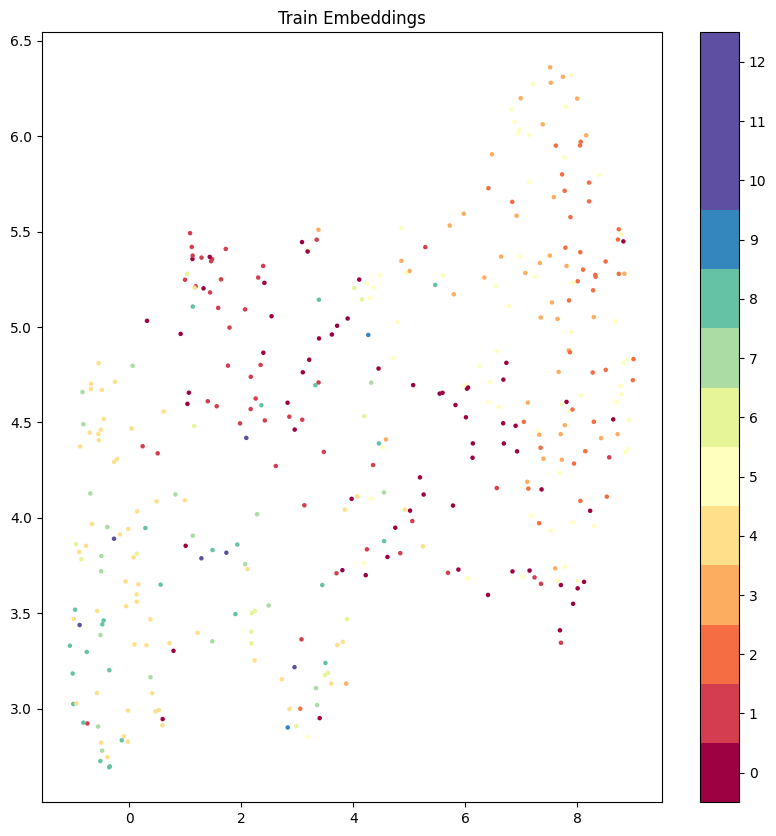

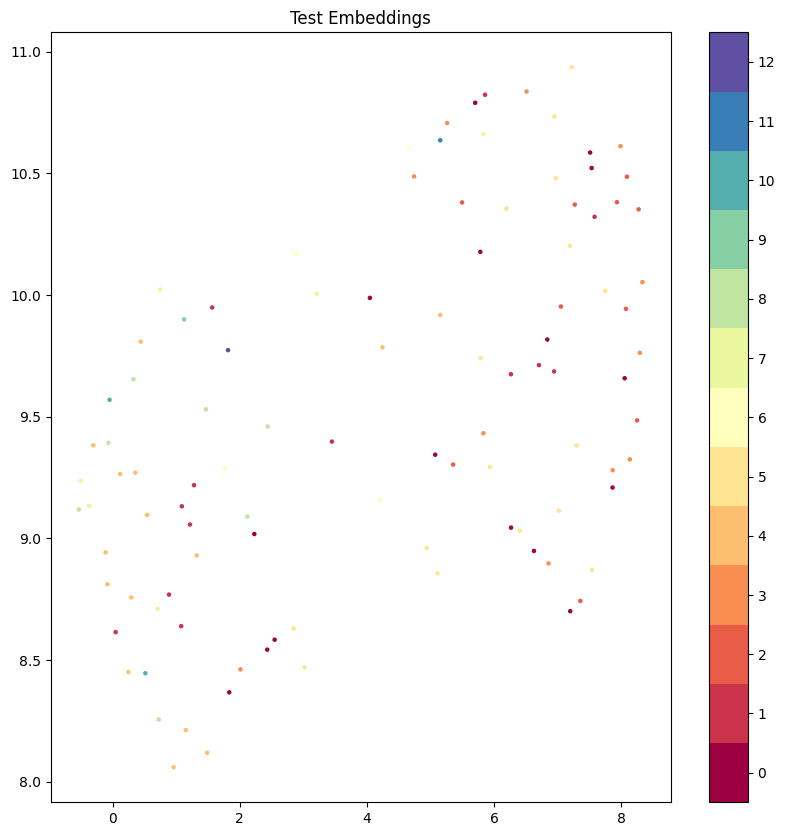

Epoch 2: Average Loss = 0.14133034646511078


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 12/12 [00:01<00:00,  8.38it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.39603960396039606
Test set accuracy (r_precision) = 0.34166270906436846


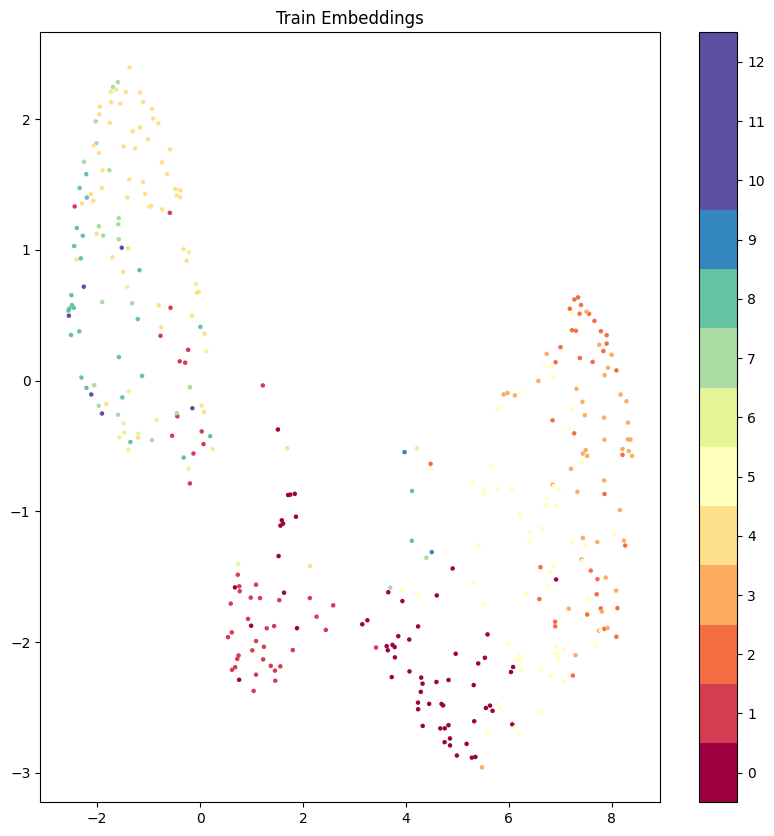

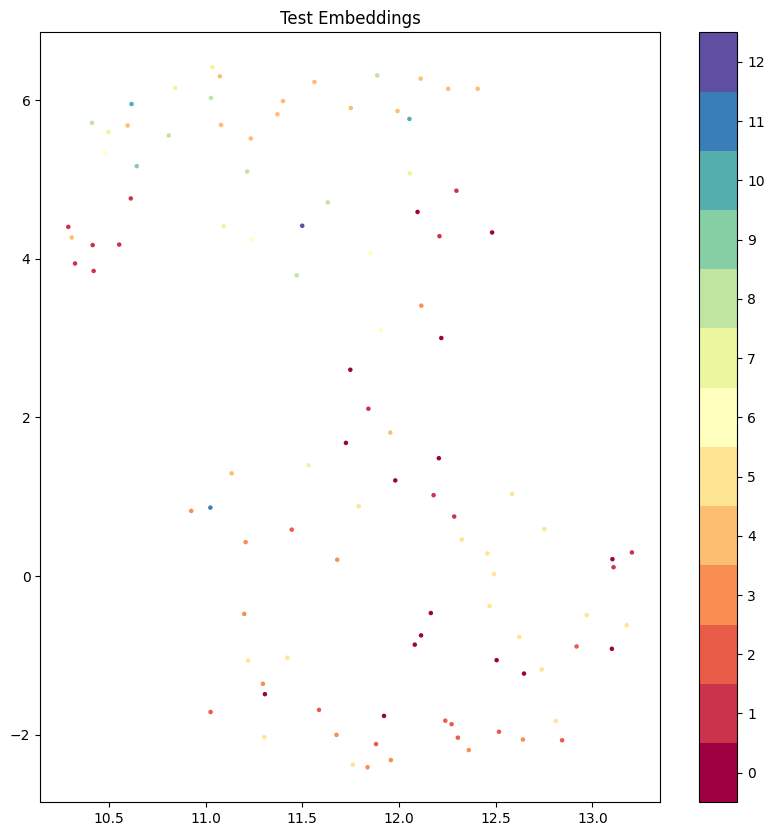

Epoch 3: Average Loss = 0.1167726032435894


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:01<00:00,  7.58it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  5.37it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.4752475247524752
Test set accuracy (r_precision) = 0.39198292327681994


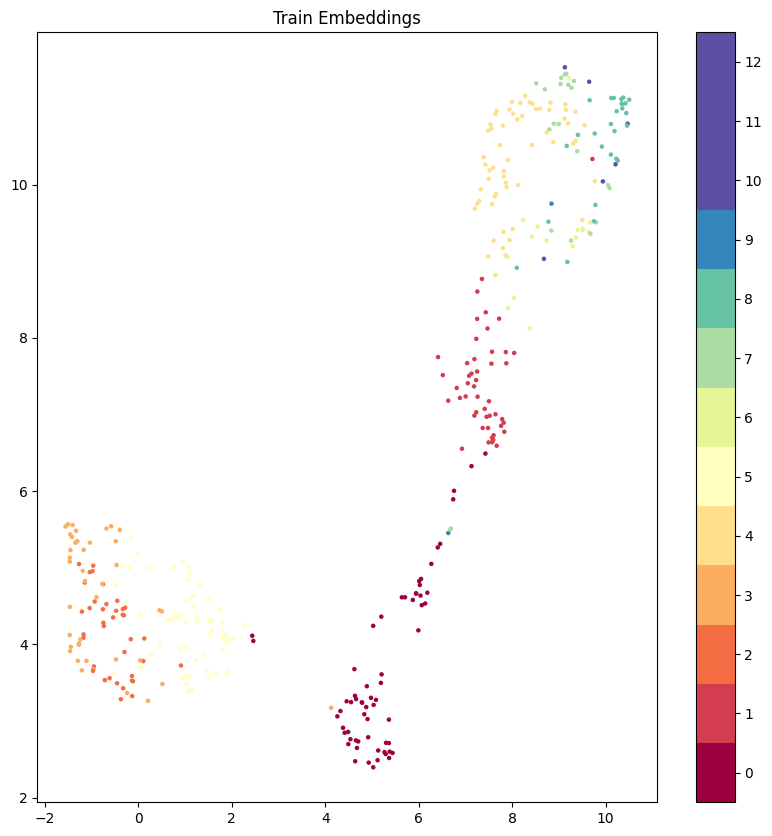

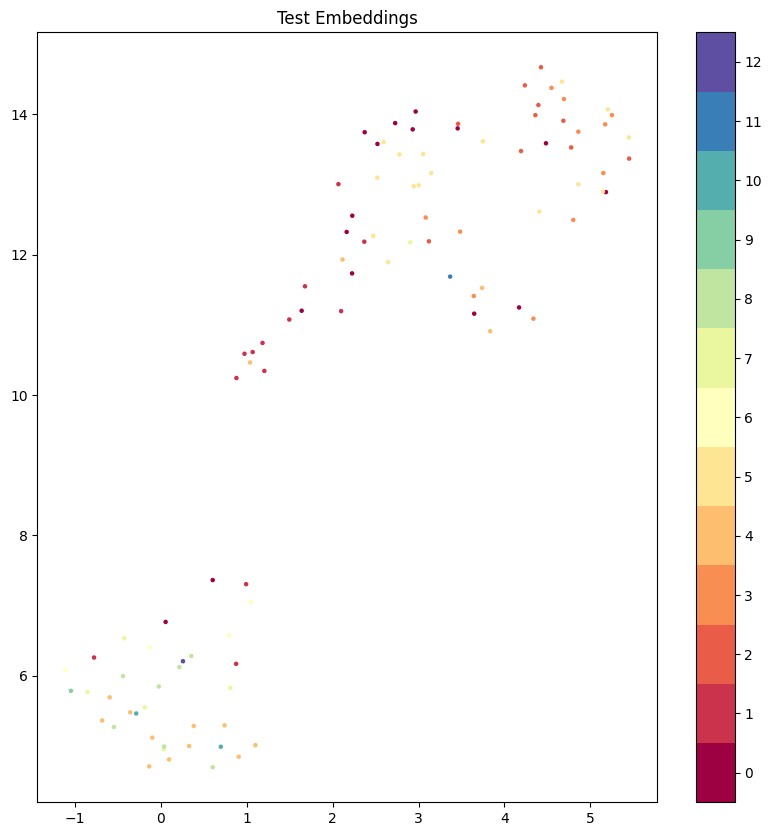

Epoch 4: Average Loss = 0.0880940668284893


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:01<00:00,  7.48it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  5.27it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5247524752475248
Test set accuracy (r_precision) = 0.43397658219190116


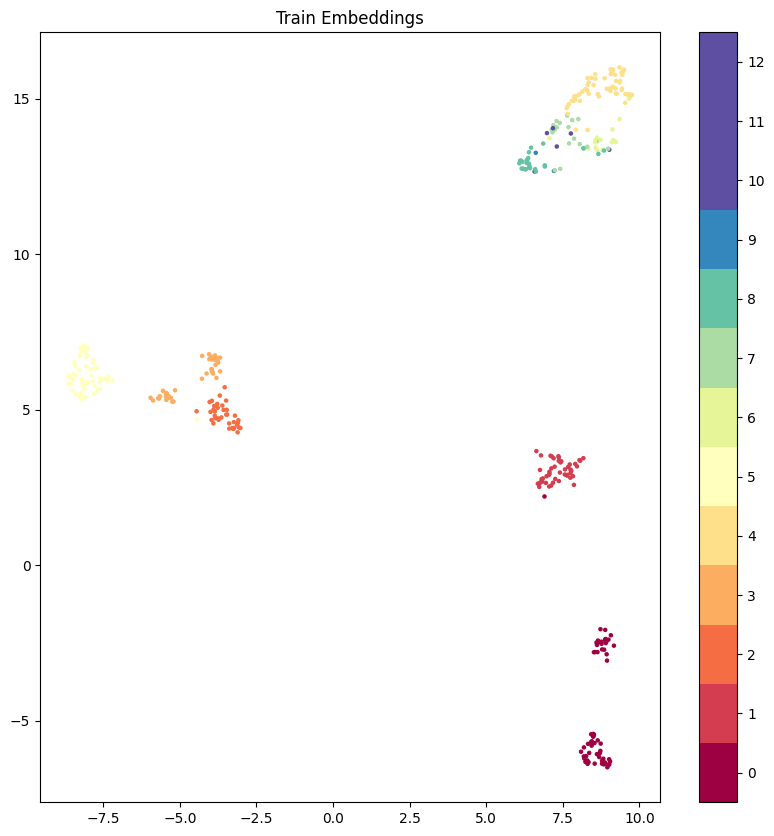

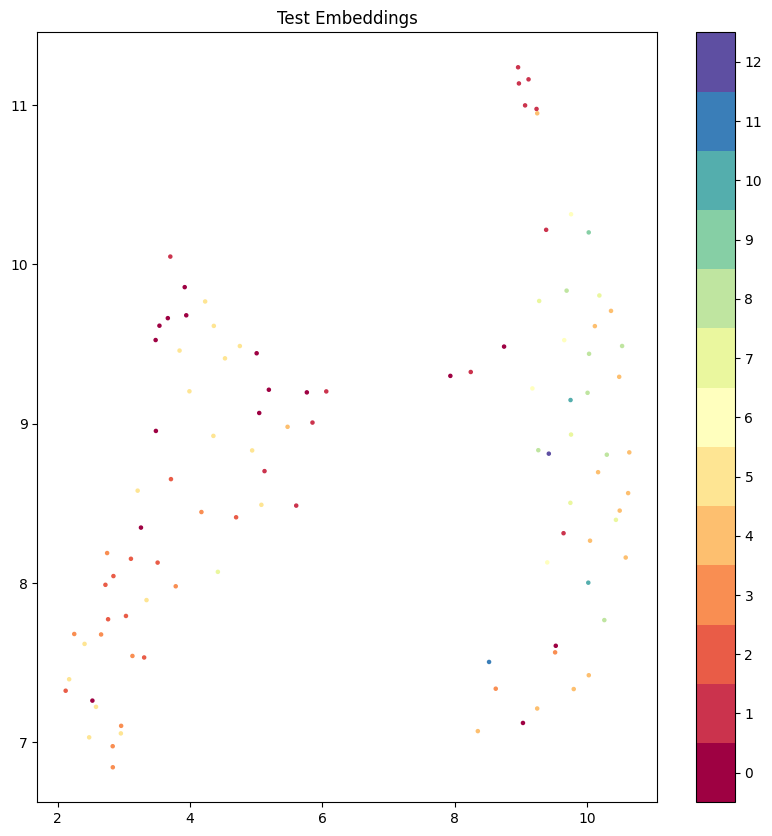

Epoch 5: Average Loss = 0.06285841763019562


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  5.83it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5247524752475248
Test set accuracy (r_precision) = 0.45963703527482463


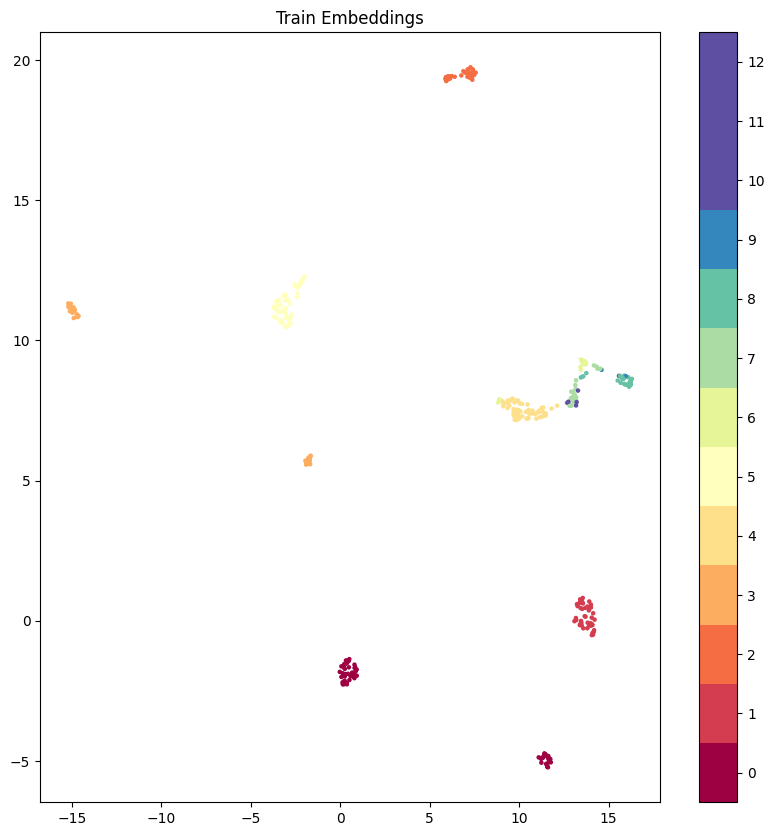

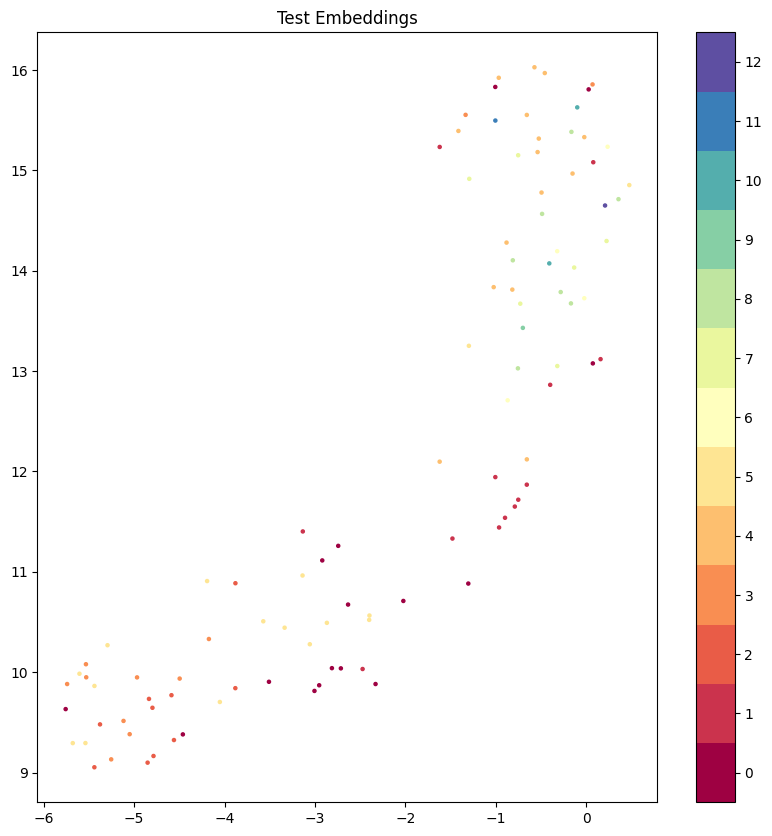

Epoch 6: Average Loss = 0.05475268512964249


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 12/12 [00:01<00:00,  7.93it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  5.18it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5247524752475248
Test set accuracy (r_precision) = 0.472993436884196


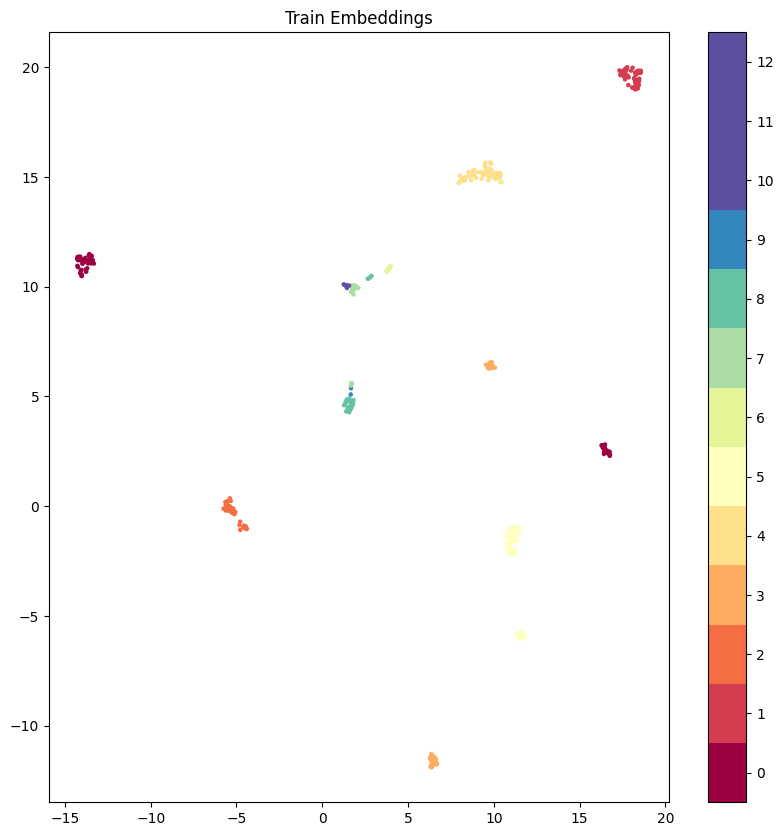

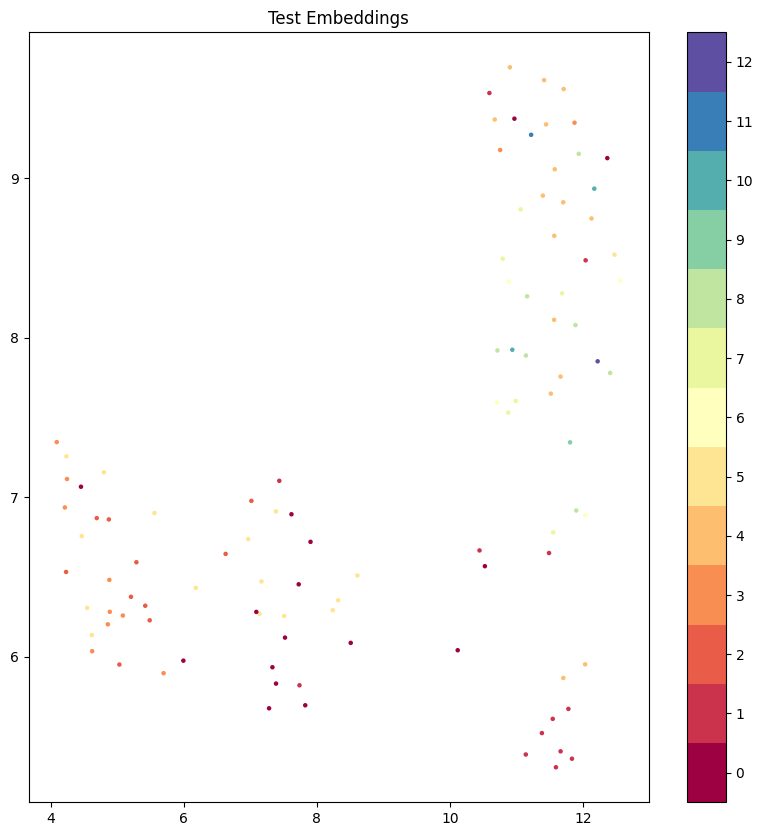

Epoch 7: Average Loss = 0.10910275019705296


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:01<00:00,  7.64it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5544554455445545
Test set accuracy (r_precision) = 0.47262152201356317


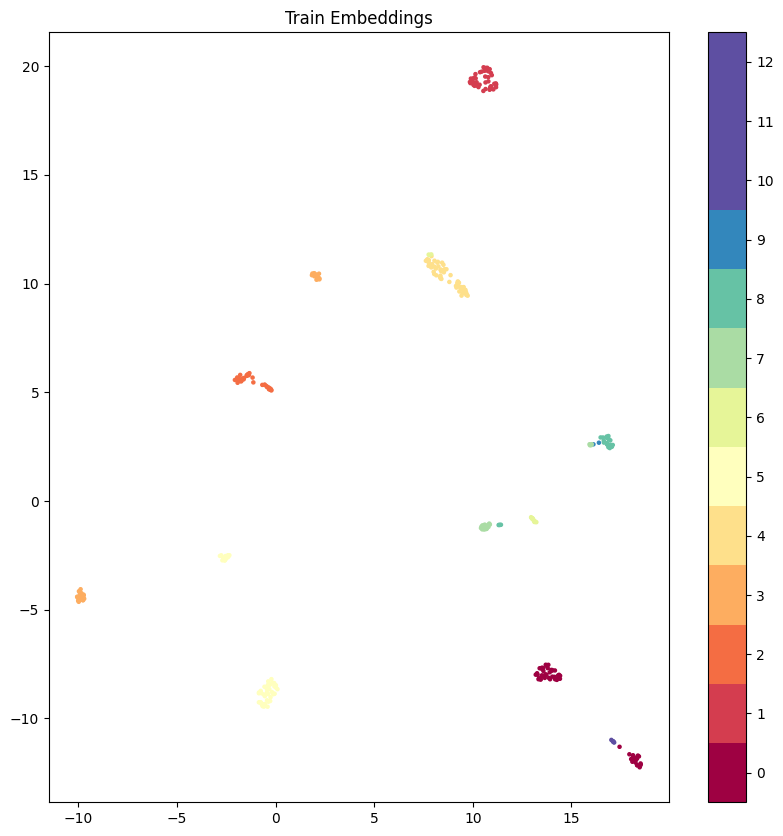

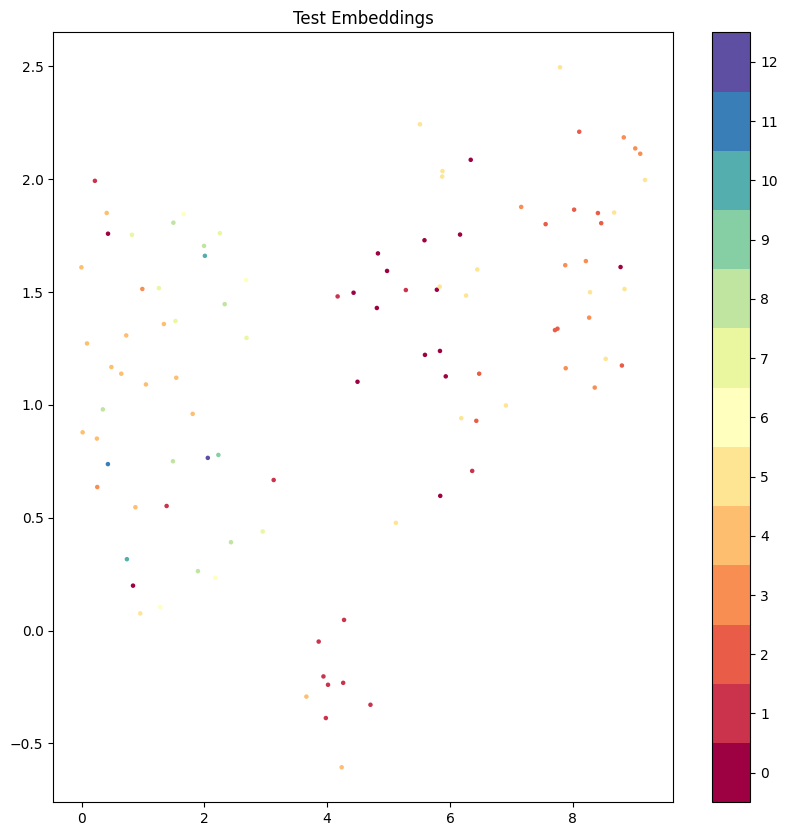

Epoch 8: Average Loss = 0.047315094619989395


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:01<00:00,  7.02it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5247524752475248
Test set accuracy (r_precision) = 0.48260491528933436


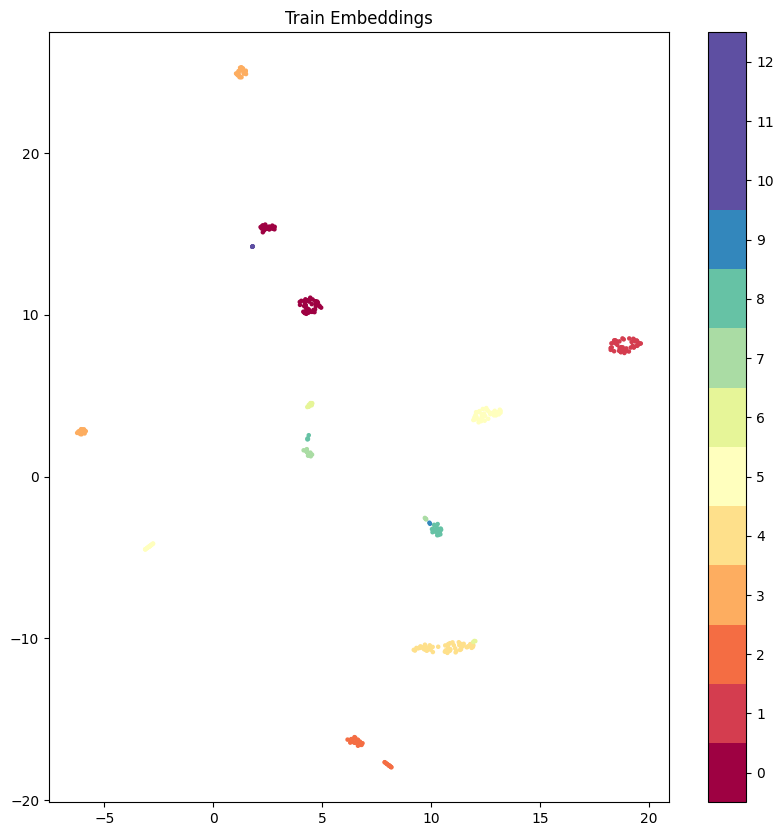

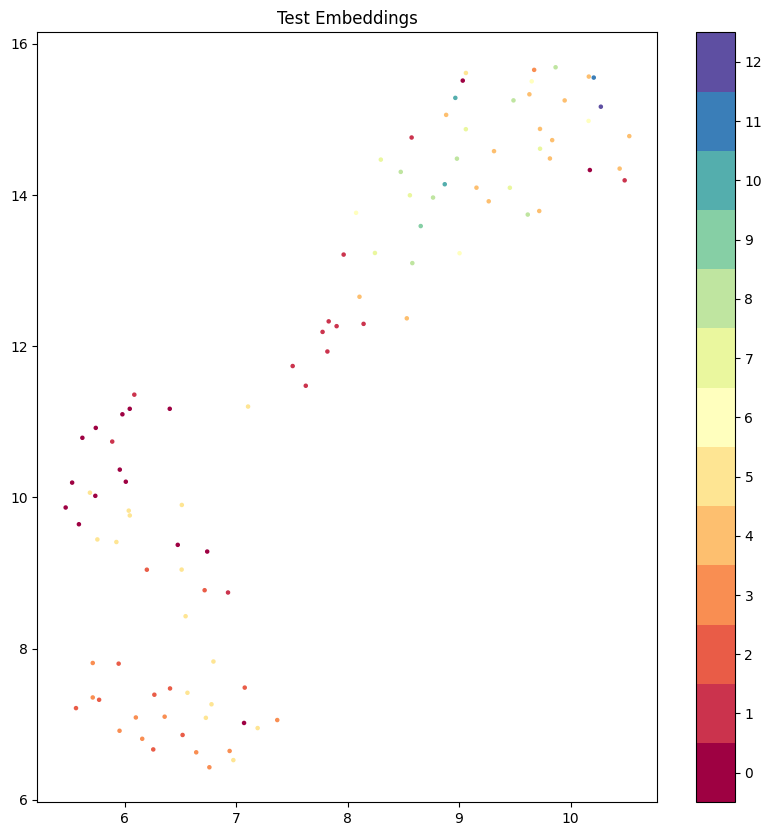

Epoch 9: Average Loss = 0.022972382605075836


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5544554455445545
Test set accuracy (r_precision) = 0.49370707183104734


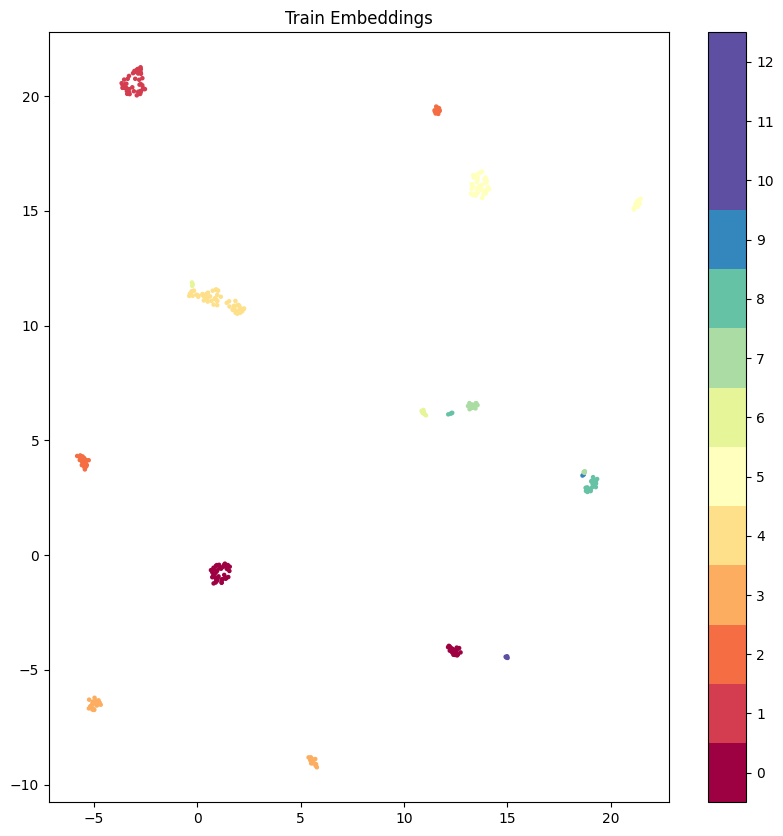

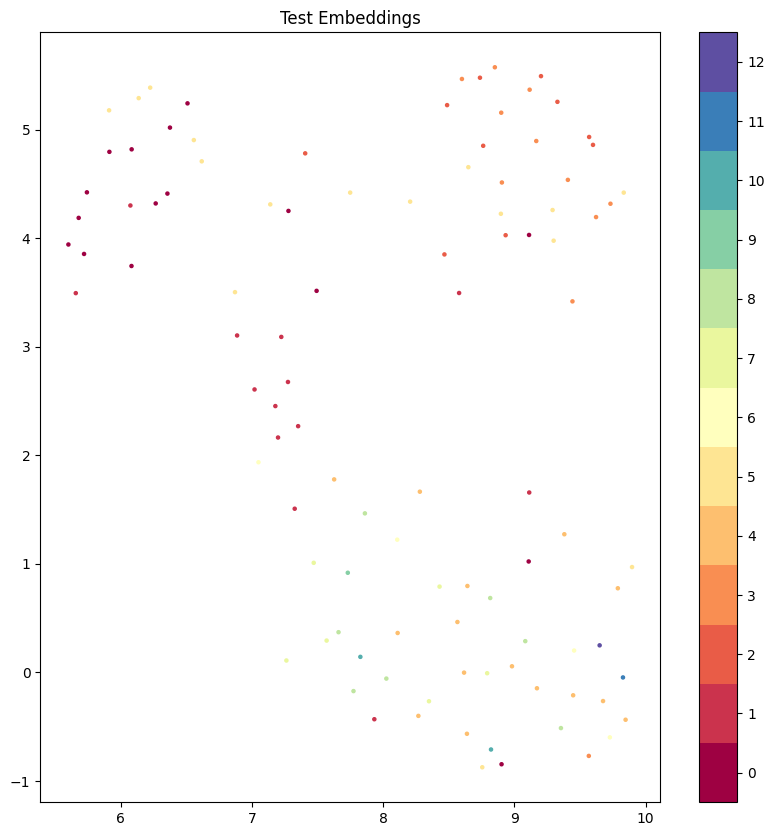

Epoch 10: Average Loss = 0.025572442798875272


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:01<00:00,  7.76it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5346534653465347
Test set accuracy (r_precision) = 0.48768662964355086


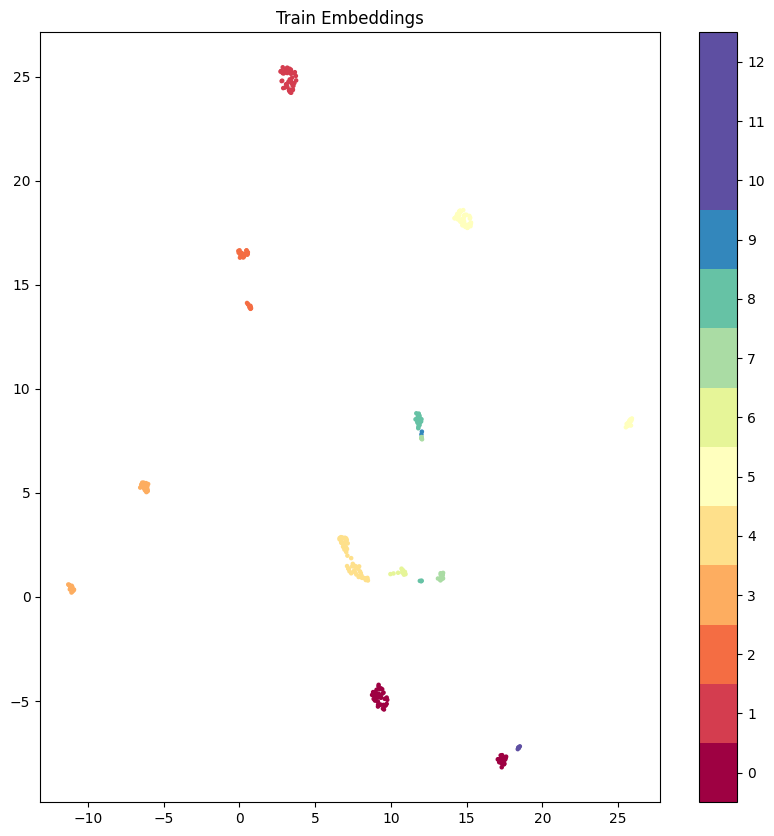

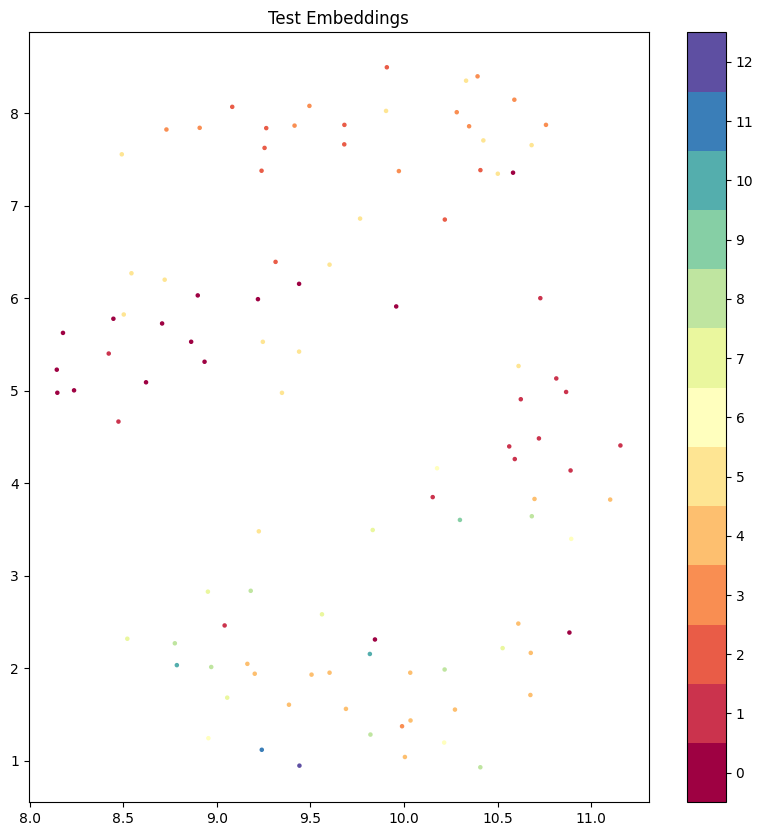

Epoch 11: Average Loss = 0.03375292755663395


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:01<00:00,  7.01it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.49504950495049505
Test set accuracy (r_precision) = 0.4787533104827968


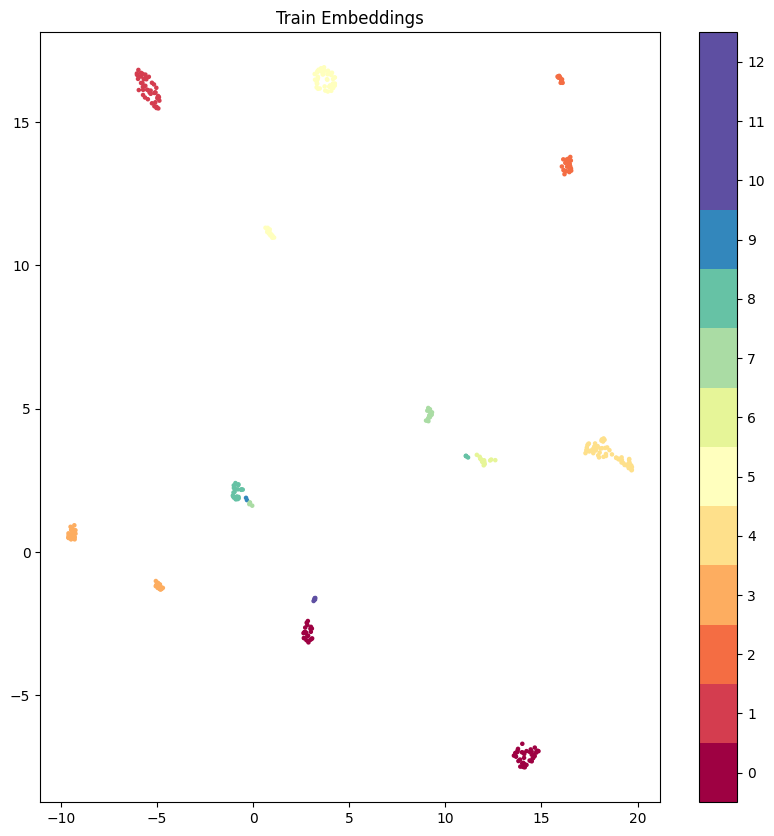

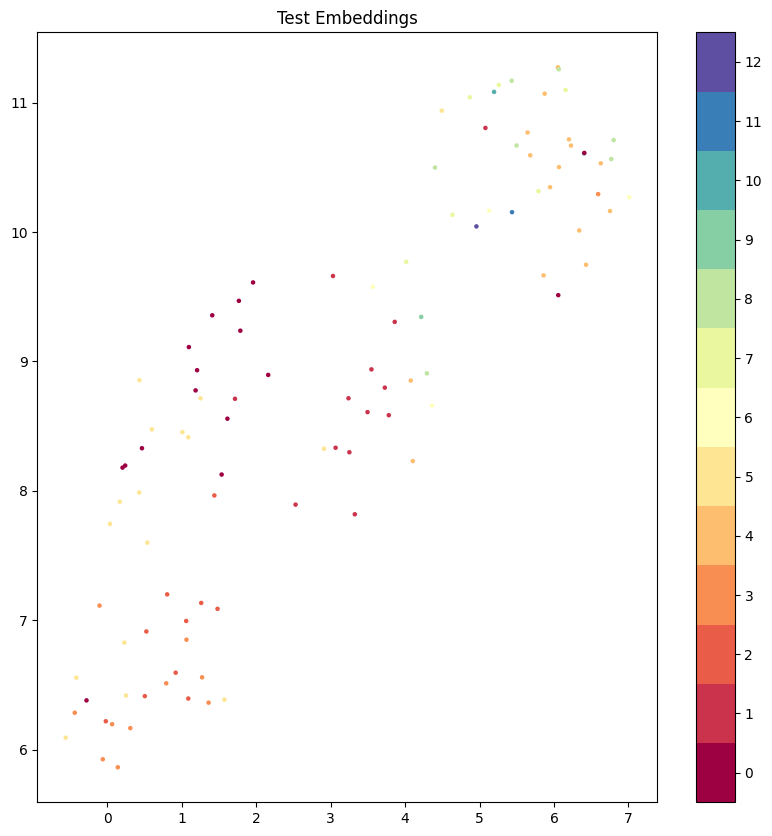

Epoch 12: Average Loss = 0.03506624139845371


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:01<00:00,  6.88it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5247524752475248
Test set accuracy (r_precision) = 0.46987460970656403


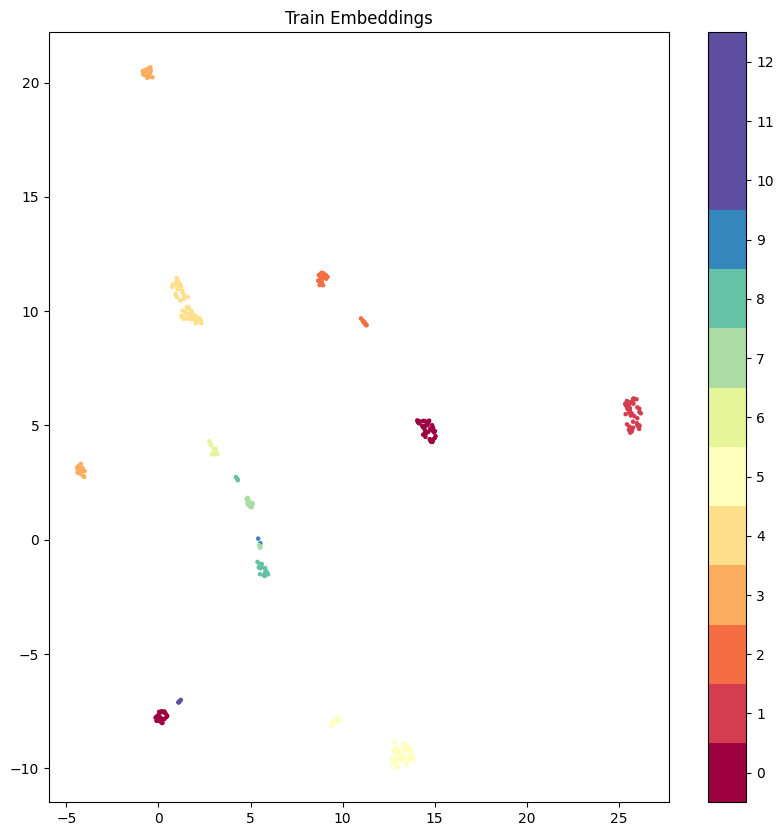

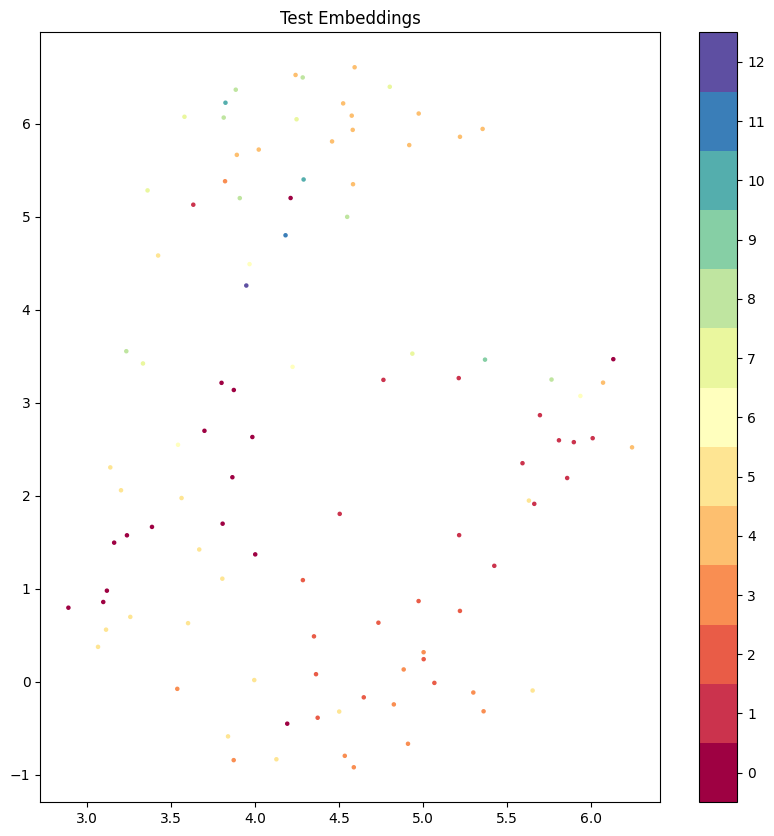

Epoch 13: Average Loss = 0.014877233654260635


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:01<00:00,  6.99it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5148514851485149
Test set accuracy (r_precision) = 0.48479917402774136


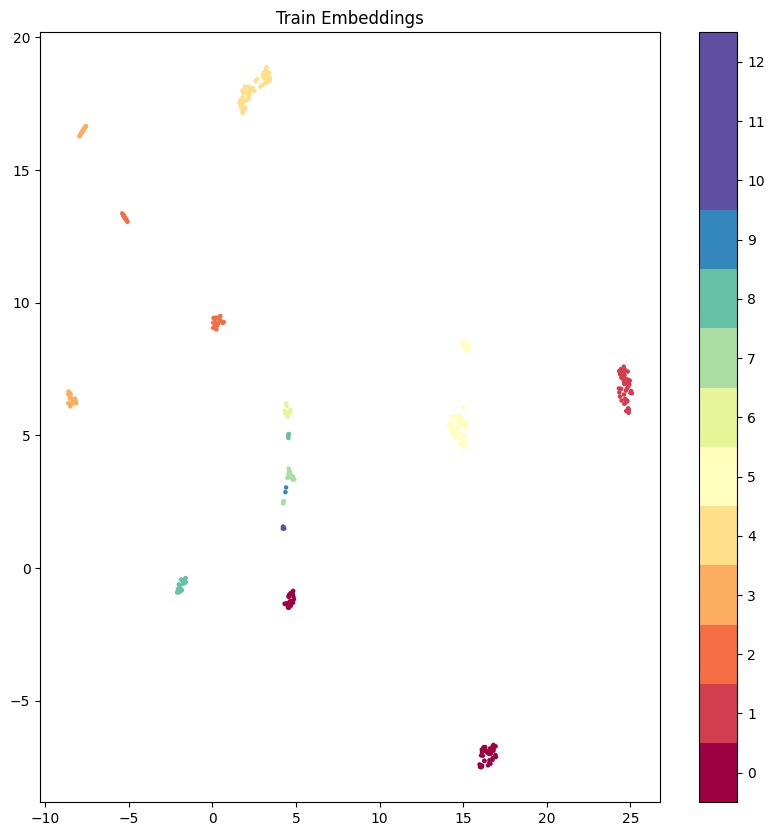

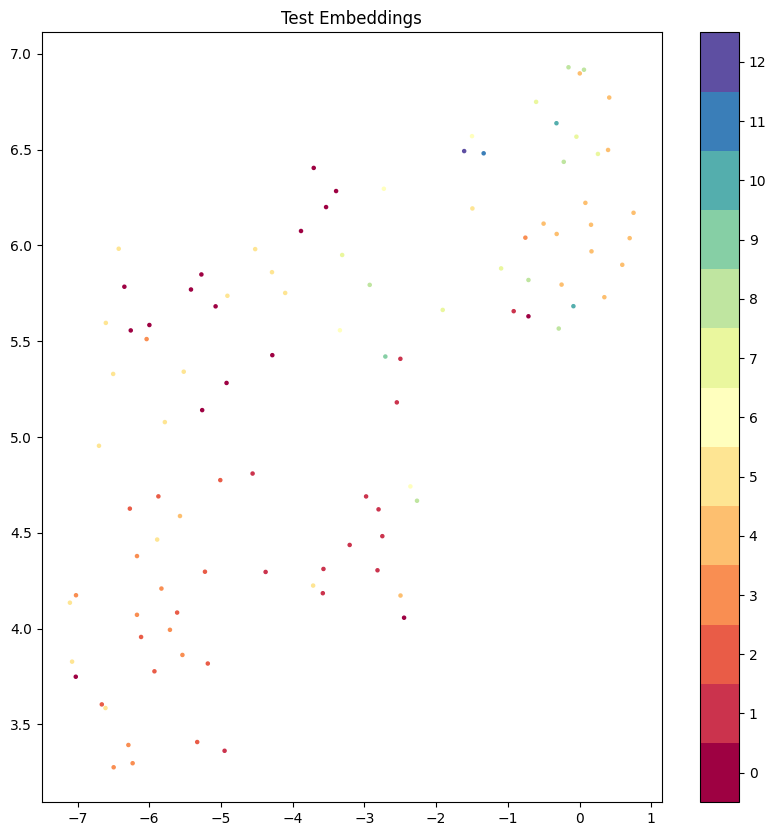

Epoch 14: Average Loss = 0.03560774587094784


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  7.04it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5544554455445545
Test set accuracy (r_precision) = 0.49677641840676195


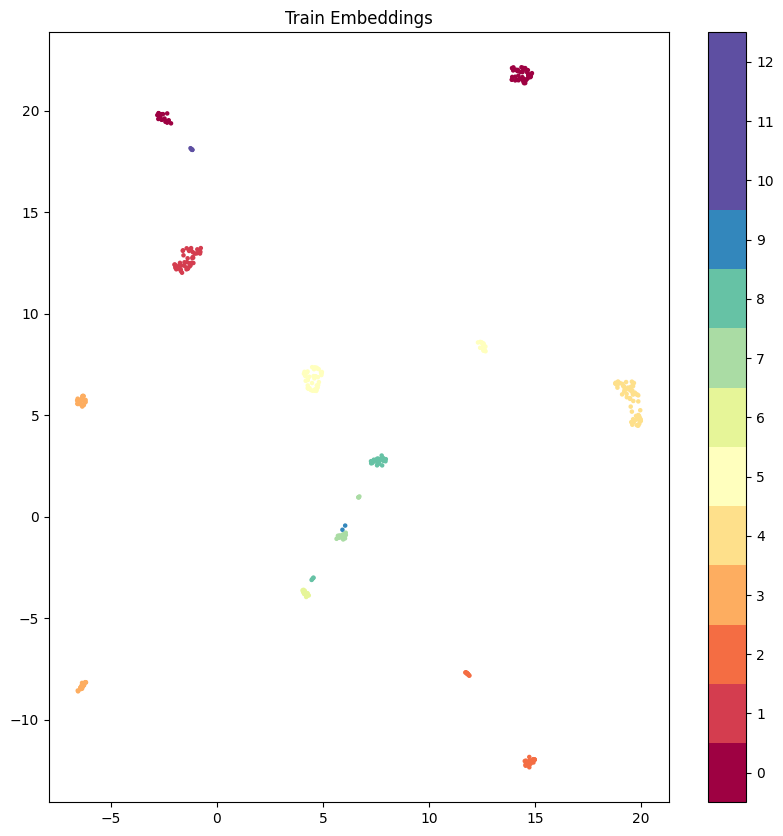

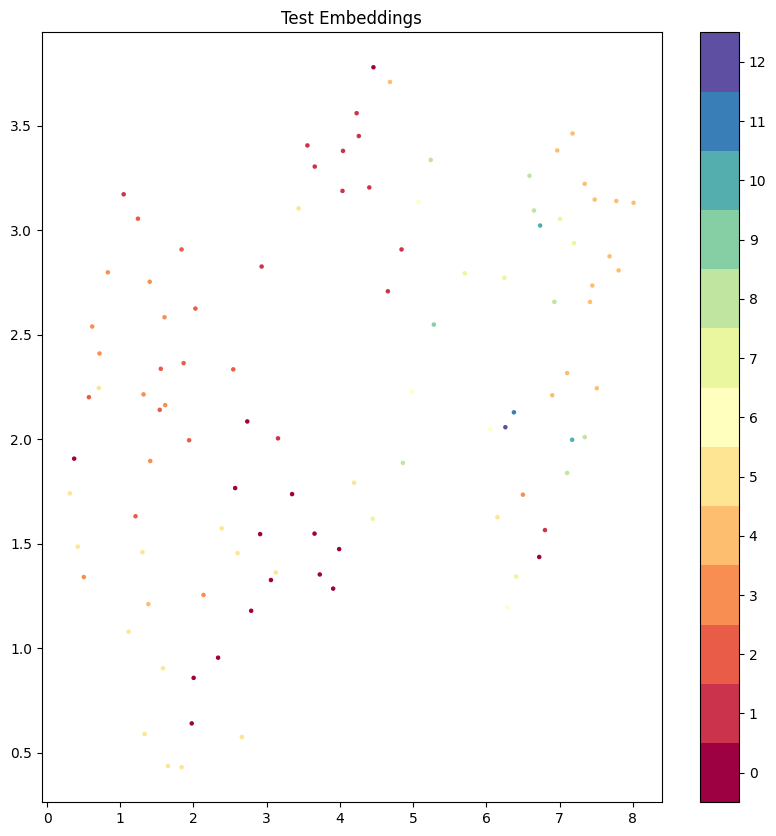

Epoch 15: Average Loss = 0.027398088946938515


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 12/12 [00:03<00:00,  3.68it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.11it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5841584158415841
Test set accuracy (r_precision) = 0.505388019244627


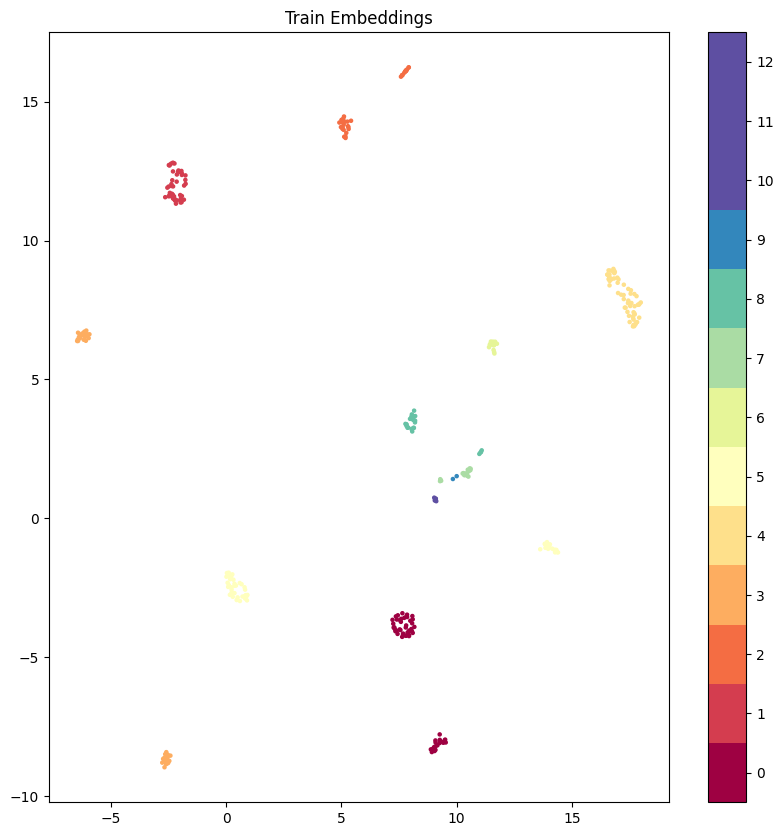

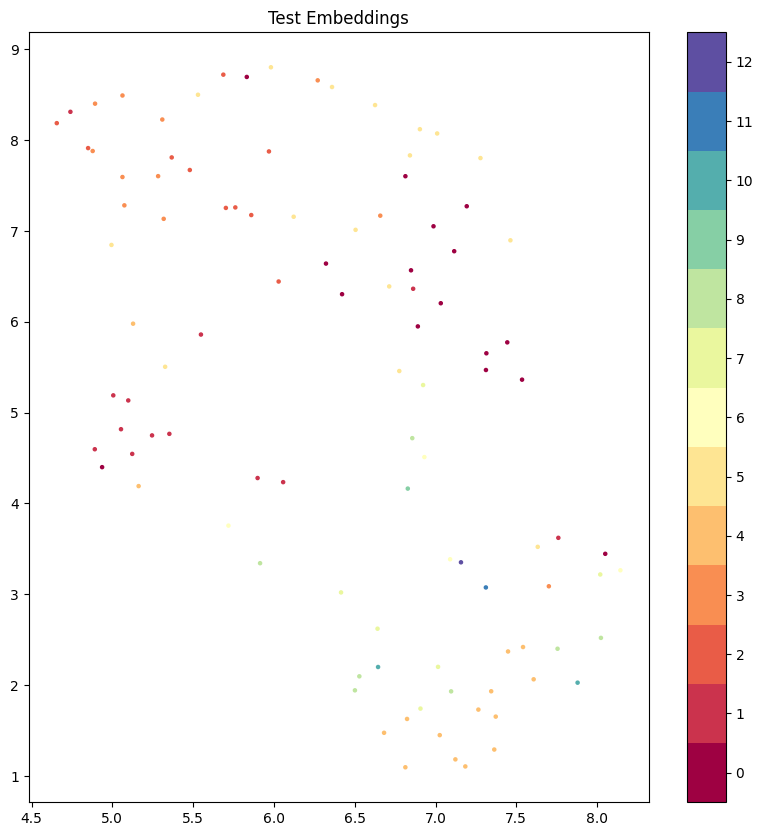

Epoch 16: Average Loss = 0.057289544492959976


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 12/12 [00:02<00:00,  5.33it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5841584158415841
Test set accuracy (r_precision) = 0.5091411743044807


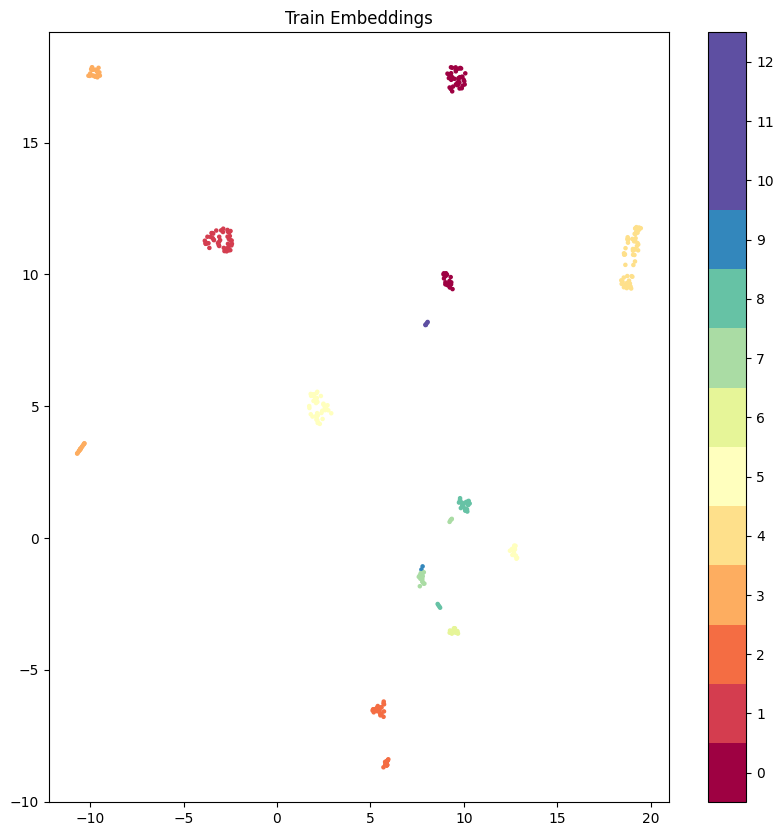

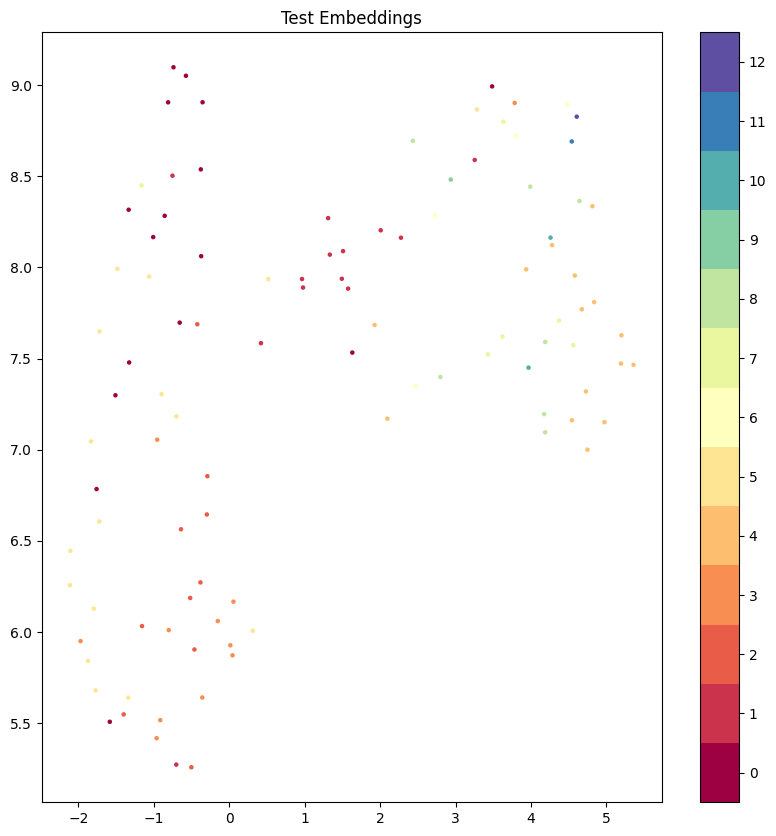

Epoch 17: Average Loss = 0.013017025776207447


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6039603960396039
Test set accuracy (r_precision) = 0.5111855421796321


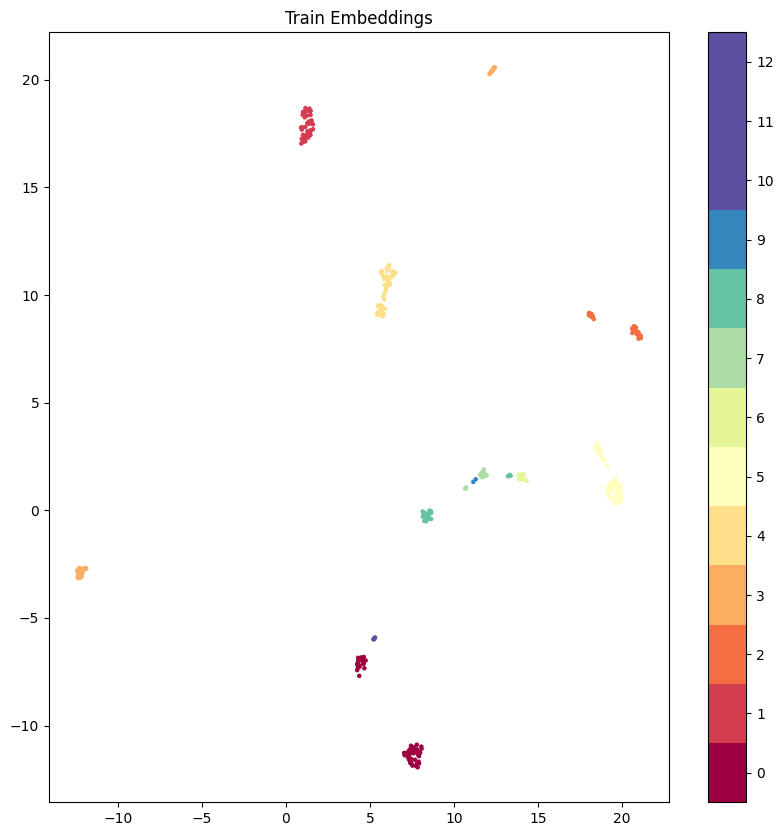

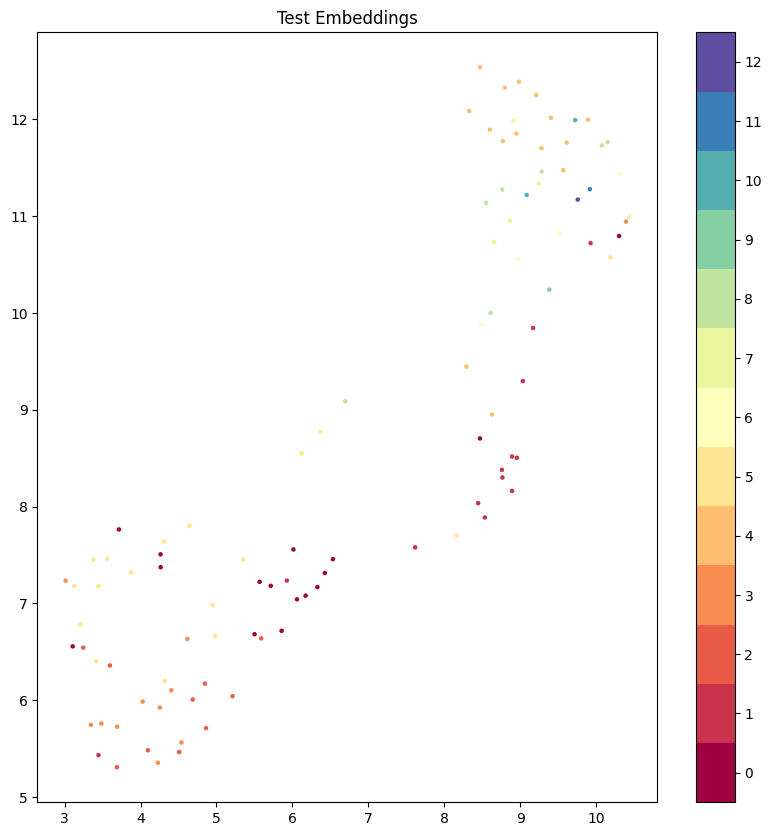

Epoch 18: Average Loss = 0.0436696819961071


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:01<00:00,  6.78it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5445544554455446
Test set accuracy (r_precision) = 0.5187727489739006


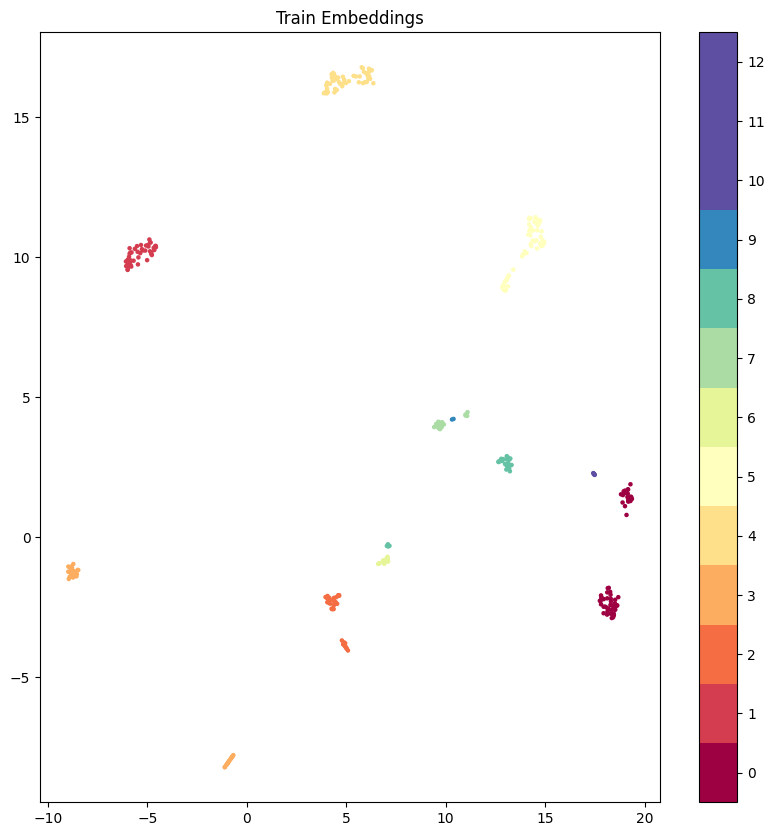

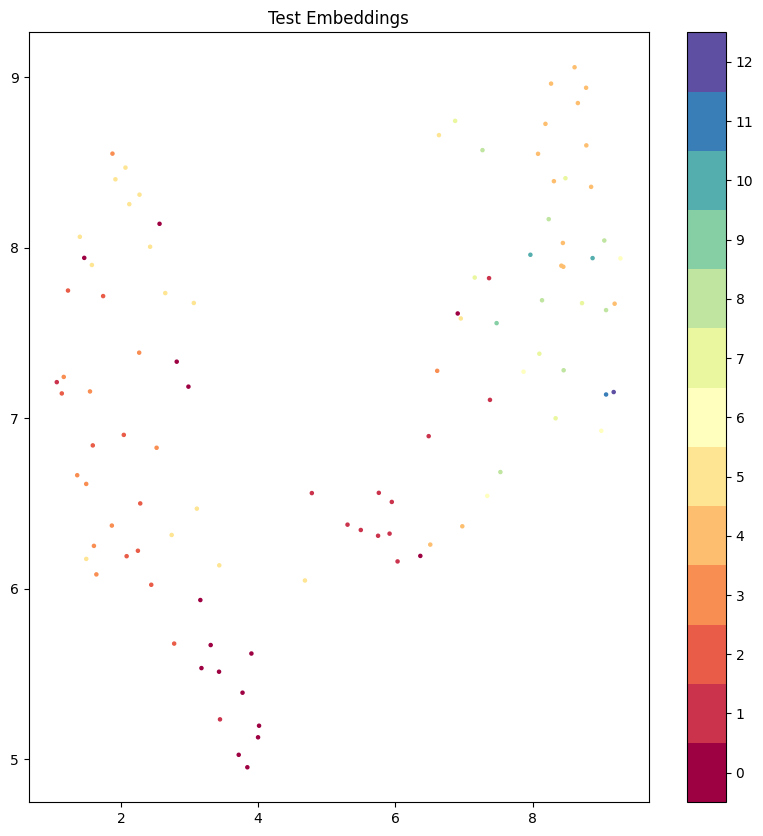

Epoch 19: Average Loss = 0.05541749484837055


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:01<00:00,  7.23it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5346534653465347
Test set accuracy (r_precision) = 0.516341582258305


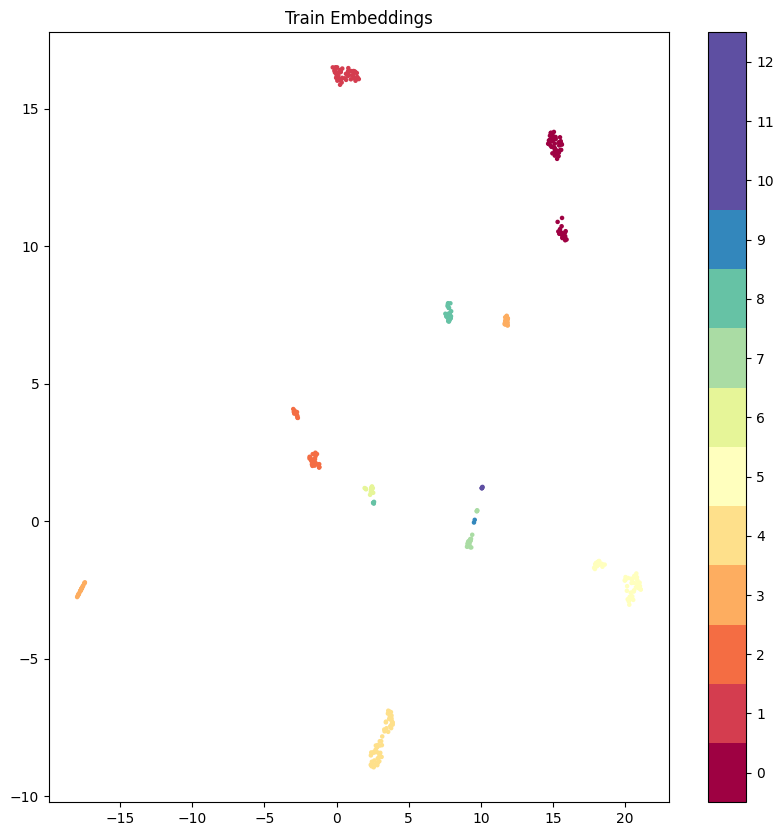

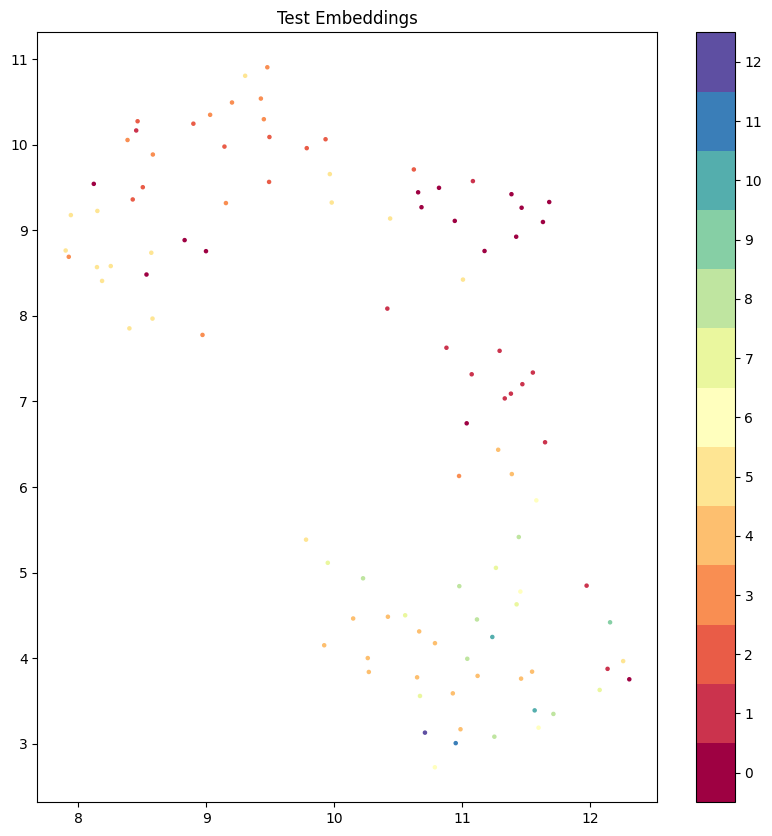

Epoch 20: Average Loss = 0.010703569278120995


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 12/12 [00:02<00:00,  7.48it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5643564356435644
Test set accuracy (r_precision) = 0.5129432458527757


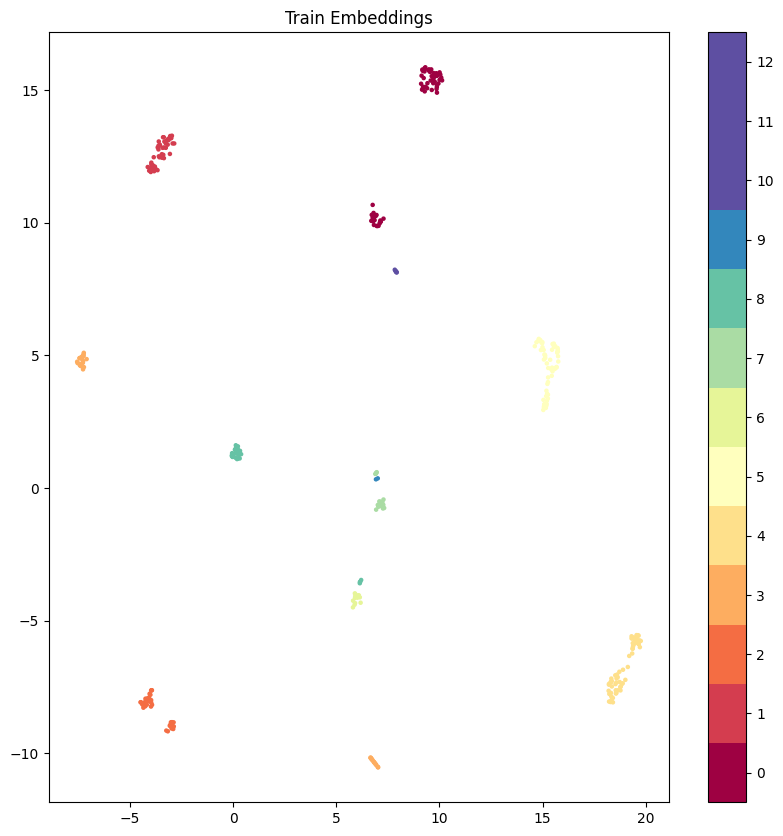

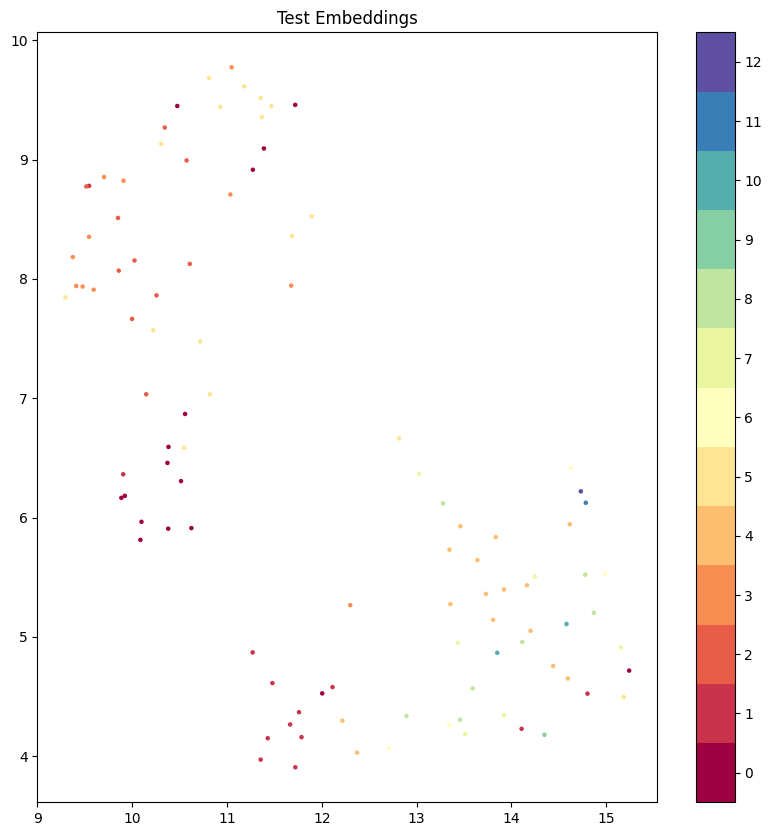

Epoch 21: Average Loss = 0.014656759798526764


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:04<00:00,  2.65it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.08it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5544554455445545
Test set accuracy (r_precision) = 0.5051876889089324


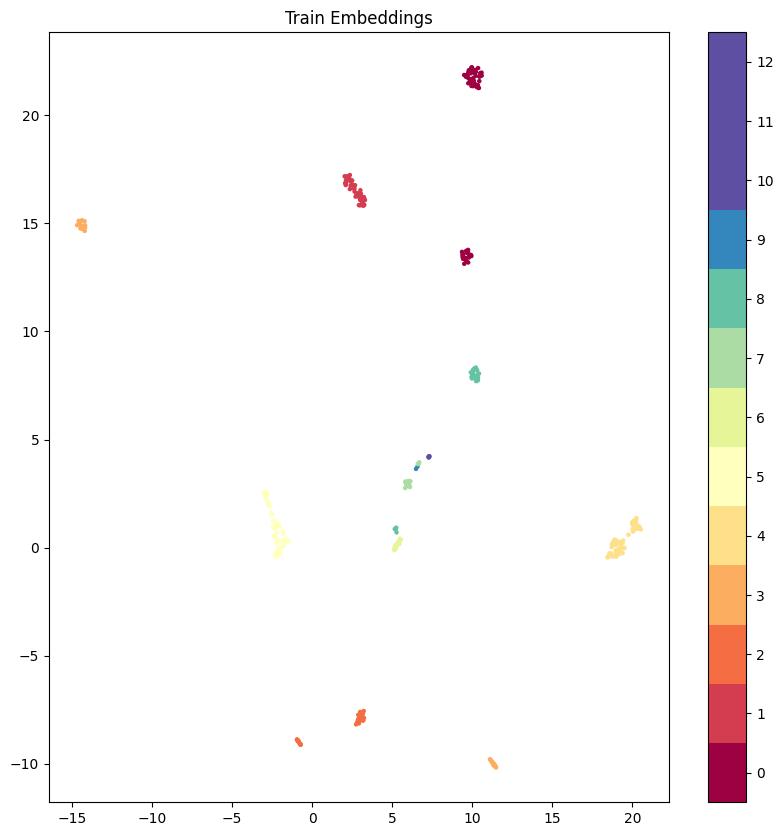

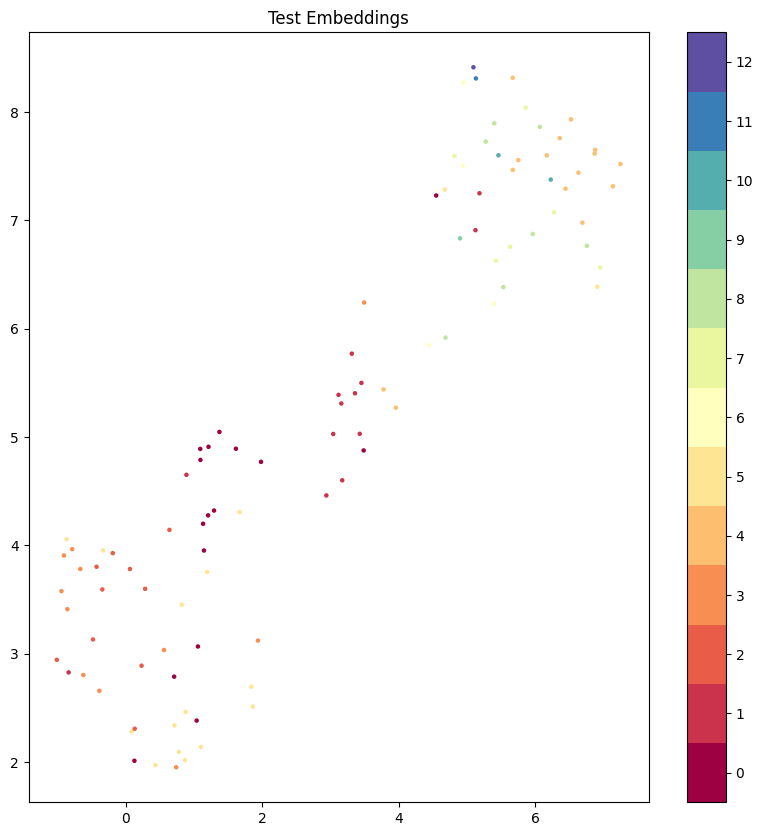

Epoch 22: Average Loss = 0.021750968880951405


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:01<00:00,  7.06it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5742574257425742
Test set accuracy (r_precision) = 0.4984485716982057


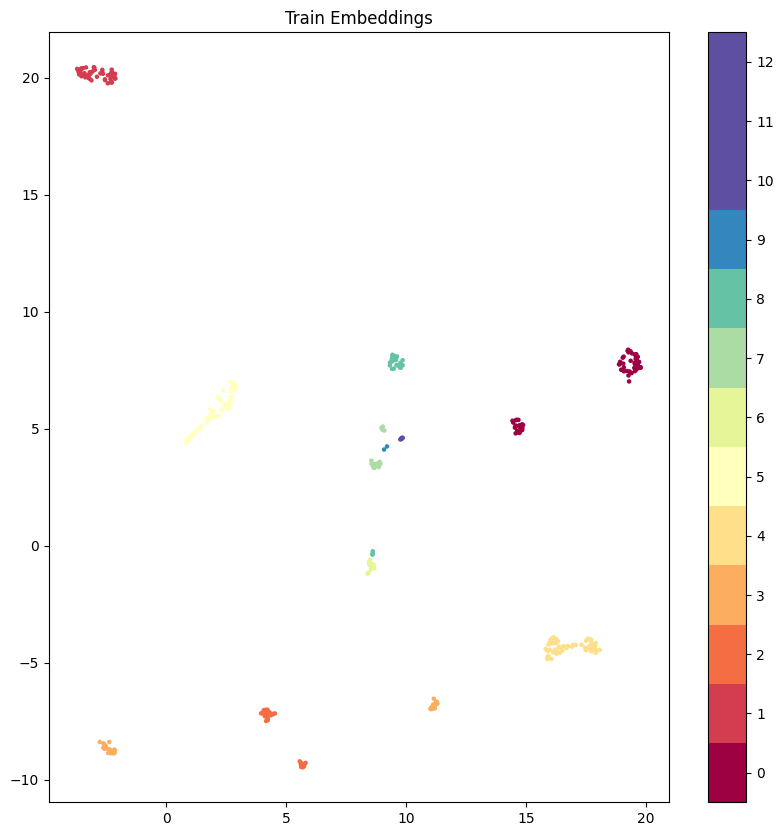

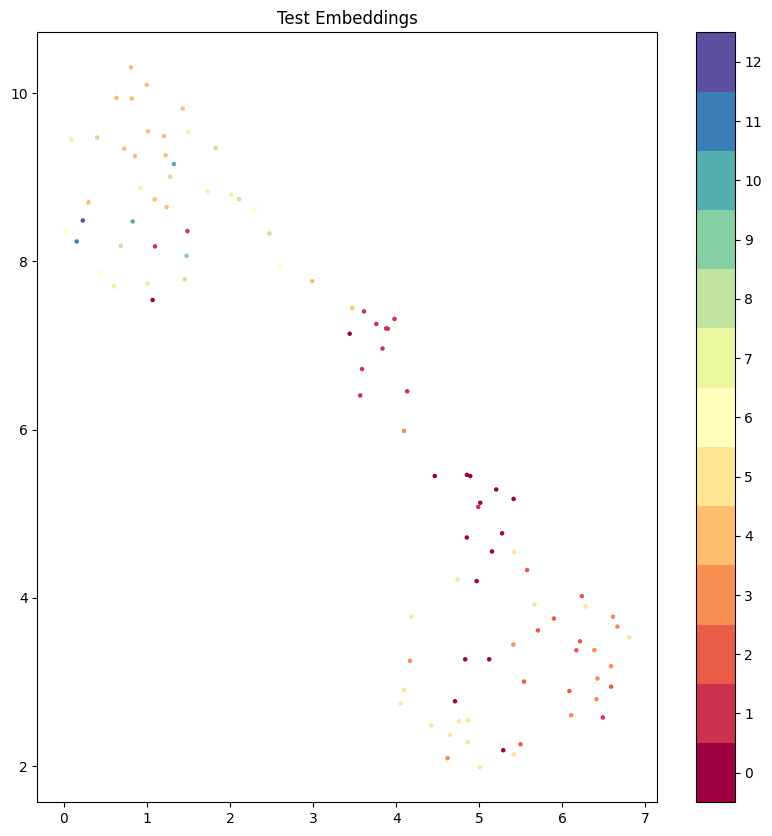

Epoch 23: Average Loss = 0.03143032919615507


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5643564356435644
Test set accuracy (r_precision) = 0.49178124309947


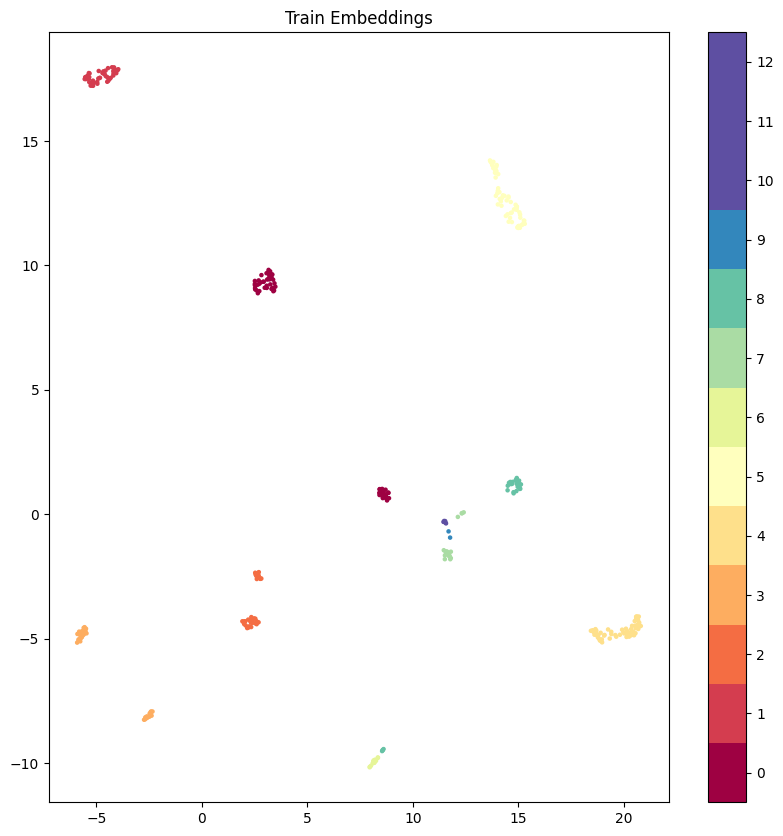

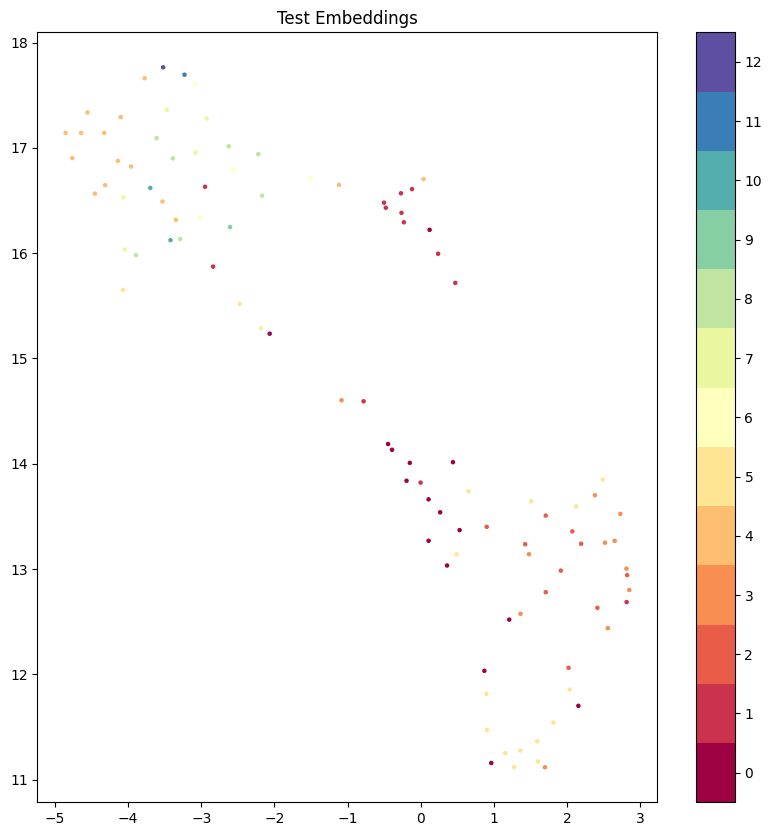

Epoch 24: Average Loss = 0.009504744783043861


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  6.71it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5643564356435644
Test set accuracy (r_precision) = 0.4837973662254559


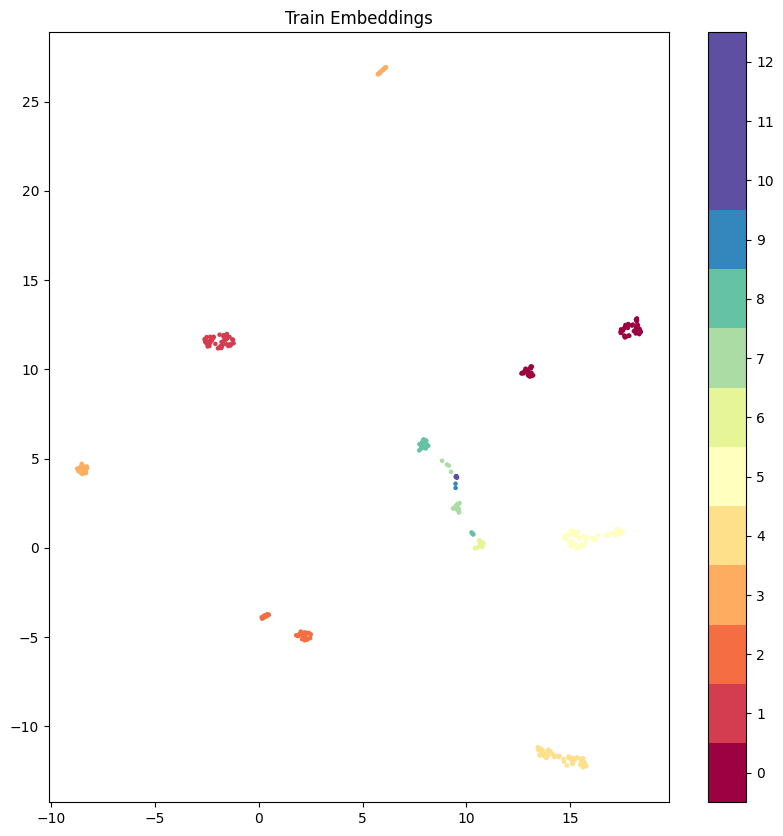

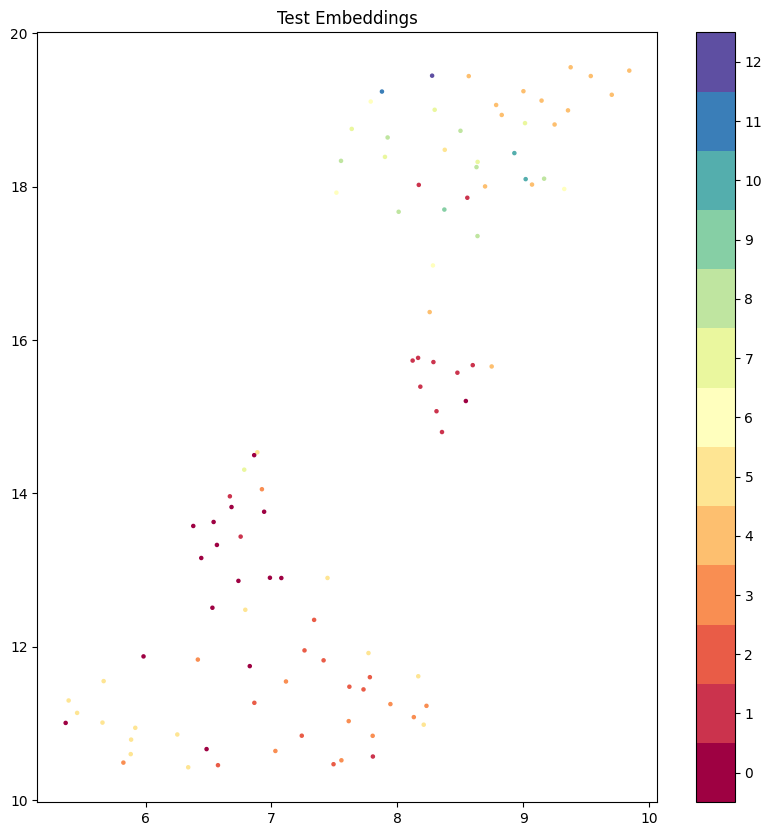

Epoch 25: Average Loss = 0.01839674706570804


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  4.49it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5445544554455446
Test set accuracy (r_precision) = 0.48144958172780566


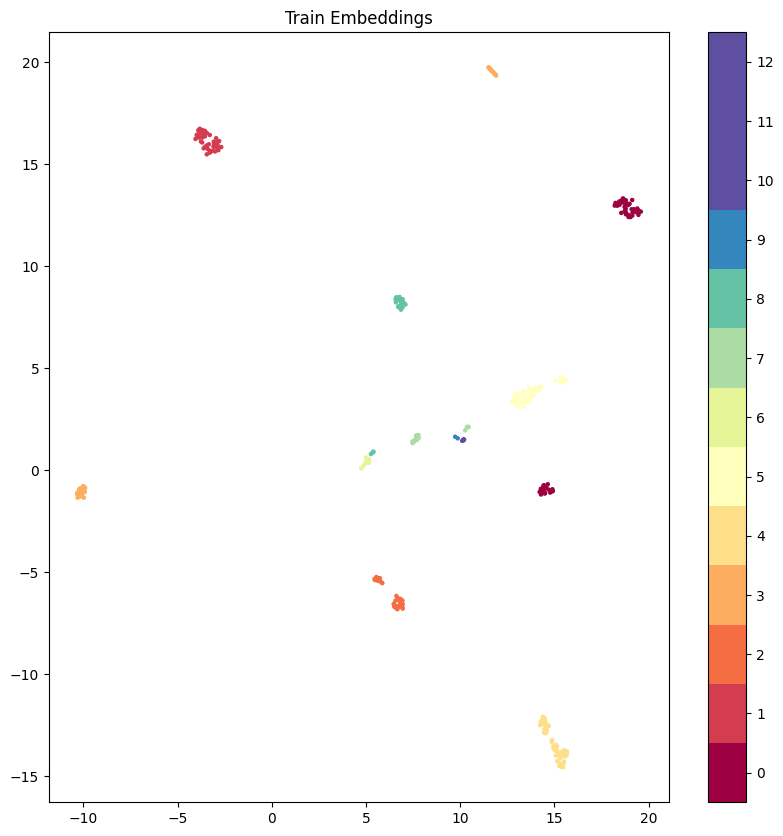

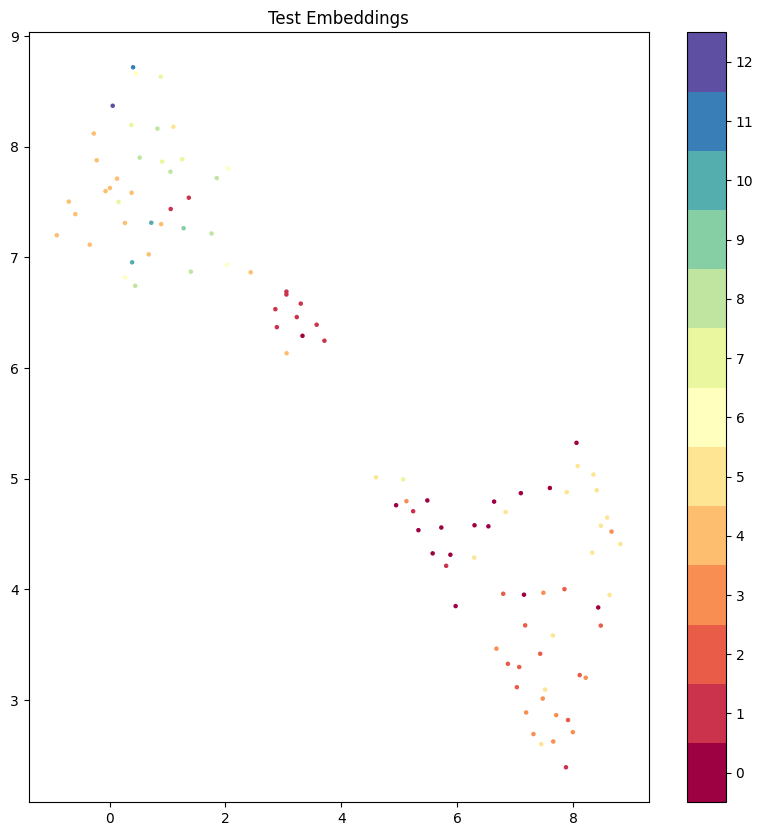

Epoch 26: Average Loss = 0.029565878212451935


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  4.68it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.26it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5346534653465347
Test set accuracy (r_precision) = 0.4886904170780676


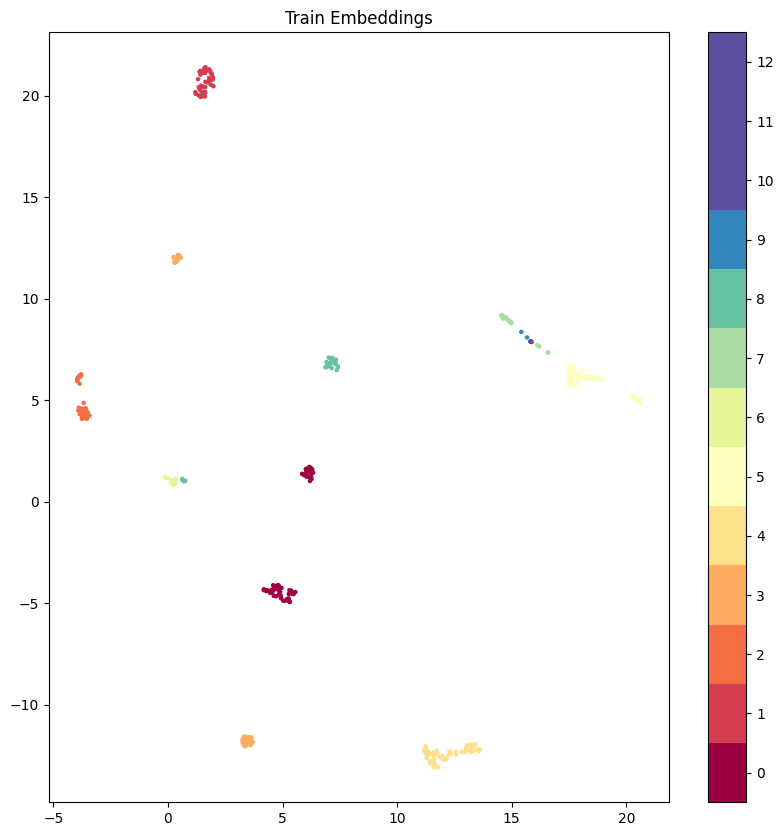

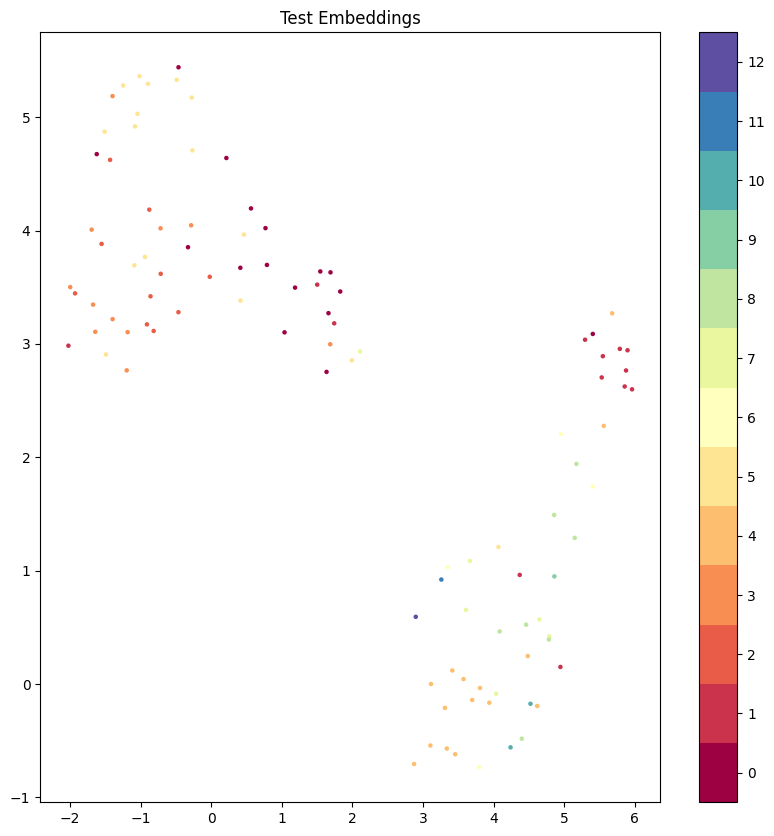

Epoch 27: Average Loss = 0.032120734453201294


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 12/12 [00:02<00:00,  5.20it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5247524752475248
Test set accuracy (r_precision) = 0.49704695600667514


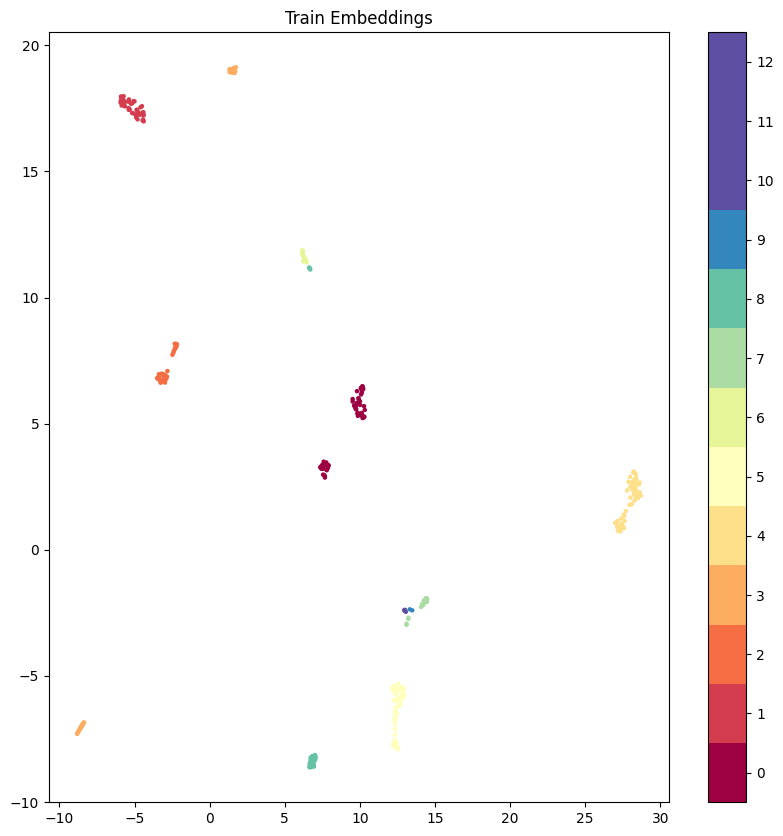

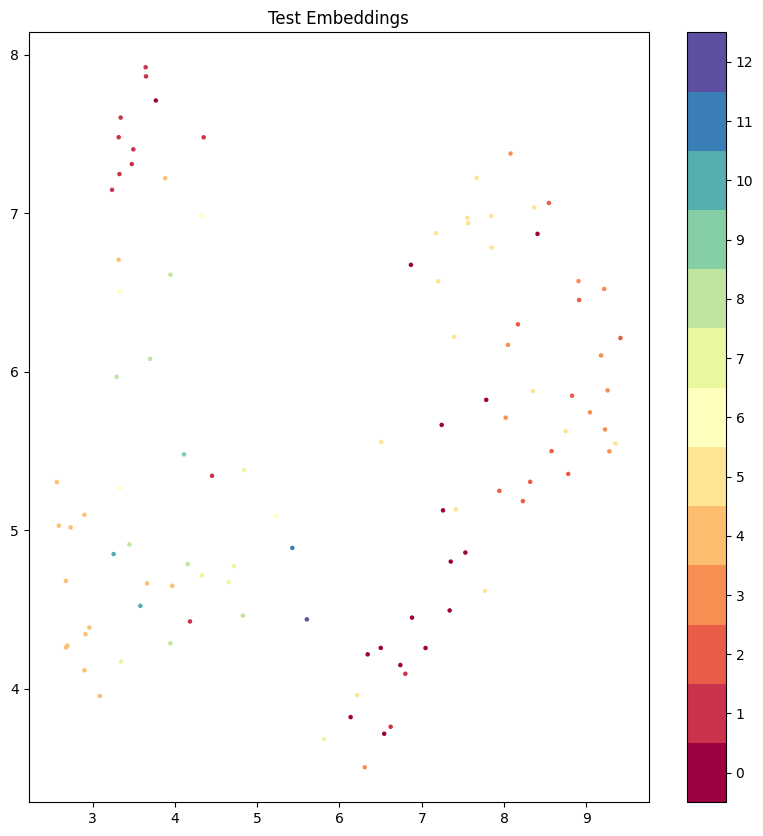

Epoch 28: Average Loss = 0.028153796680271626


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5346534653465347
Test set accuracy (r_precision) = 0.4997049907831093


Epoch 29: Average Loss = 0.014237442053854465


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 12/12 [00:02<00:00,  7.36it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.21it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5346534653465347
Test set accuracy (r_precision) = 0.497295766950874


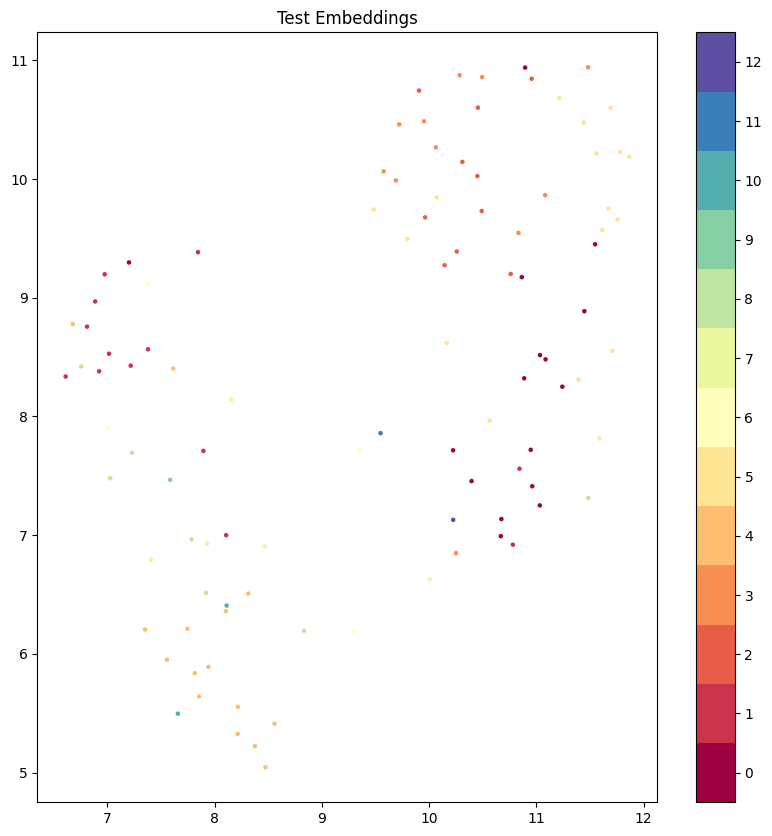

Epoch 30: Average Loss = 0.04199907183647156


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  6.14it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5544554455445545
Test set accuracy (r_precision) = 0.49585767044158413


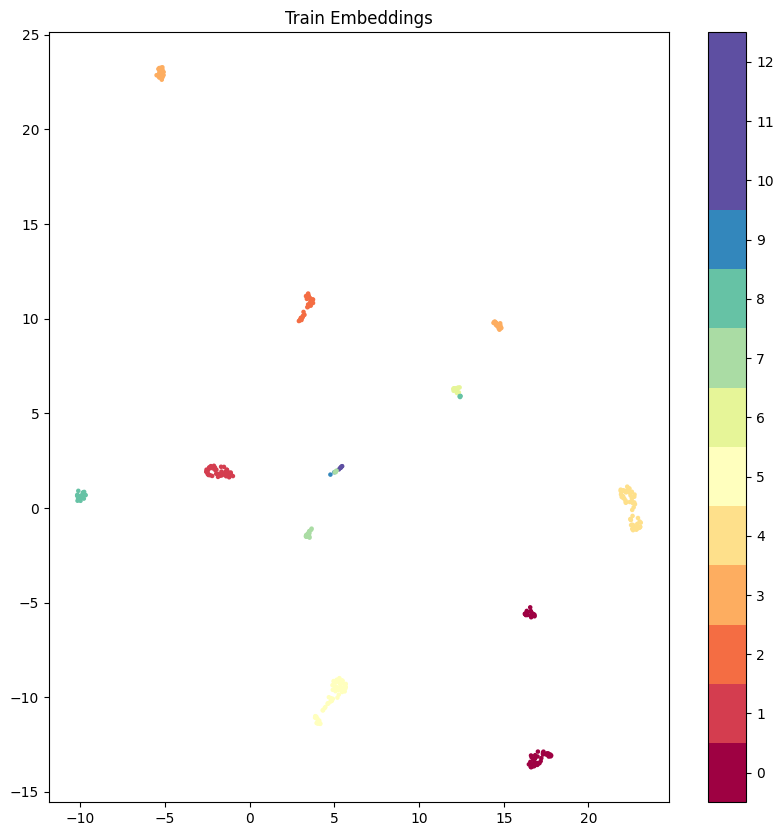

Epoch 31: Average Loss = 0.03714750520884991


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  6.46it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.52it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5742574257425742
Test set accuracy (r_precision) = 0.5064848551694909


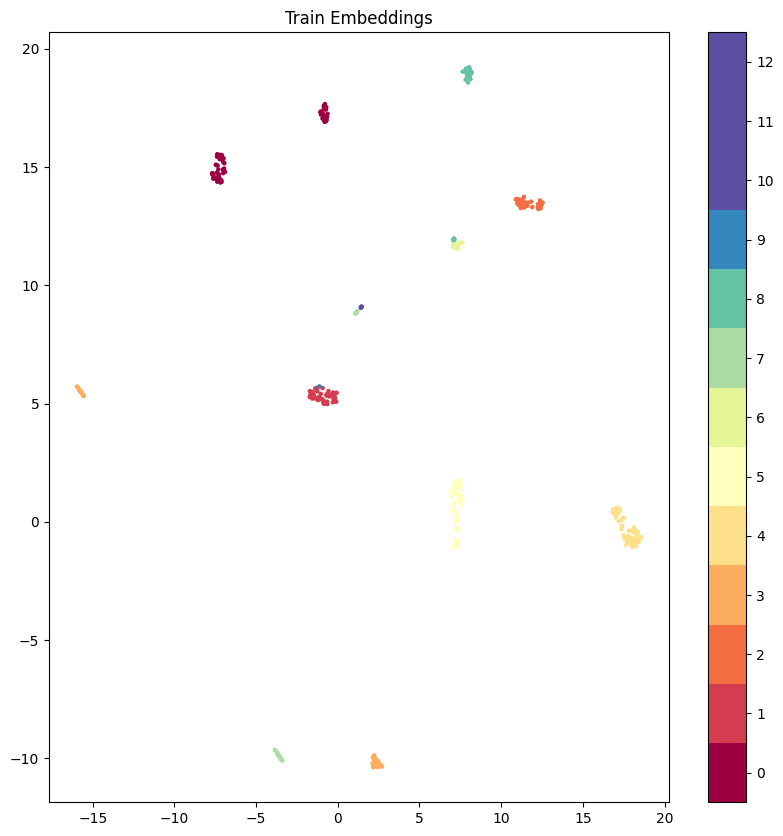

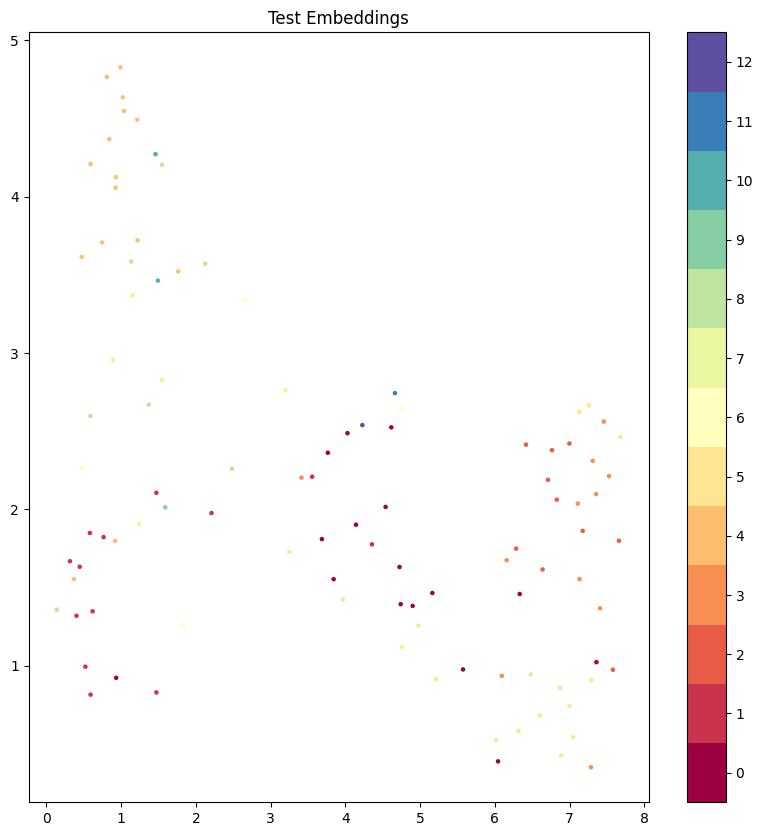

Epoch 32: Average Loss = 0.021939152851700783


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  5.88it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5841584158415841
Test set accuracy (r_precision) = 0.5166925778363417


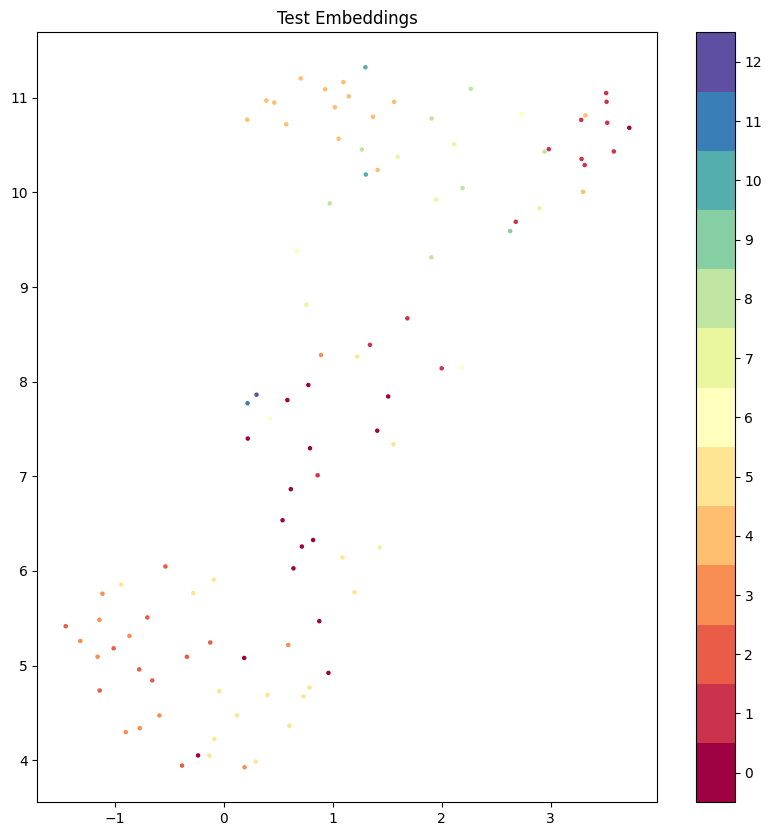

Epoch 33: Average Loss = 0.0041136667132377625


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 12/12 [00:02<00:00,  7.31it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.42it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.594059405940594
Test set accuracy (r_precision) = 0.5179928492487751


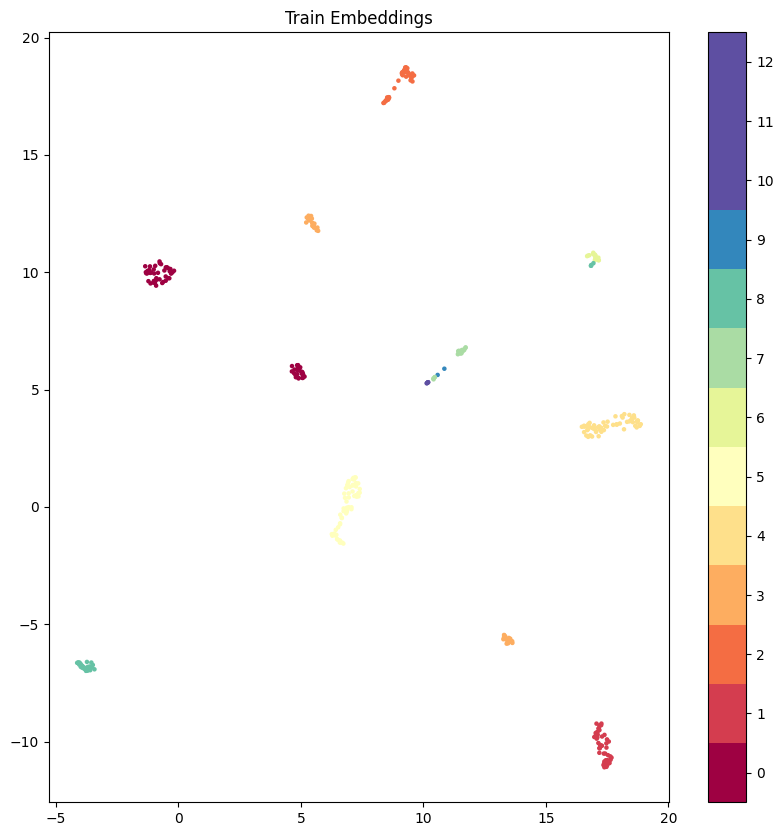

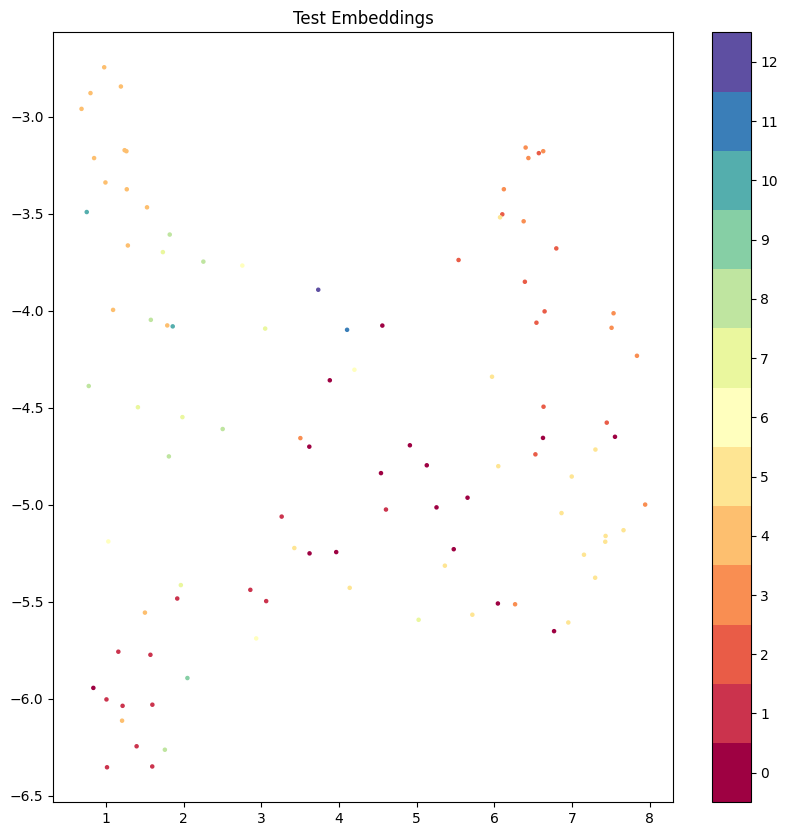

Epoch 34: Average Loss = 0.008326821029186249


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 12/12 [00:02<00:00,  6.71it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.42it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5841584158415841
Test set accuracy (r_precision) = 0.5174032752244276


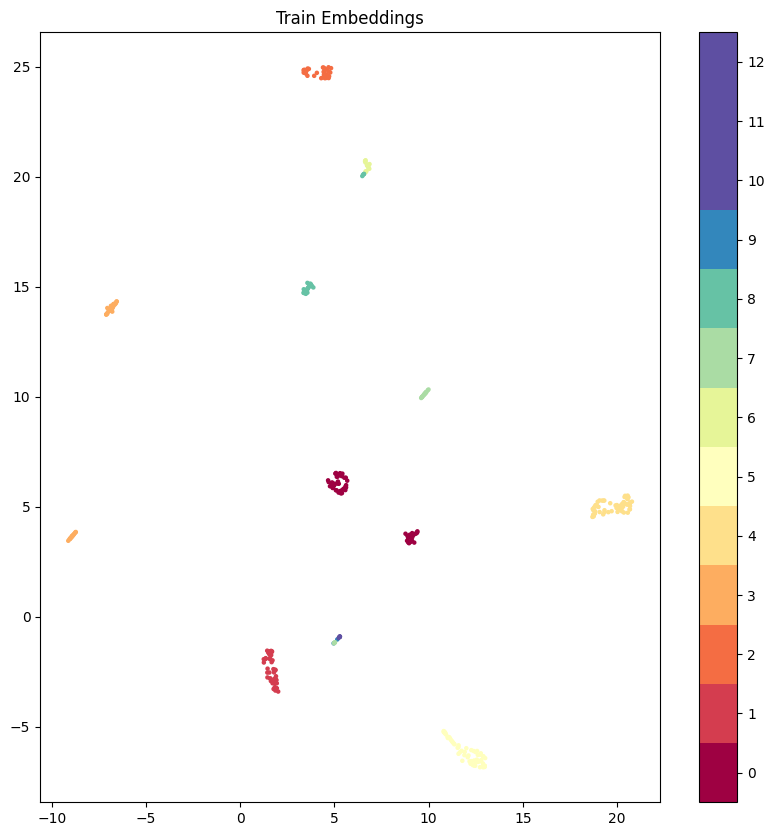

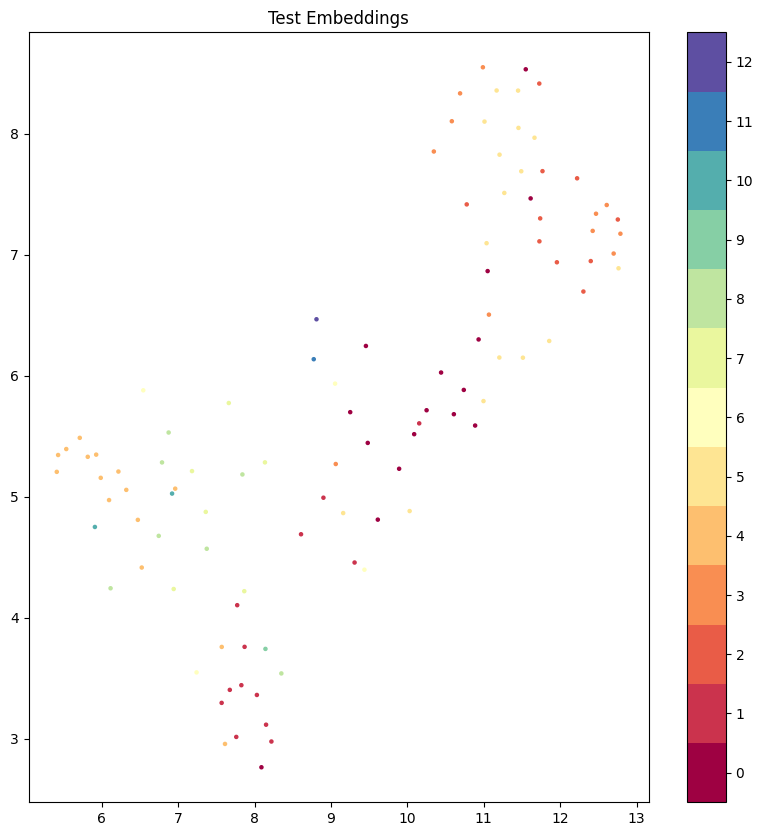

Epoch 35: Average Loss = 0.012351213954389095


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.38it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5841584158415841
Test set accuracy (r_precision) = 0.5158652441641387


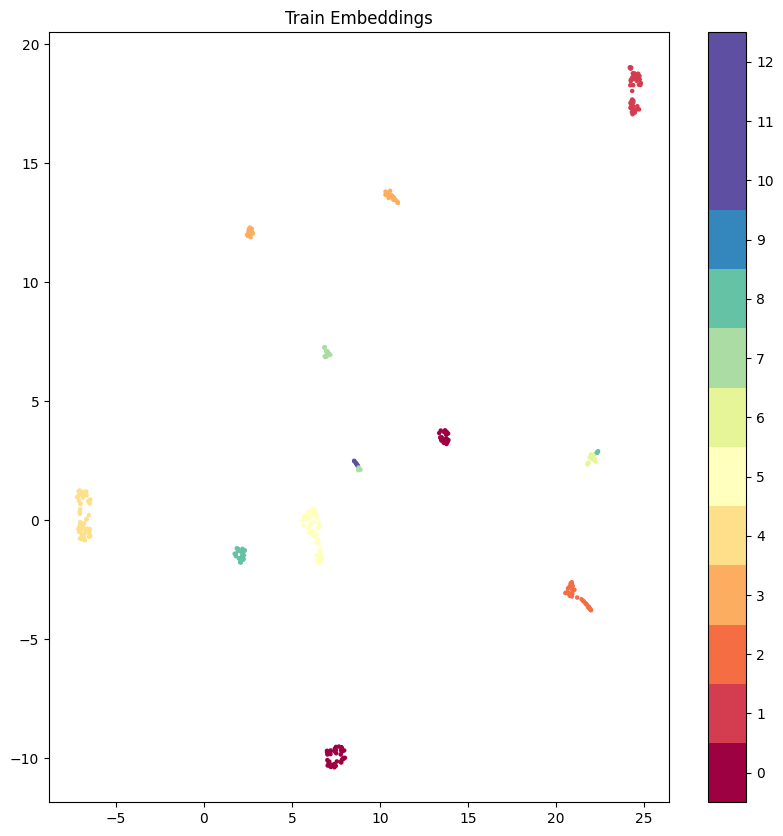

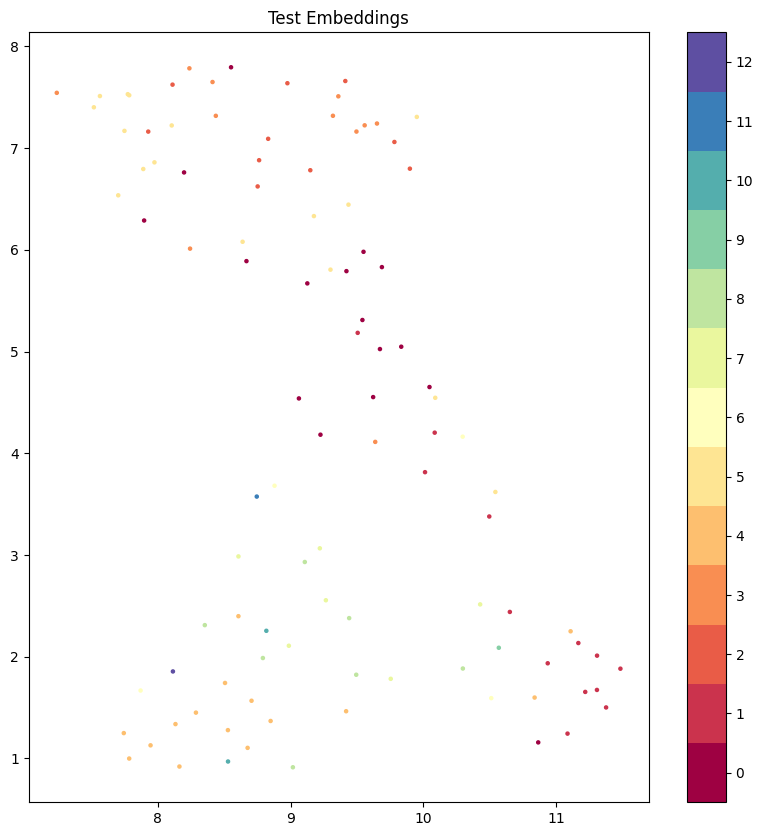

Epoch 36: Average Loss = 0.032779550179839134


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  6.38it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.42it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.594059405940594
Test set accuracy (r_precision) = 0.5157373808272783


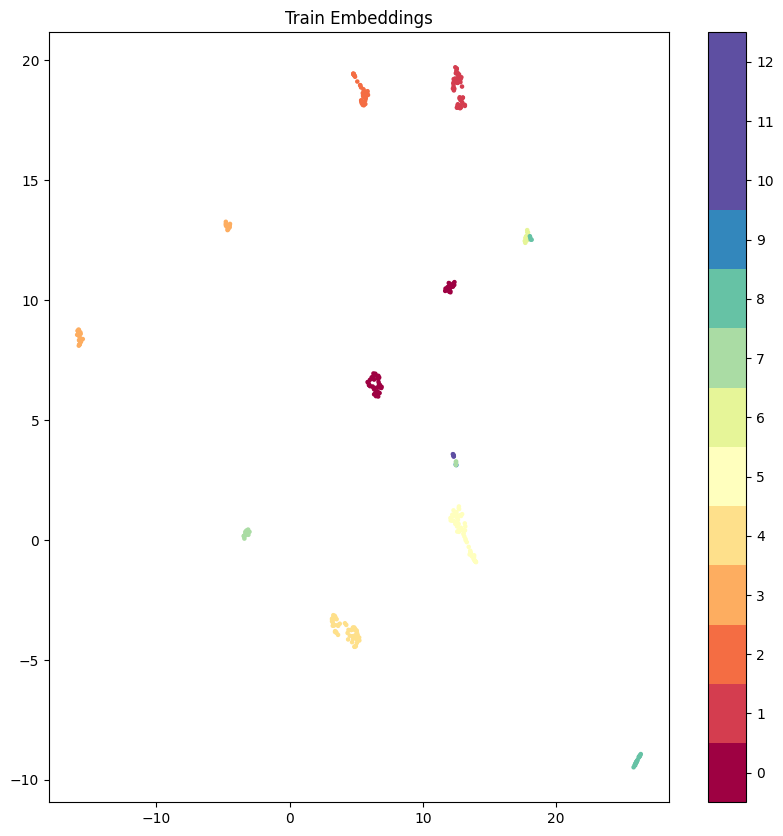

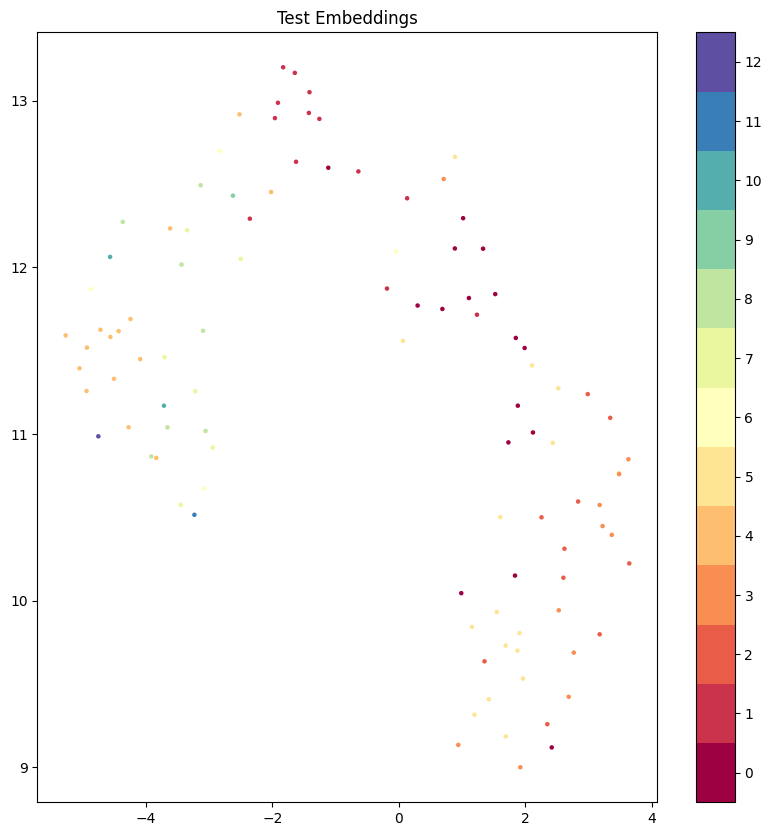

Epoch 37: Average Loss = 0.0053749410435557365


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  6.68it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5742574257425742
Test set accuracy (r_precision) = 0.5134505060465171


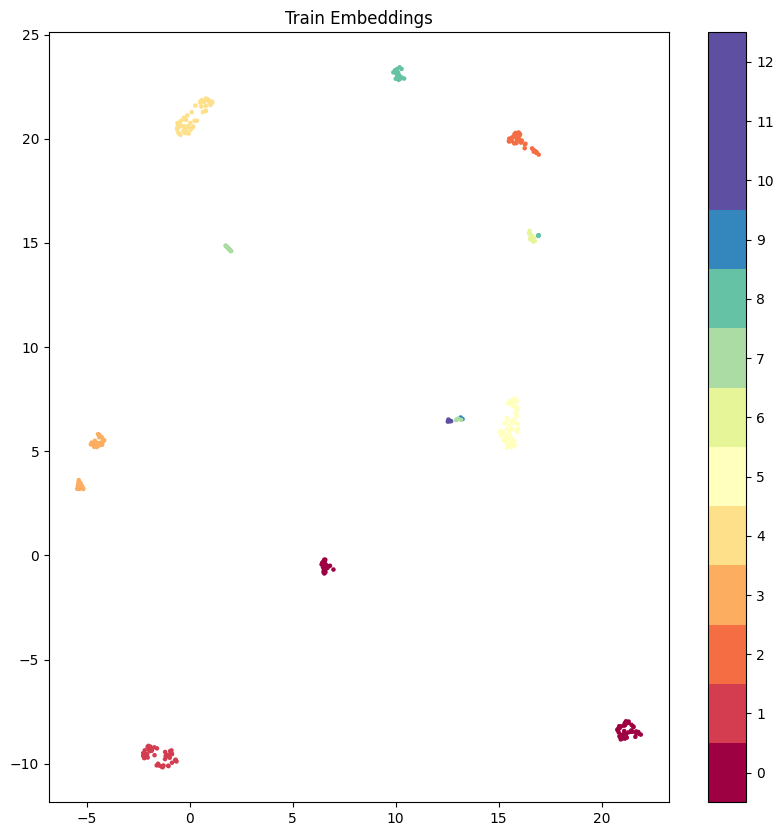

Epoch 38: Average Loss = 0.03146641980856657


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:01<00:00,  6.48it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5742574257425742
Test set accuracy (r_precision) = 0.5183351691611428


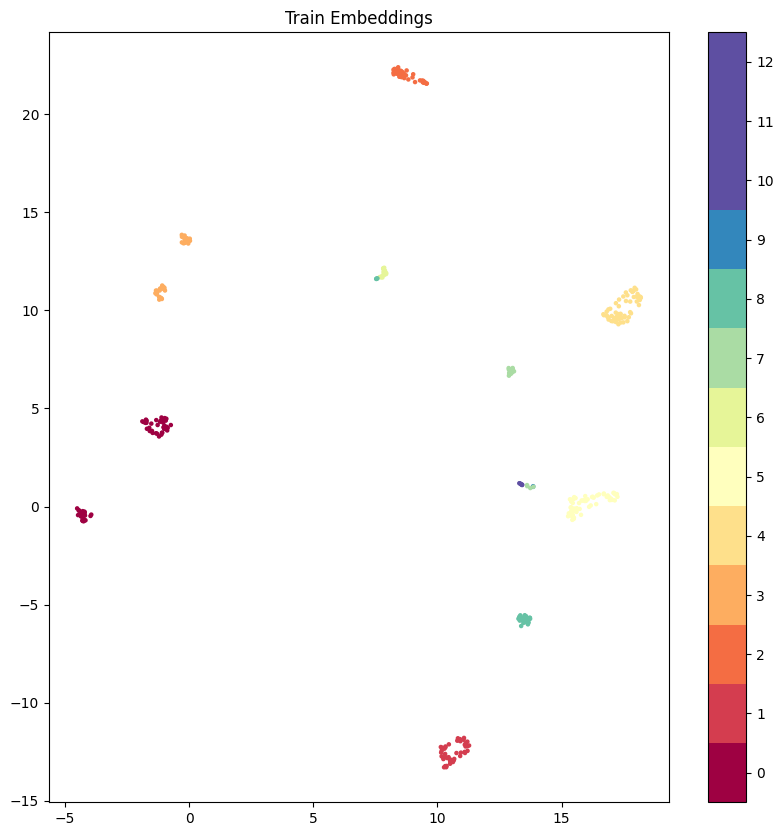

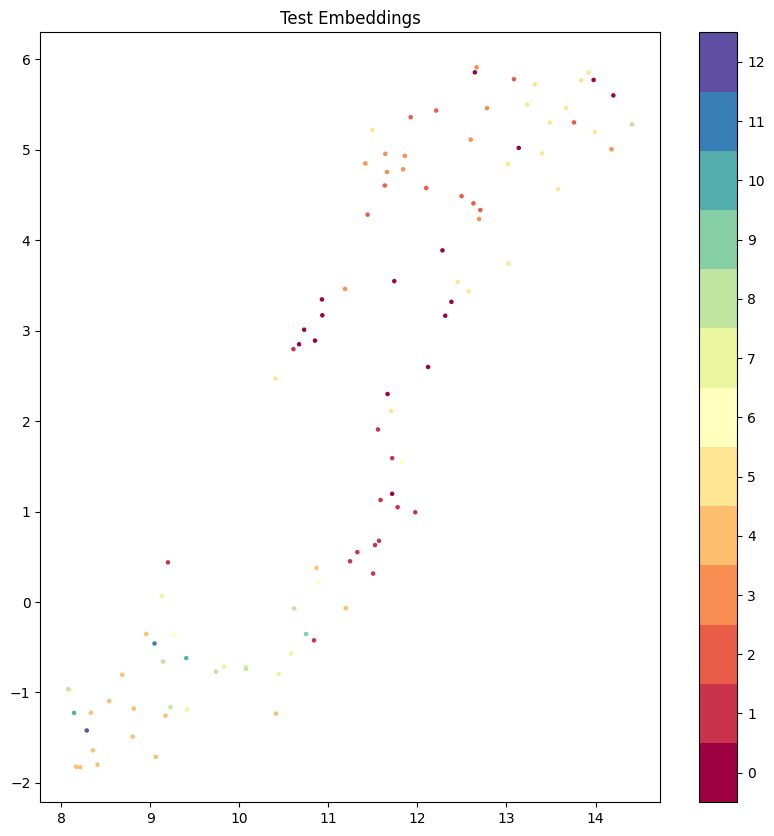

Epoch 39: Average Loss = 0.023260733112692833


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  6.15it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.40it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5643564356435644
Test set accuracy (r_precision) = 0.5192321802436761


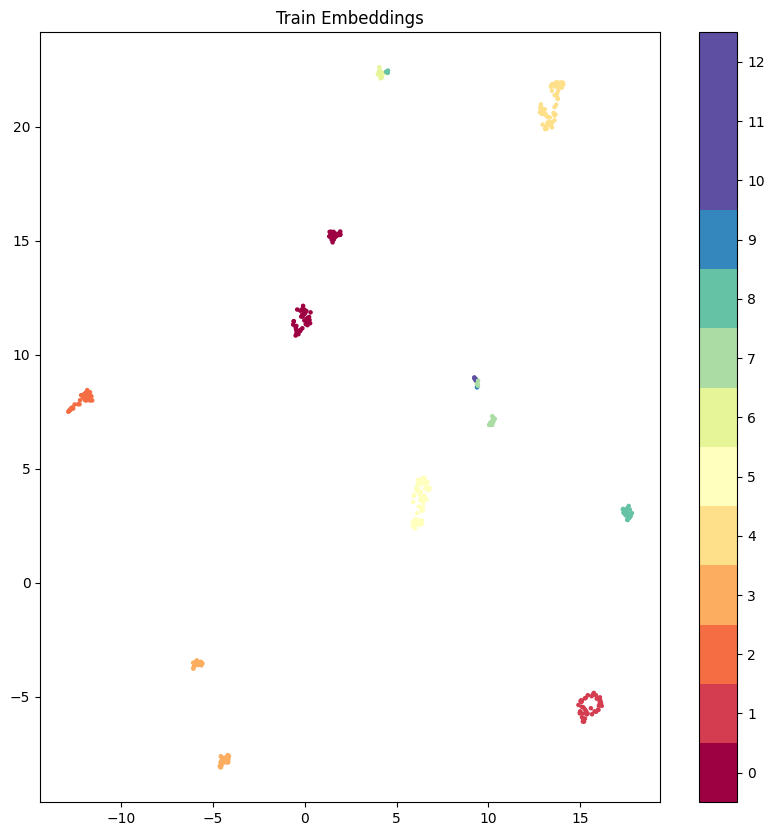

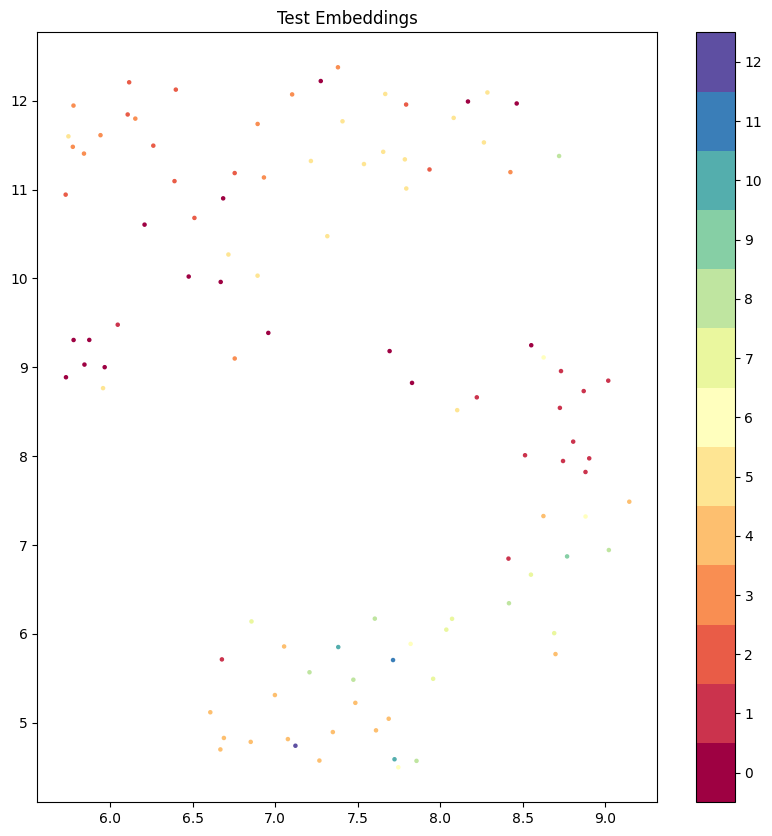

Epoch 40: Average Loss = 0.031901974231004715


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 12/12 [00:02<00:00,  7.08it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.53it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5742574257425742
Test set accuracy (r_precision) = 0.5241581100102658


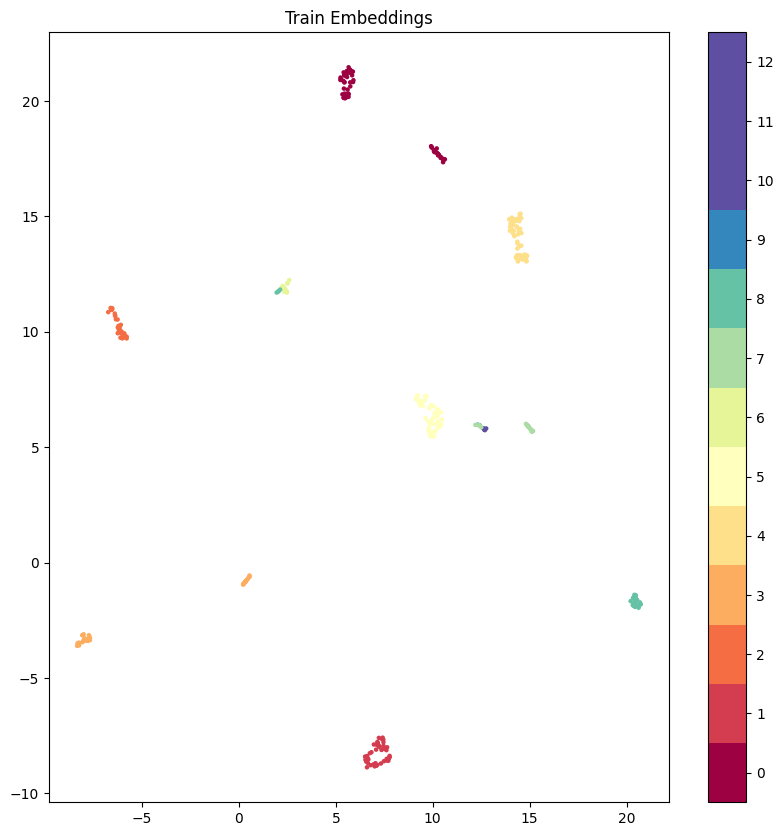

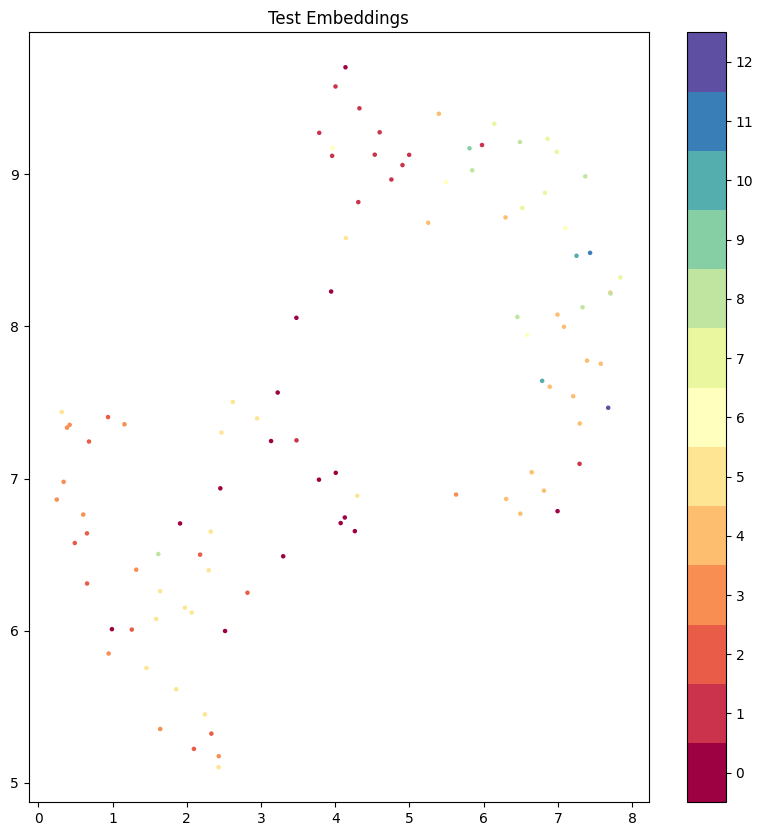

Epoch 41: Average Loss = 0.013834266923367977


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  6.06it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.594059405940594
Test set accuracy (r_precision) = 0.5302855983703119


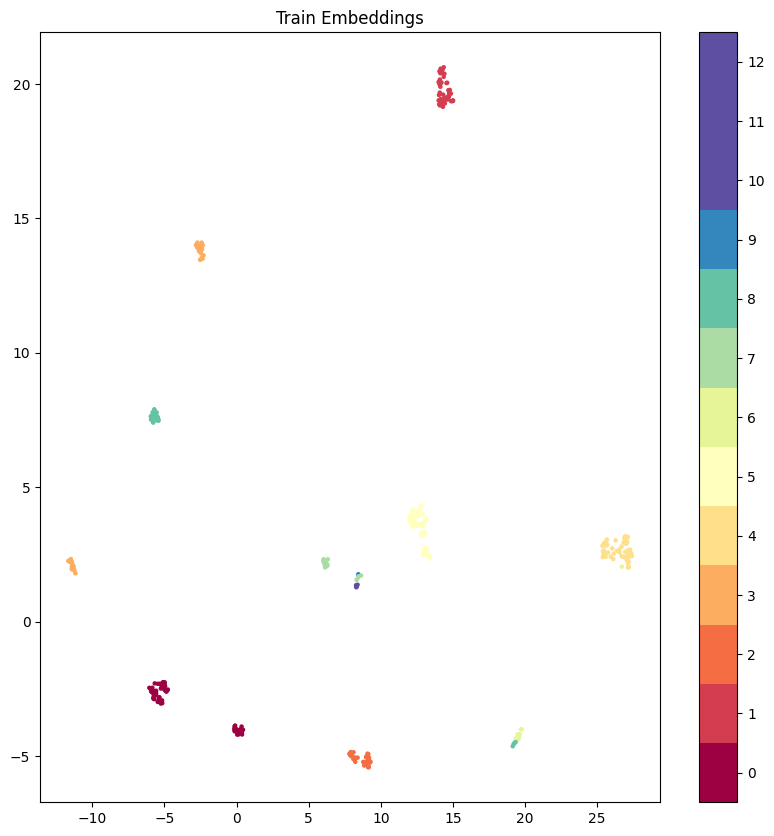

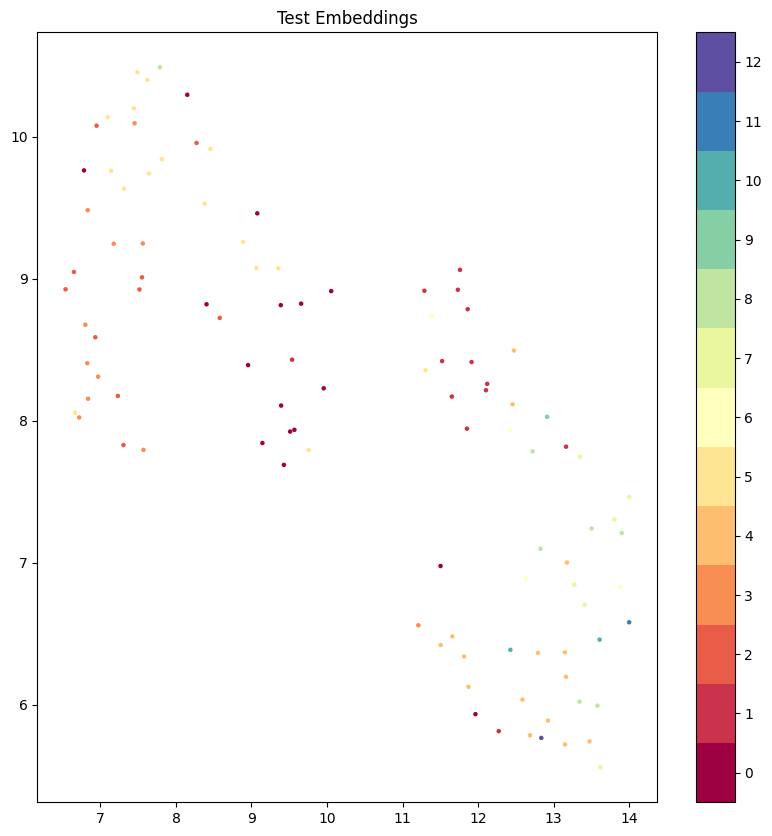

Epoch 42: Average Loss = 0.016861104406416416


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  5.88it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6138613861386139
Test set accuracy (r_precision) = 0.5343087678774586


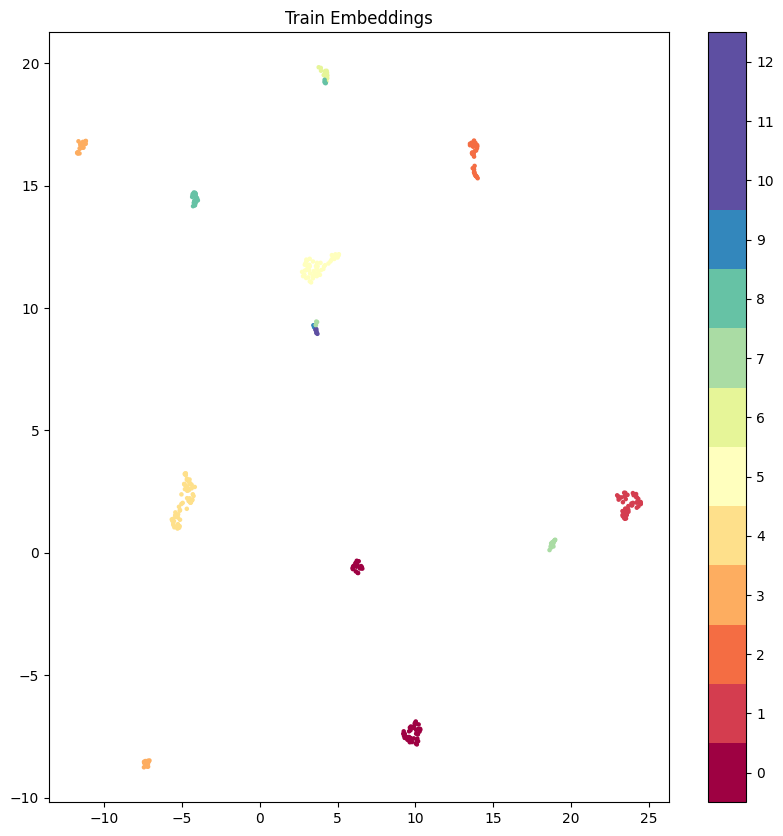

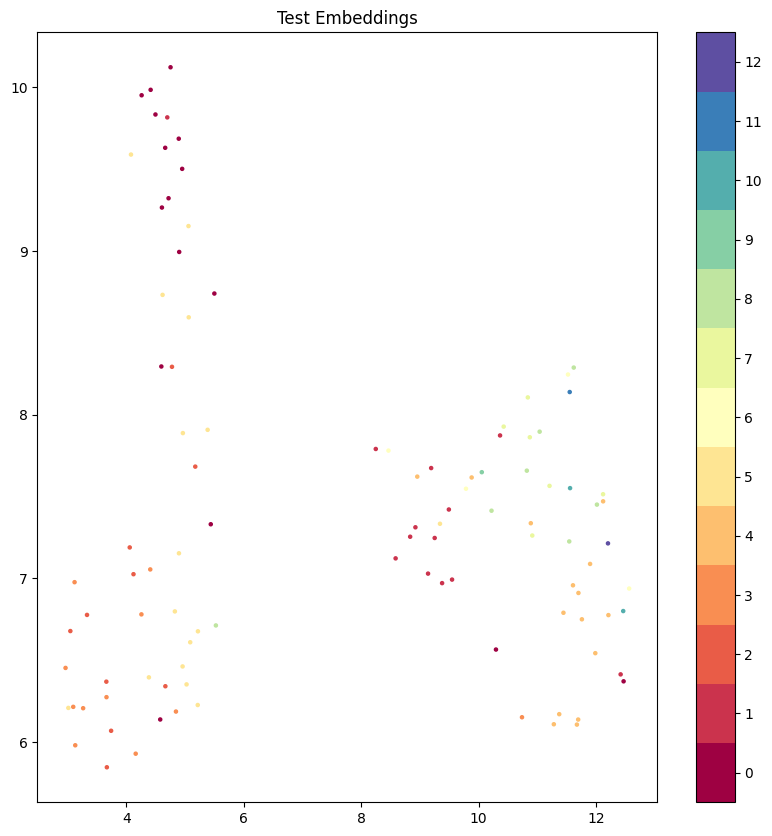

Epoch 43: Average Loss = 0.011009765788912773


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 12/12 [00:02<00:00,  7.36it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5742574257425742
Test set accuracy (r_precision) = 0.5383903917939589


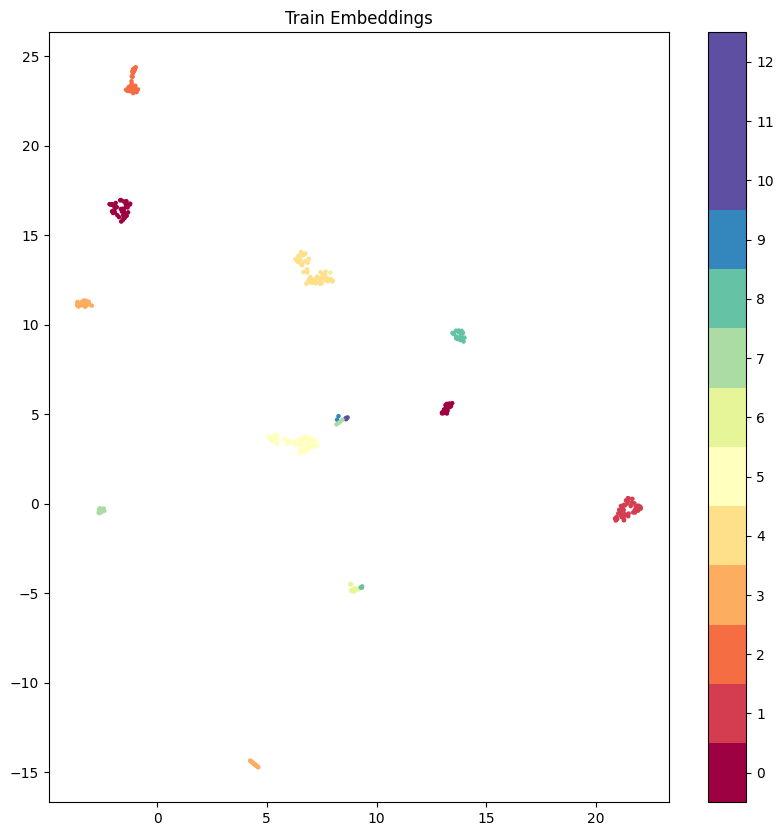

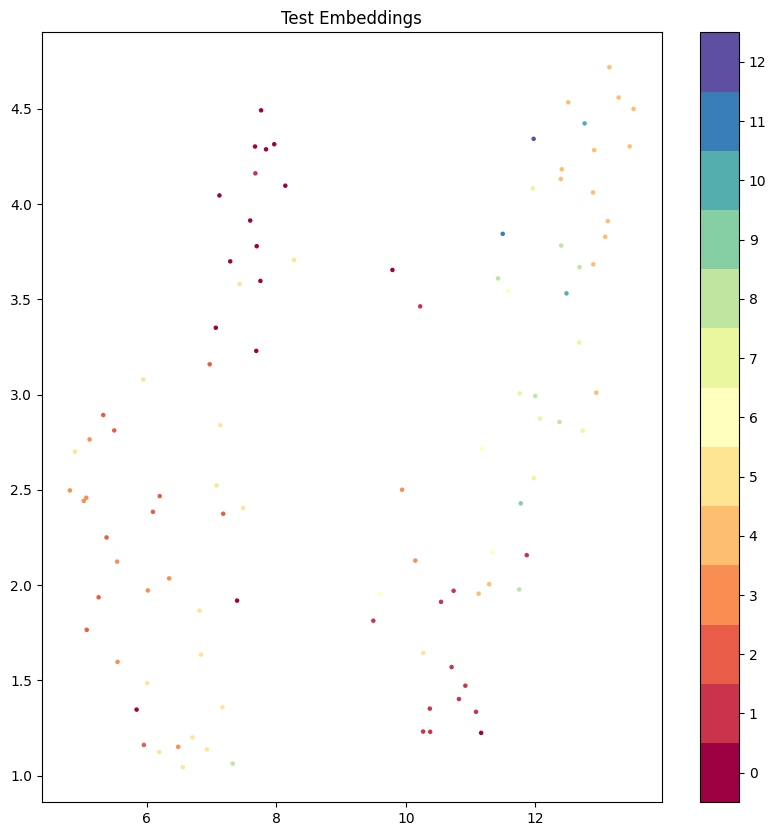

Epoch 44: Average Loss = 0.013495586812496185


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  6.16it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5841584158415841
Test set accuracy (r_precision) = 0.5405690061494793


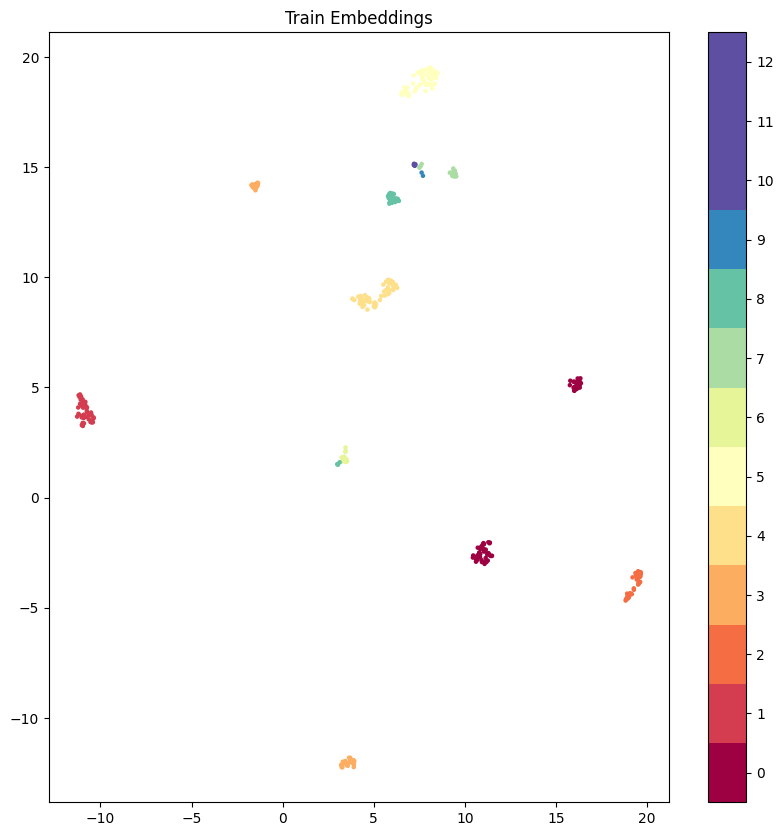

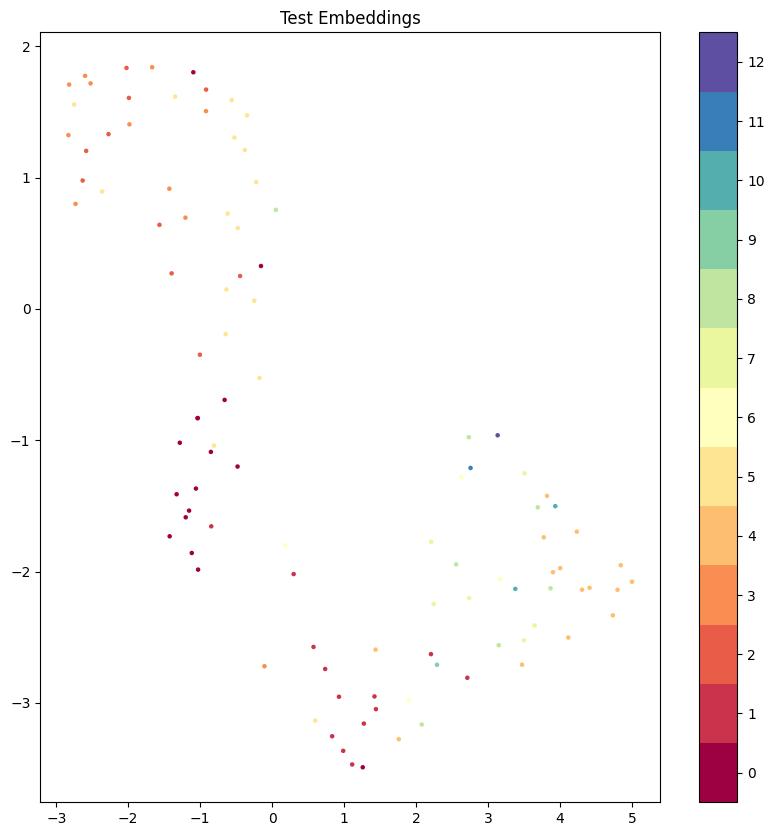

Epoch 45: Average Loss = 0.003315150737762451


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  6.59it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.51it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6039603960396039
Test set accuracy (r_precision) = 0.5332783134883965


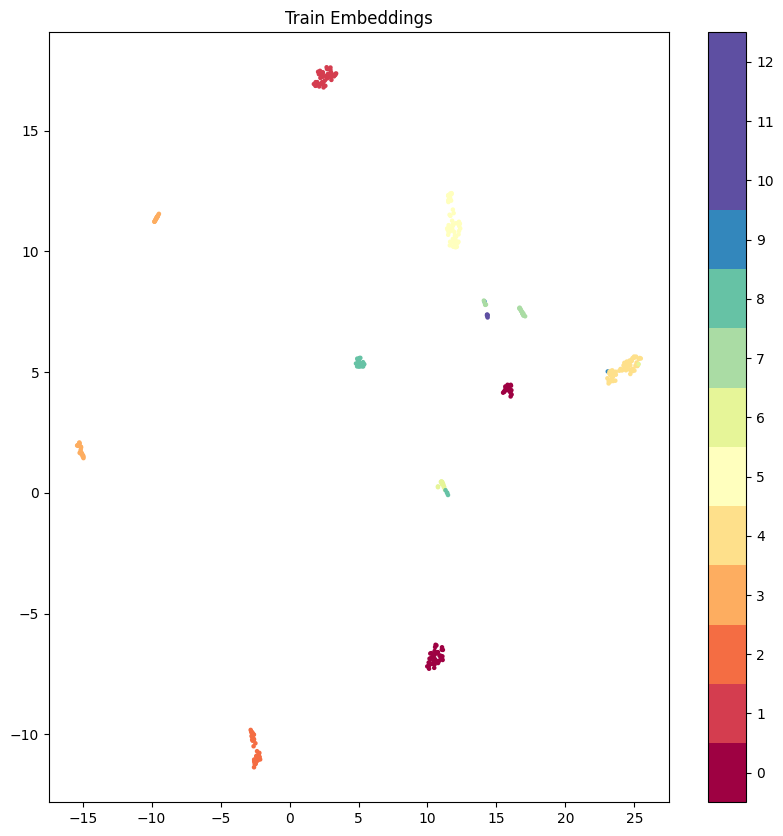

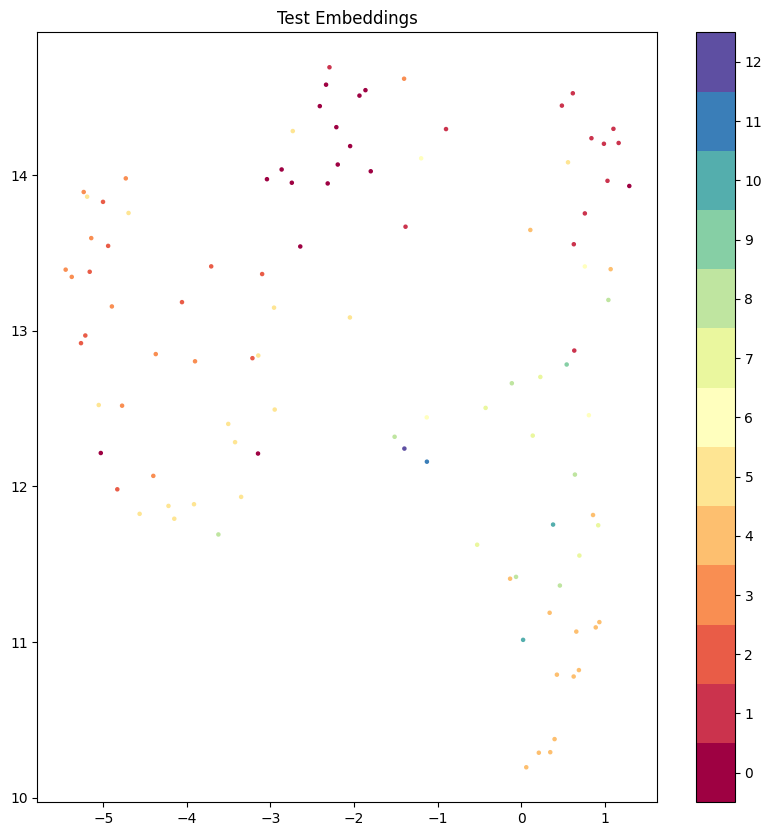

Epoch 46: Average Loss = 0.018321121111512184


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 12/12 [00:02<00:00,  7.37it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.52it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5841584158415841
Test set accuracy (r_precision) = 0.523407068025658


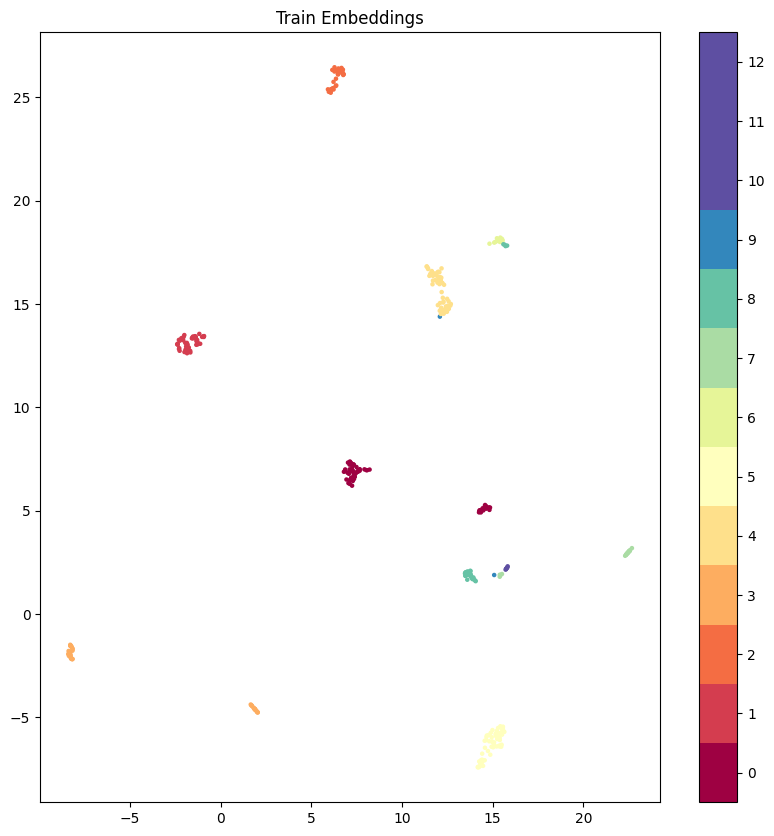

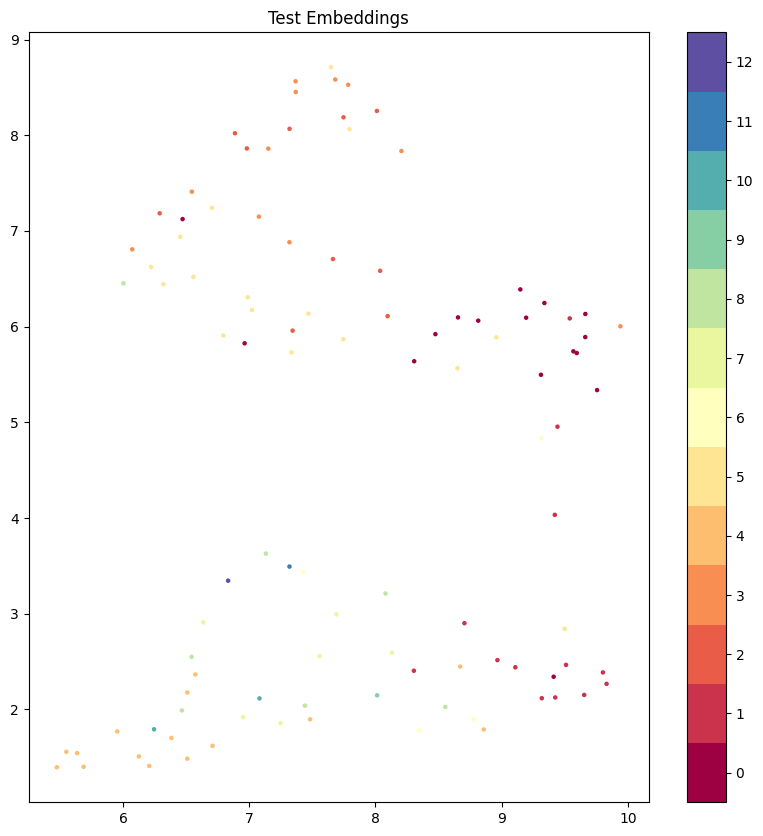

Epoch 47: Average Loss = 0.04447870887815952


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  6.05it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5841584158415841
Test set accuracy (r_precision) = 0.5181185772488403


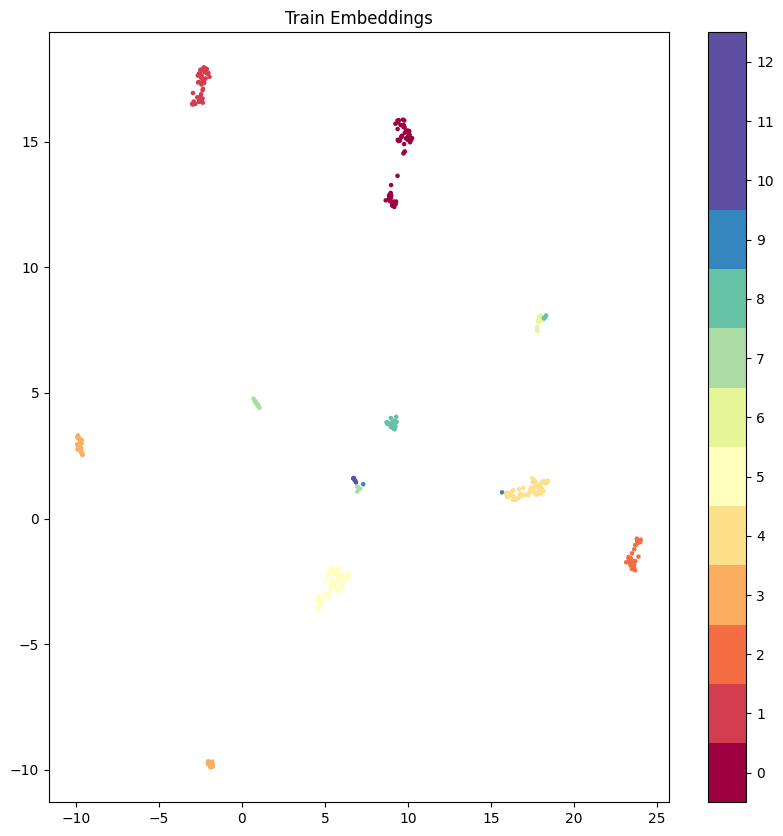

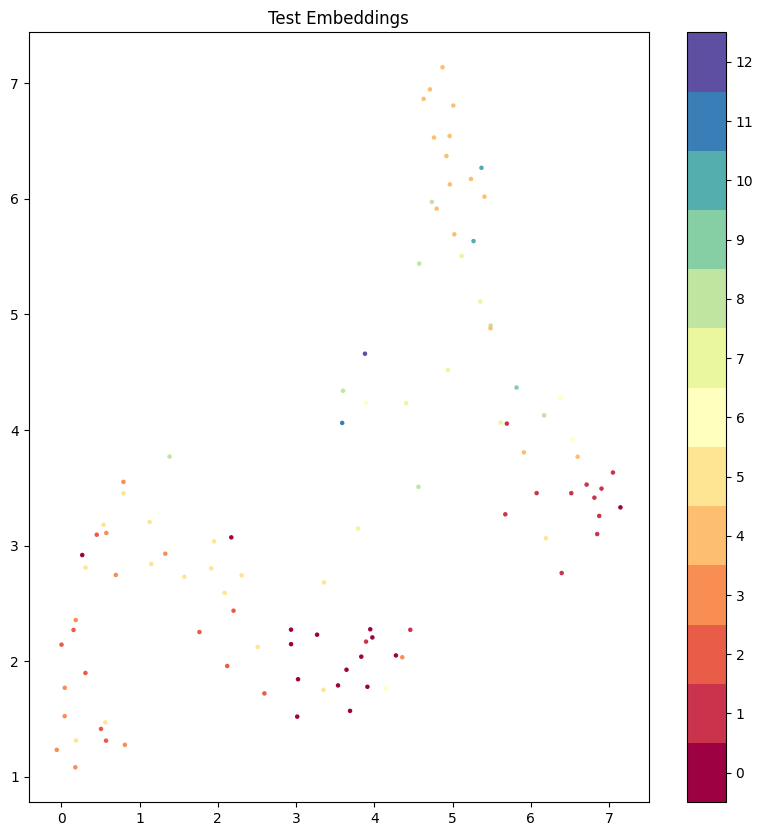

Epoch 48: Average Loss = 0.02894001081585884


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 12/12 [00:02<00:00,  5.67it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.84it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5841584158415841
Test set accuracy (r_precision) = 0.516262015822708


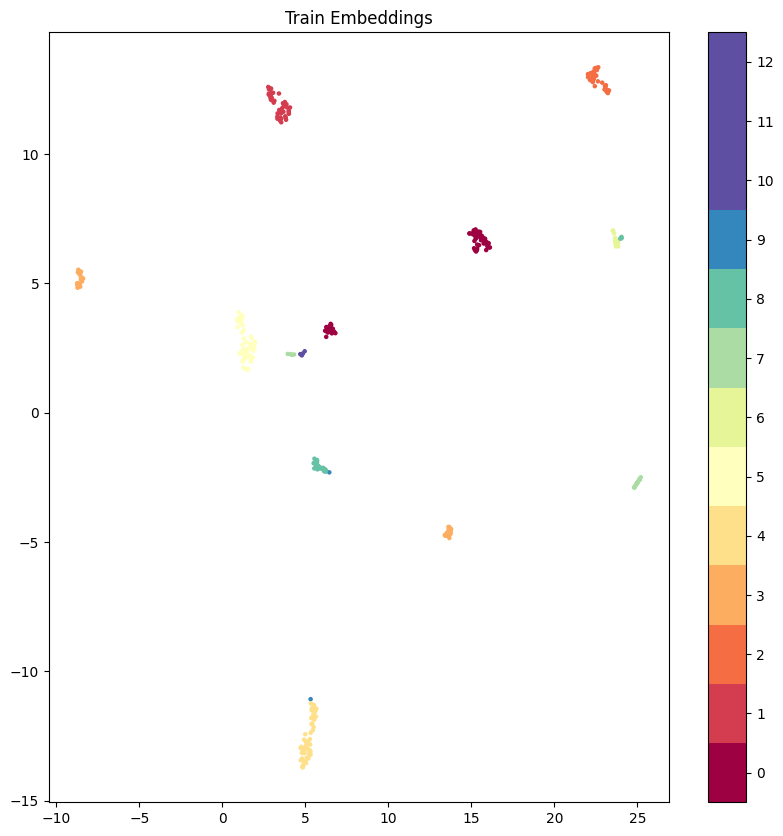

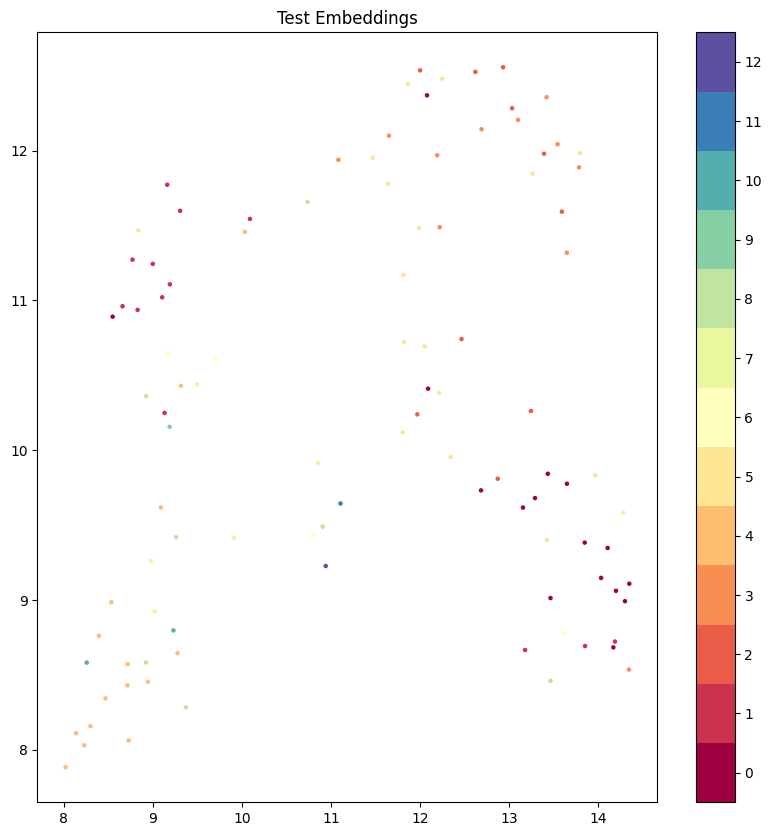

Epoch 49: Average Loss = 0.015891991555690765


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 12/12 [00:02<00:00,  5.00it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.08it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5841584158415841
Test set accuracy (r_precision) = 0.5315903887889334


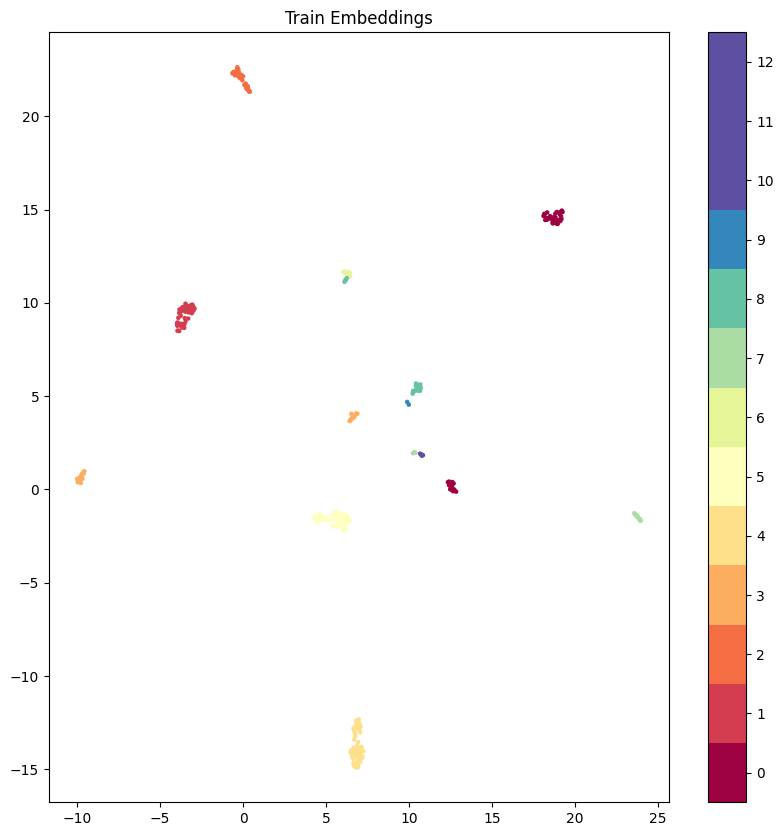

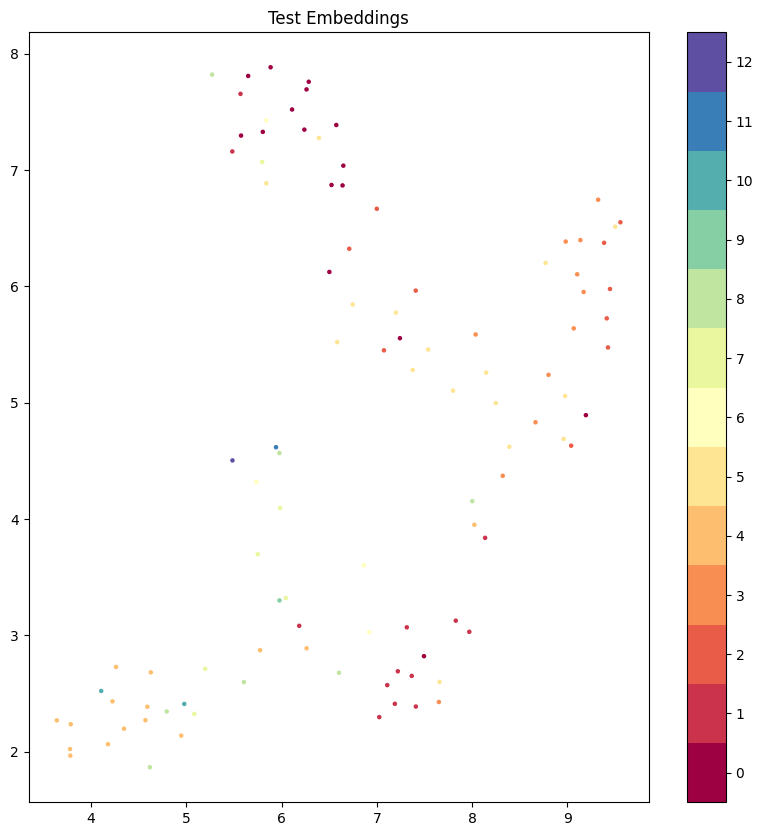

Epoch 50: Average Loss = 0.02952897921204567


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 12/12 [00:02<00:00,  5.65it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5742574257425742
Test set accuracy (r_precision) = 0.5237129231434008


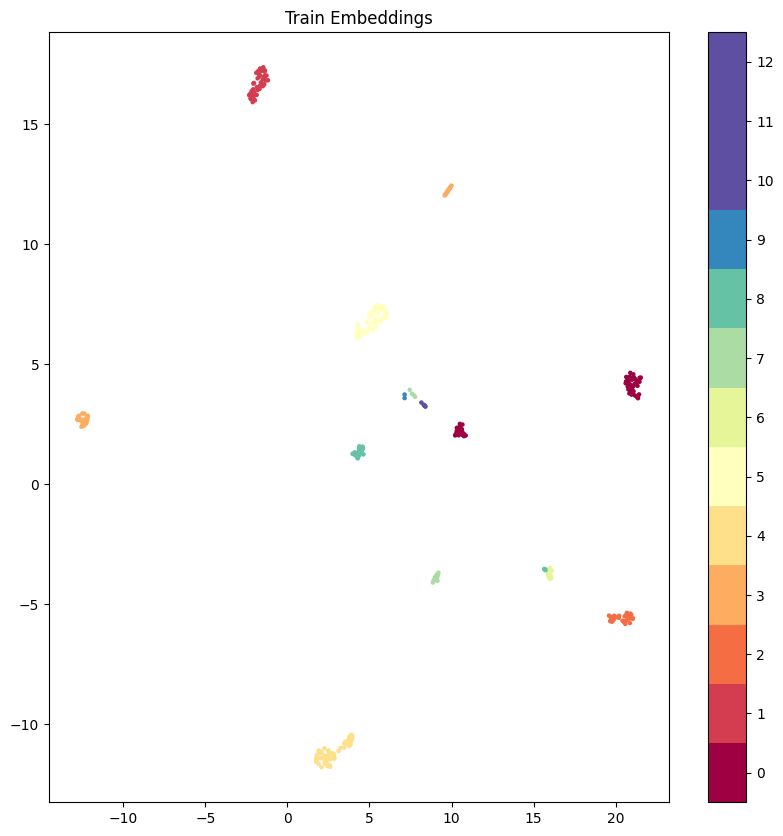

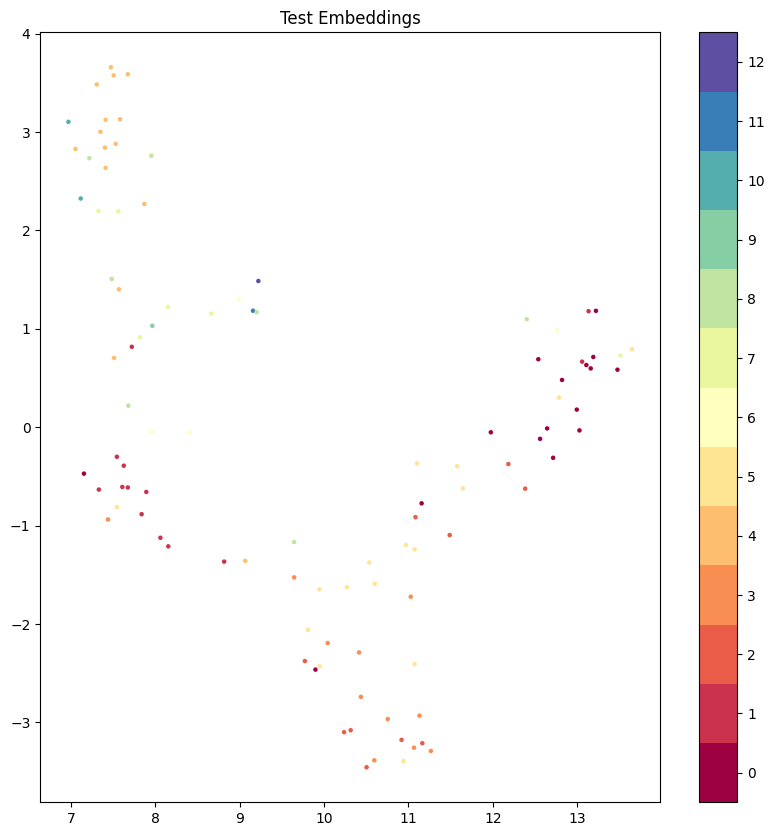

Epoch 51: Average Loss = 0.025566783733665943


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  6.22it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5445544554455446
Test set accuracy (r_precision) = 0.5205644586864241


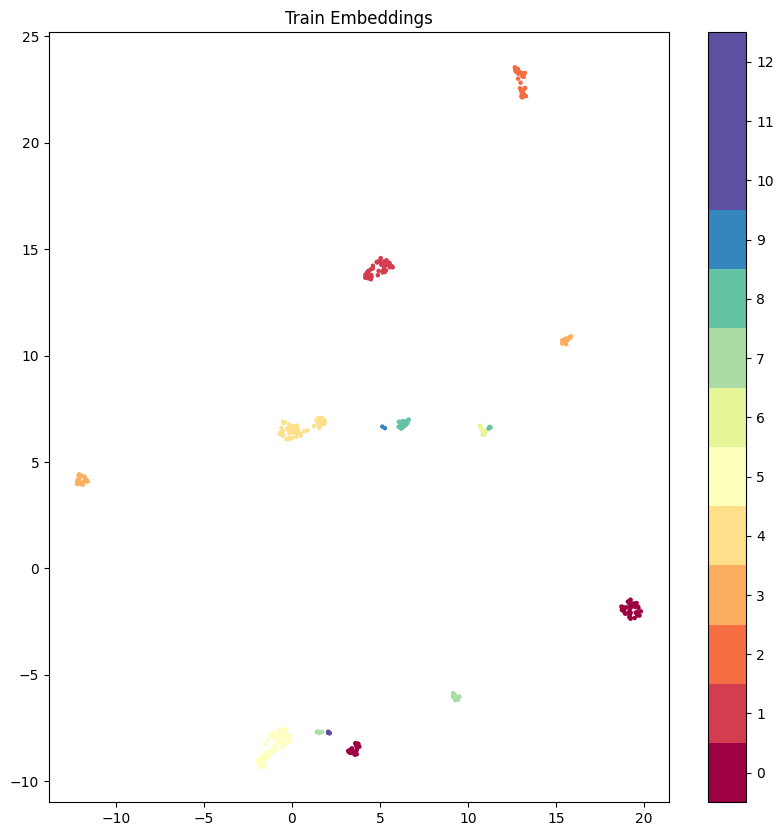

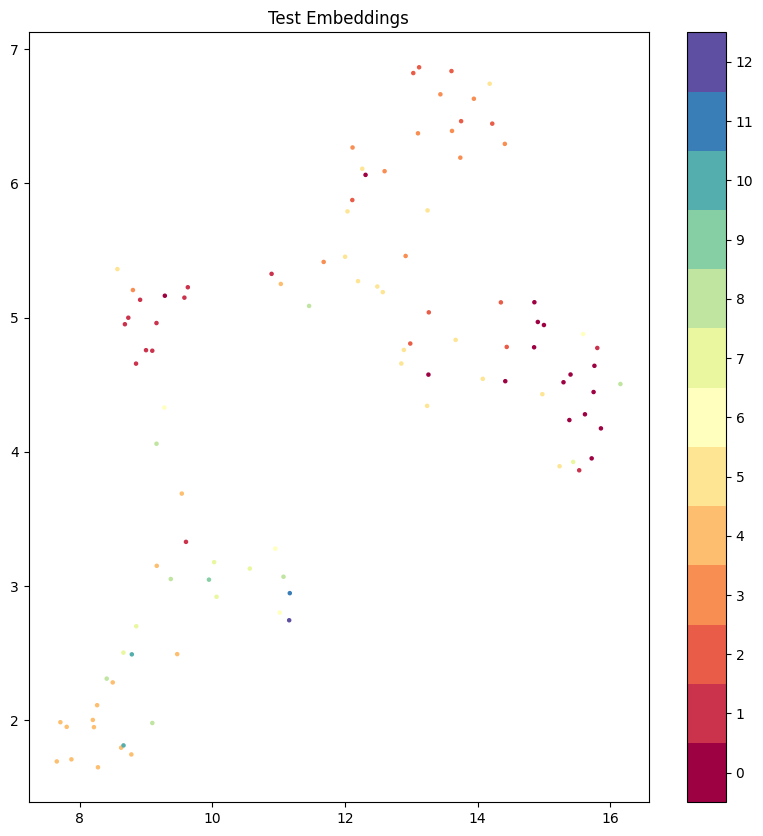

Epoch 52: Average Loss = 0.01835218071937561


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  6.47it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5247524752475248
Test set accuracy (r_precision) = 0.5209102494677152


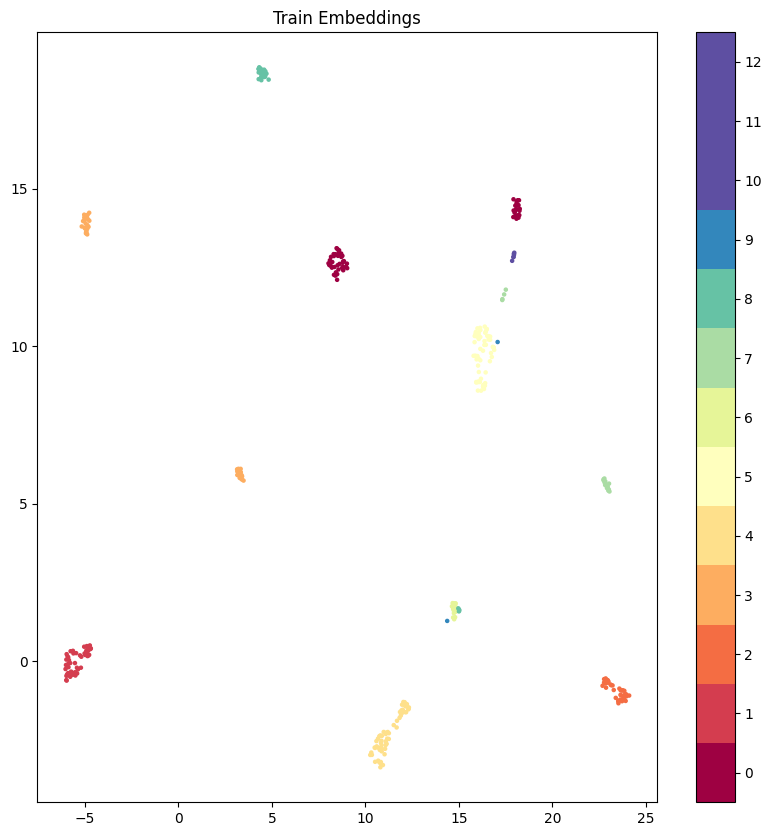

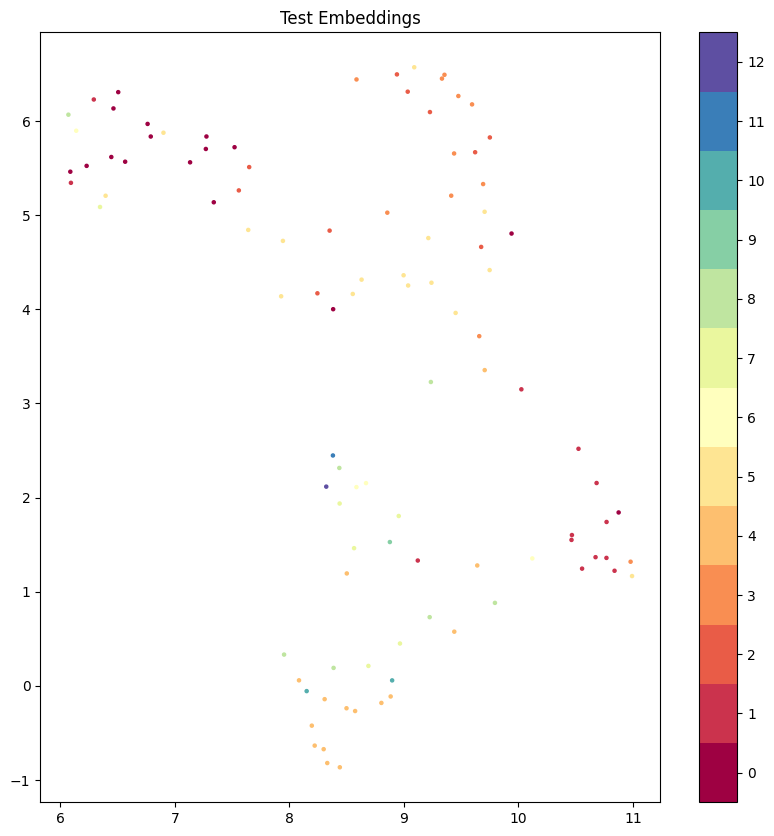

Epoch 53: Average Loss = 0.011833176016807556


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 12/12 [00:02<00:00,  6.81it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.43it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5445544554455446
Test set accuracy (r_precision) = 0.5276598845172827


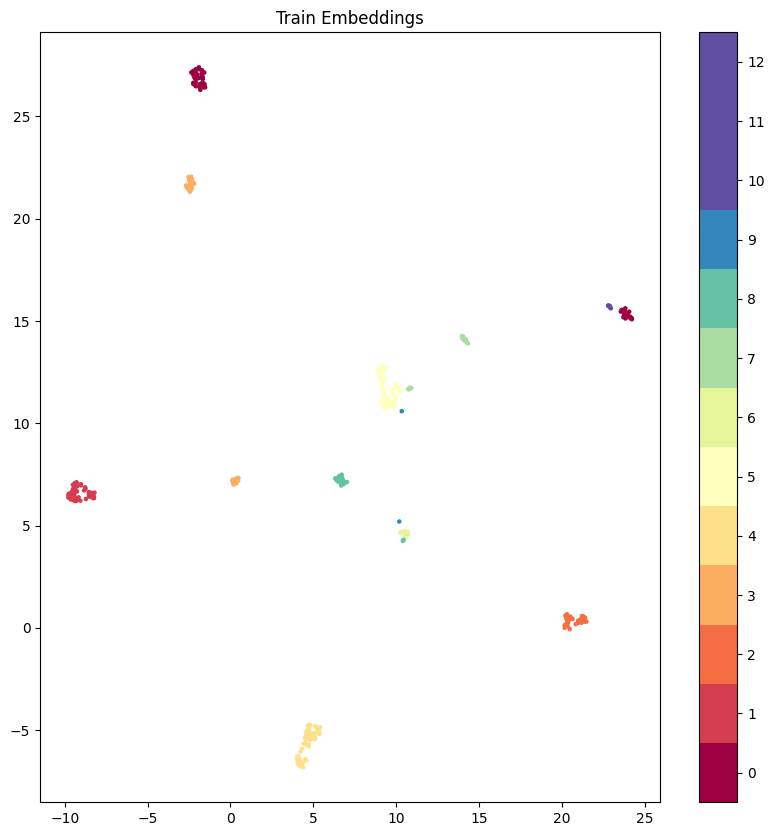

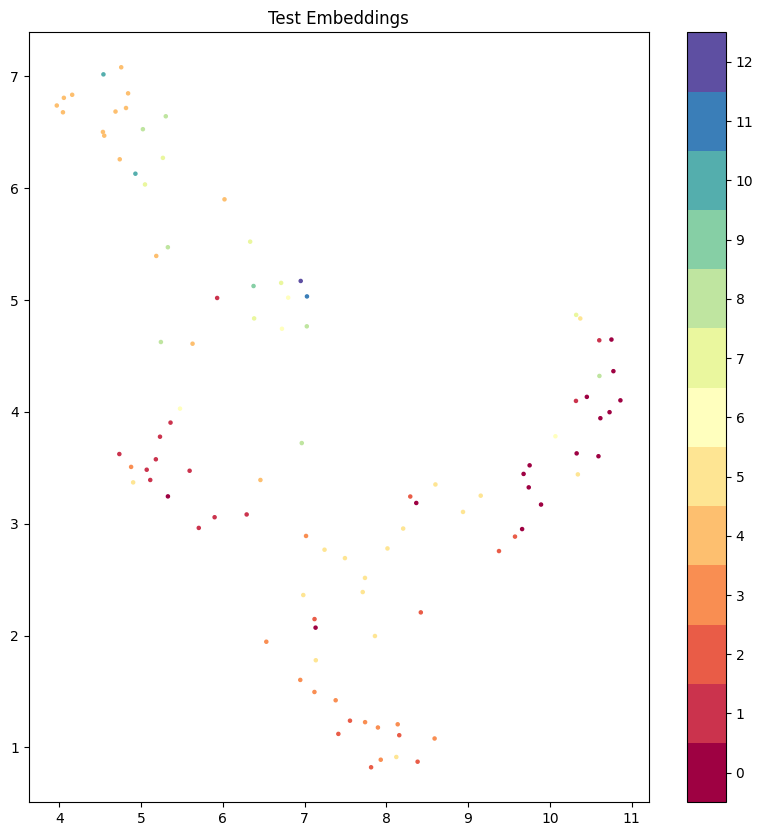

Epoch 54: Average Loss = 0.01151963323354721


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  6.20it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5544554455445545
Test set accuracy (r_precision) = 0.542371463337449


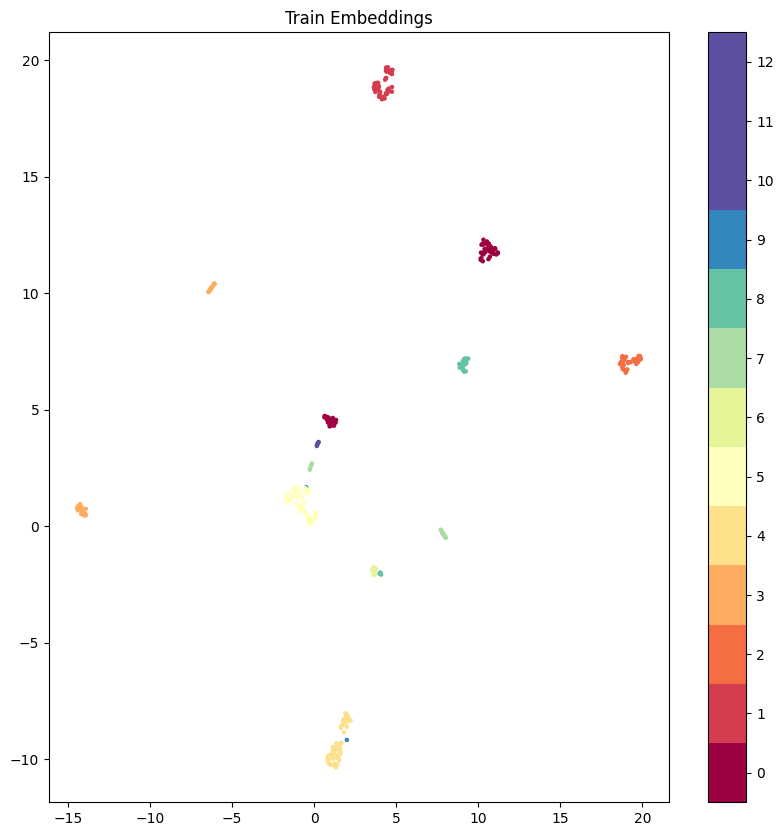

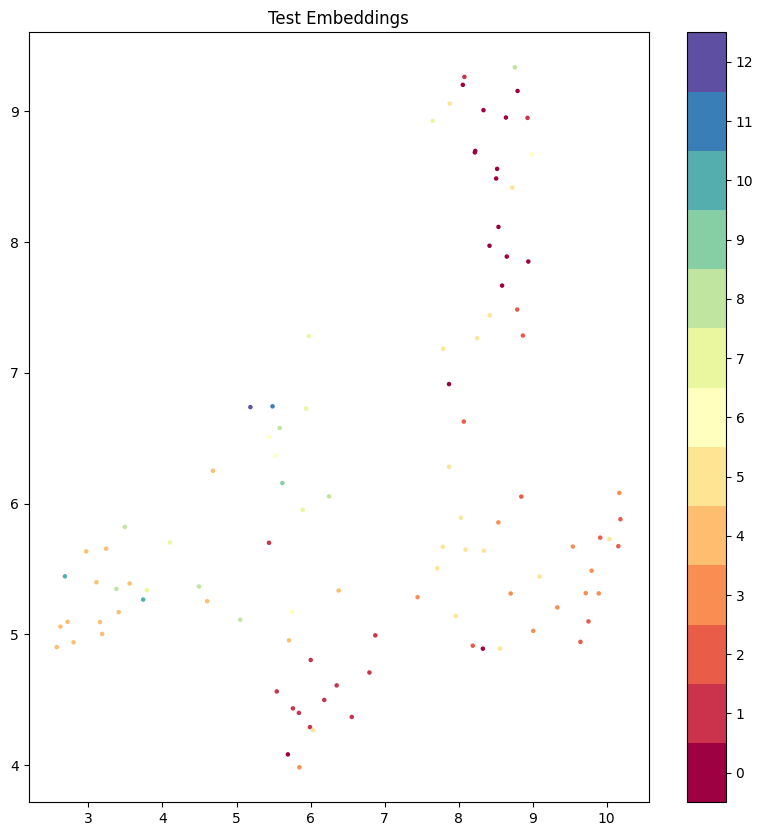

Epoch 55: Average Loss = 0.01236012578010559


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 12/12 [00:02<00:00,  6.98it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5742574257425742
Test set accuracy (r_precision) = 0.5478058050549336


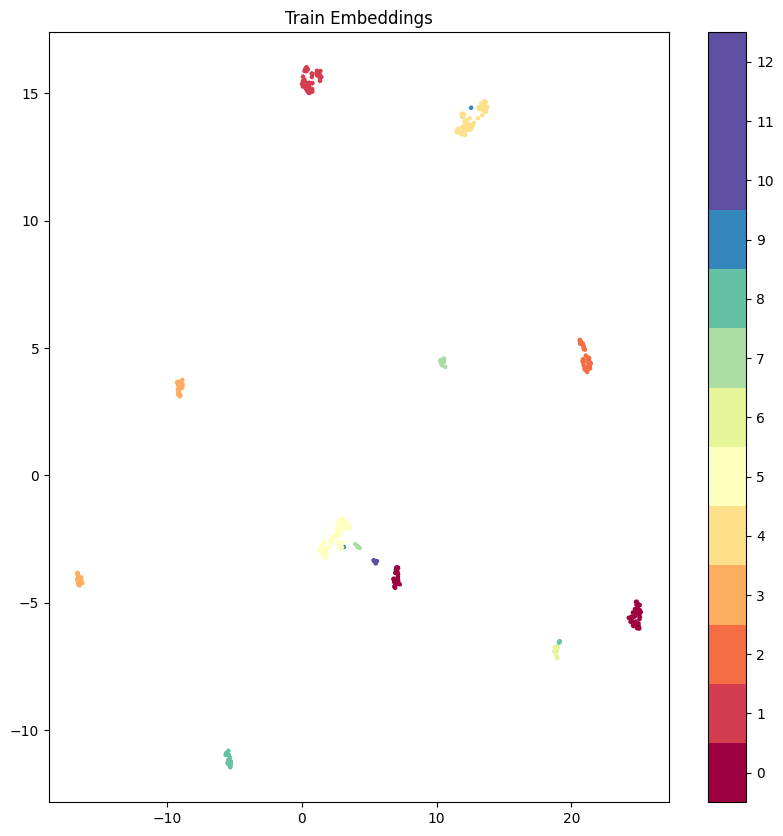

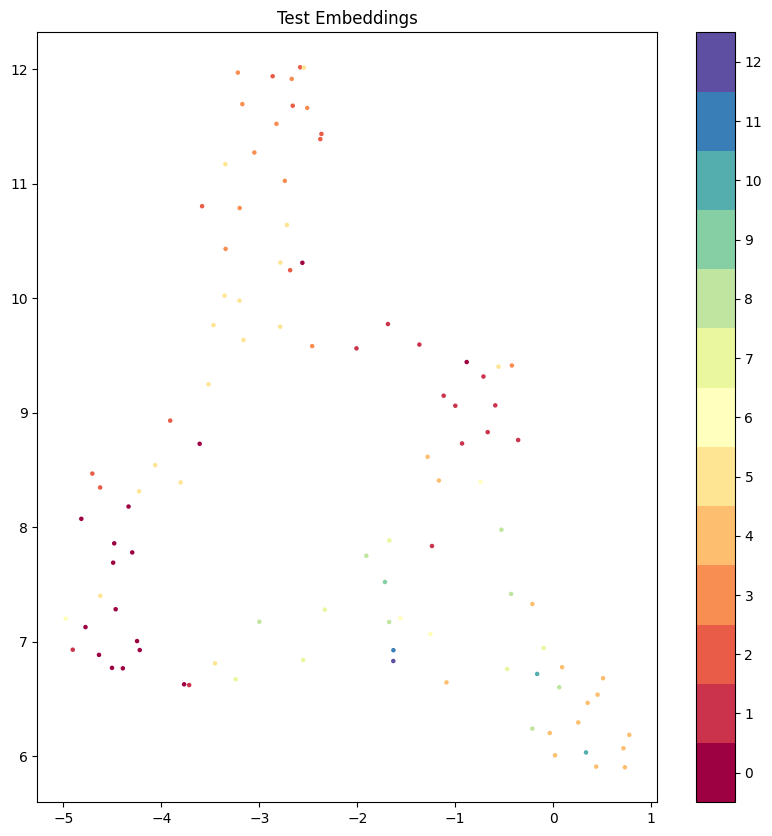

Epoch 56: Average Loss = 0.03234727308154106


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  6.45it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5841584158415841
Test set accuracy (r_precision) = 0.5441222195579972


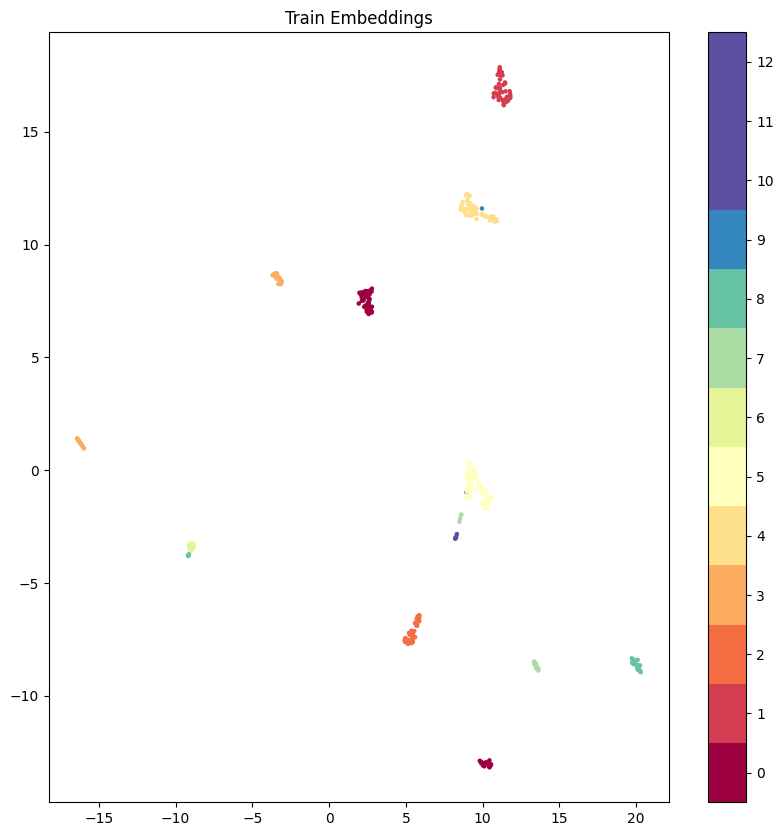

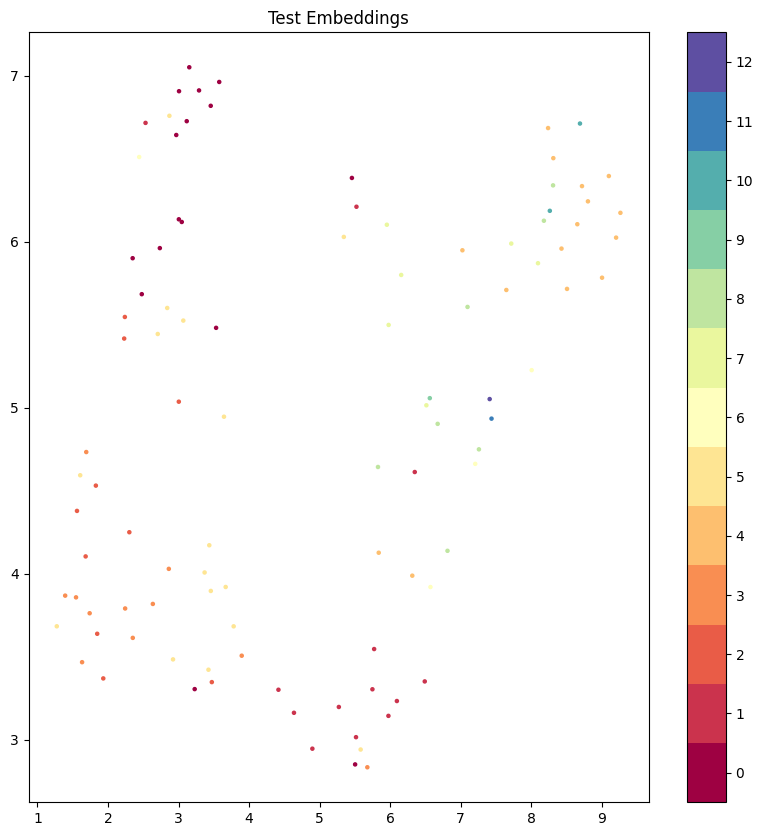

Epoch 57: Average Loss = 0.016921931877732277


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  6.39it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5742574257425742
Test set accuracy (r_precision) = 0.5406056883153424


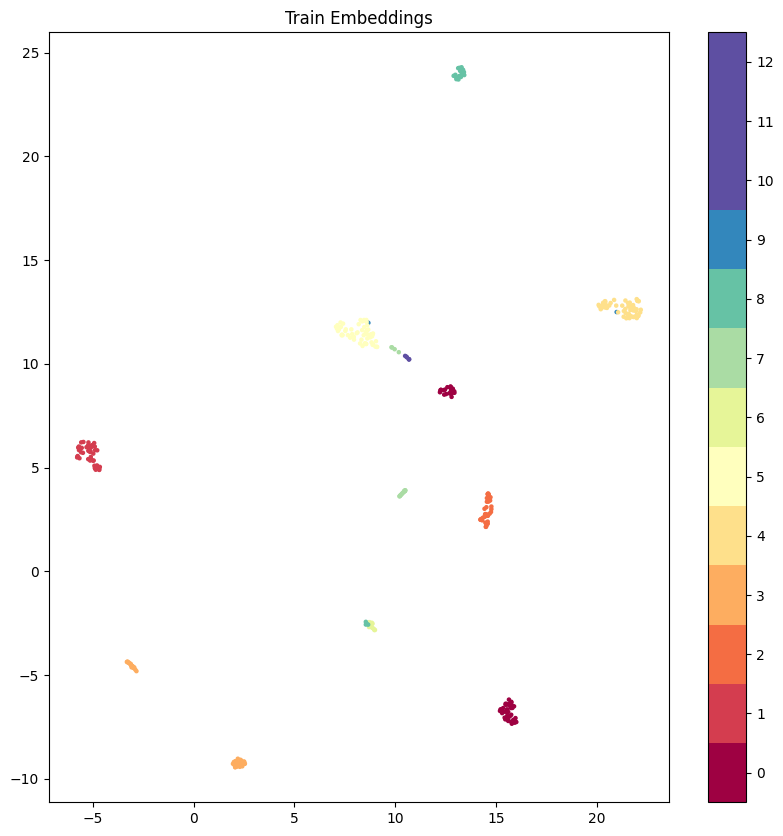

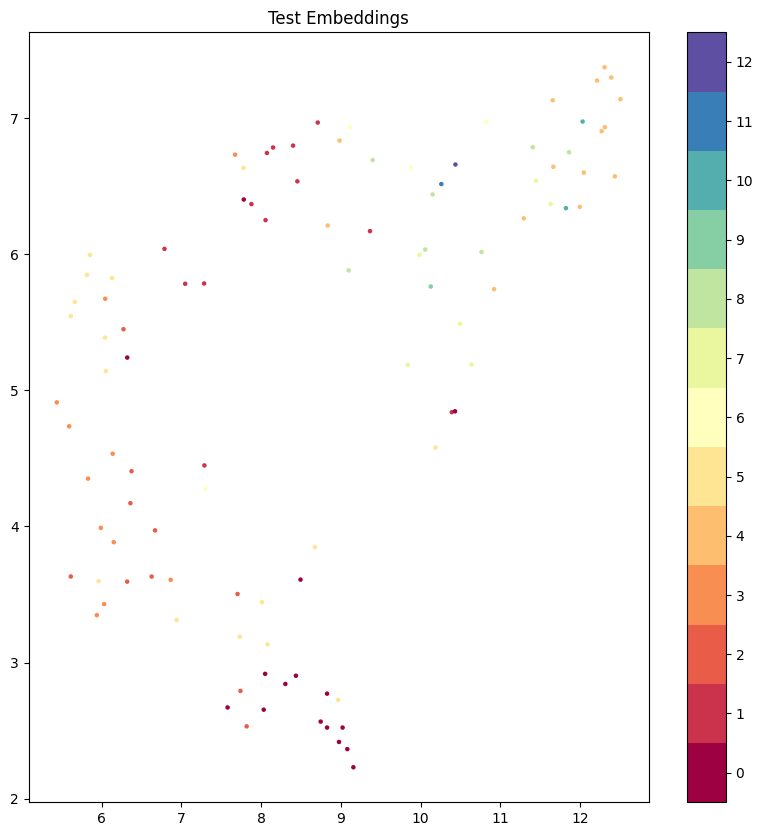

Epoch 58: Average Loss = 0.01581105124205351


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  5.95it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5841584158415841
Test set accuracy (r_precision) = 0.5392658513220288


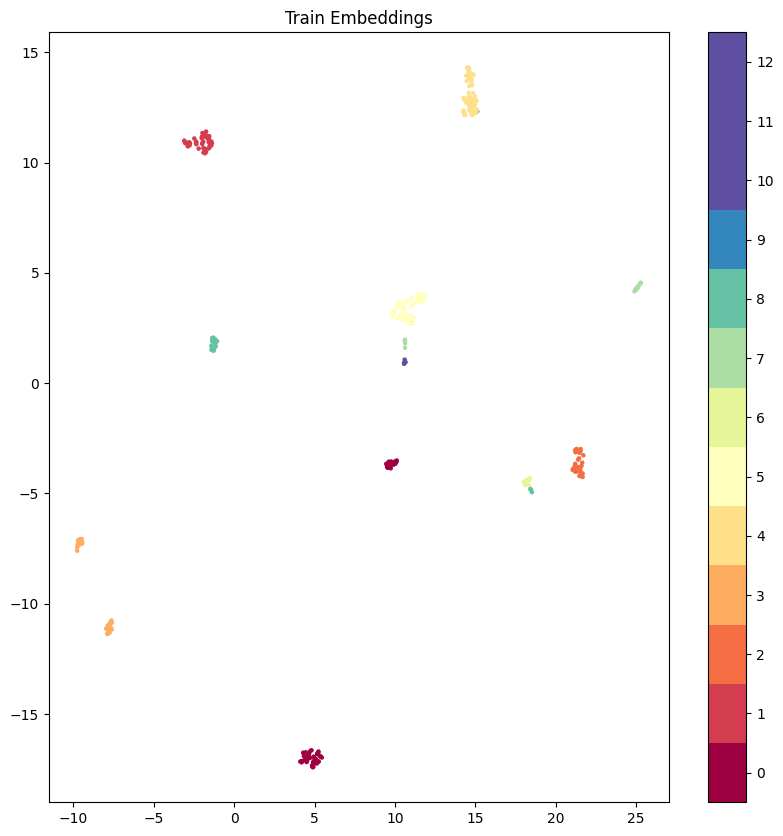

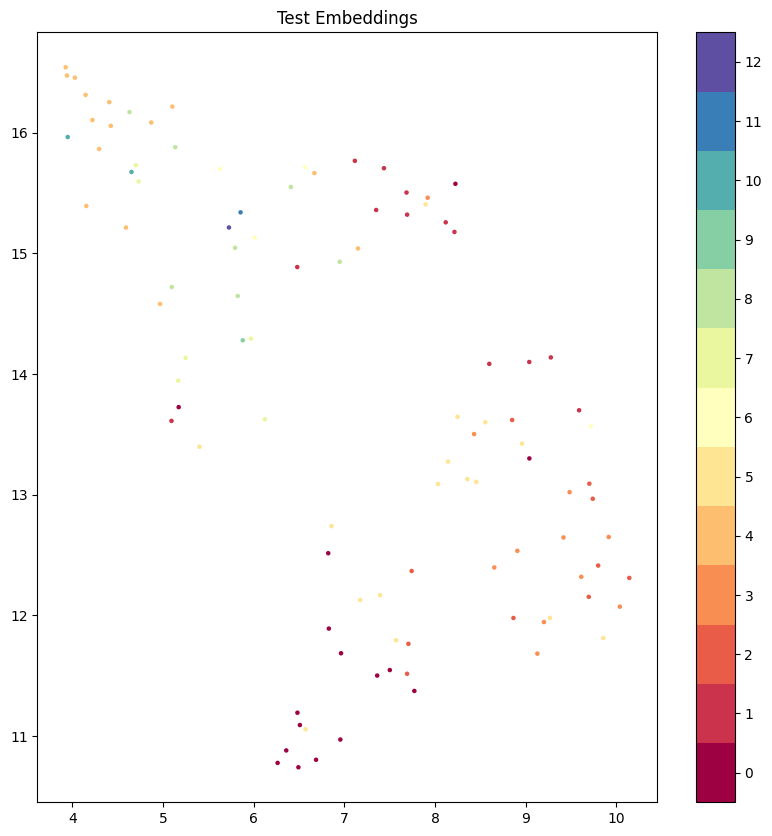

Epoch 59: Average Loss = 0.02381203882396221


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  5.82it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5445544554455446
Test set accuracy (r_precision) = 0.5387349244722136


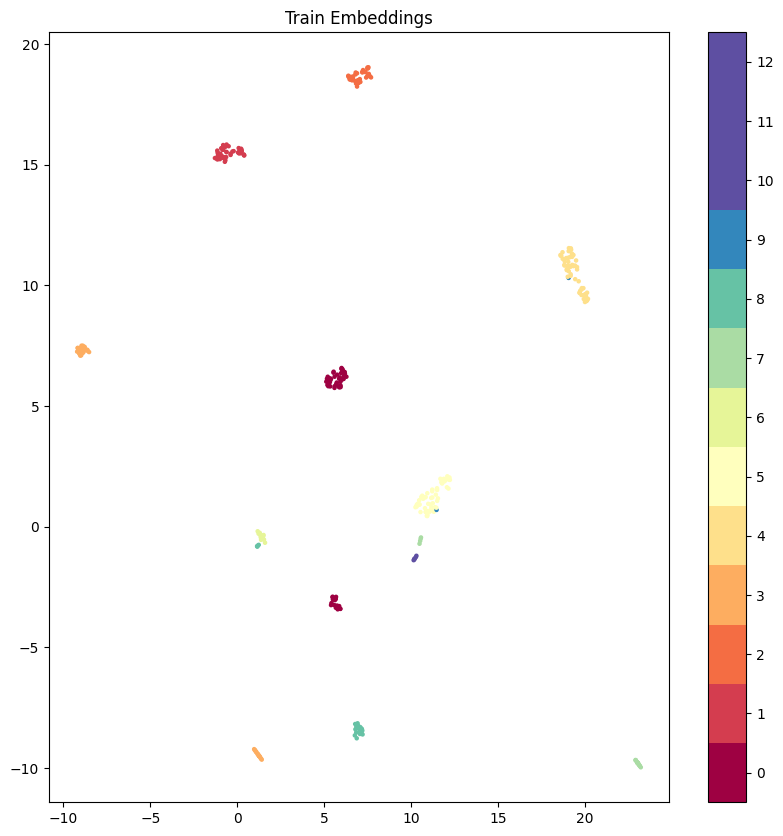

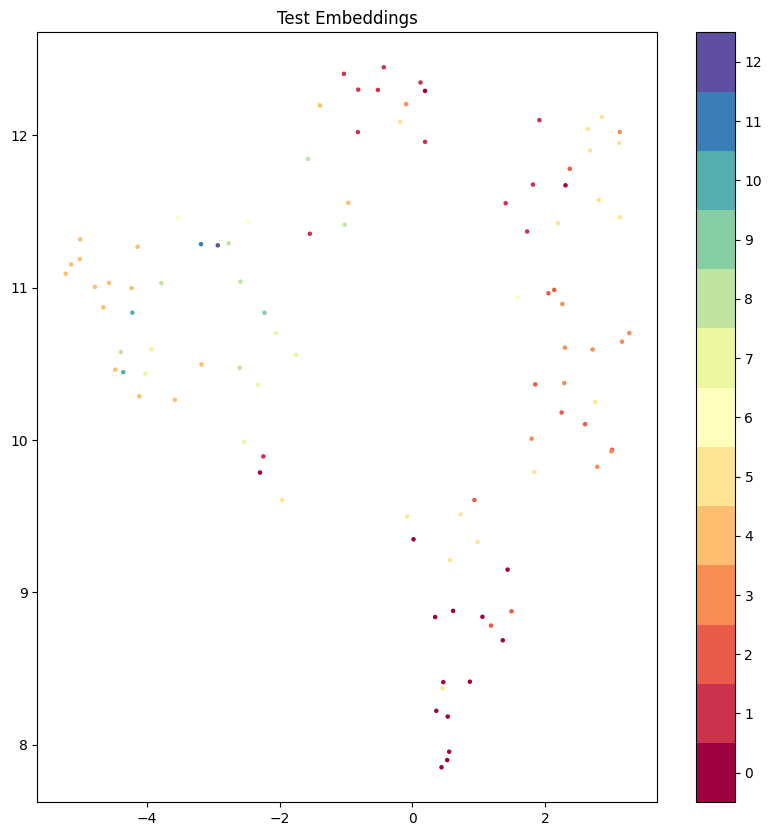

Epoch 60: Average Loss = 0.017261646687984467


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  6.28it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5445544554455446
Test set accuracy (r_precision) = 0.5351527385239985


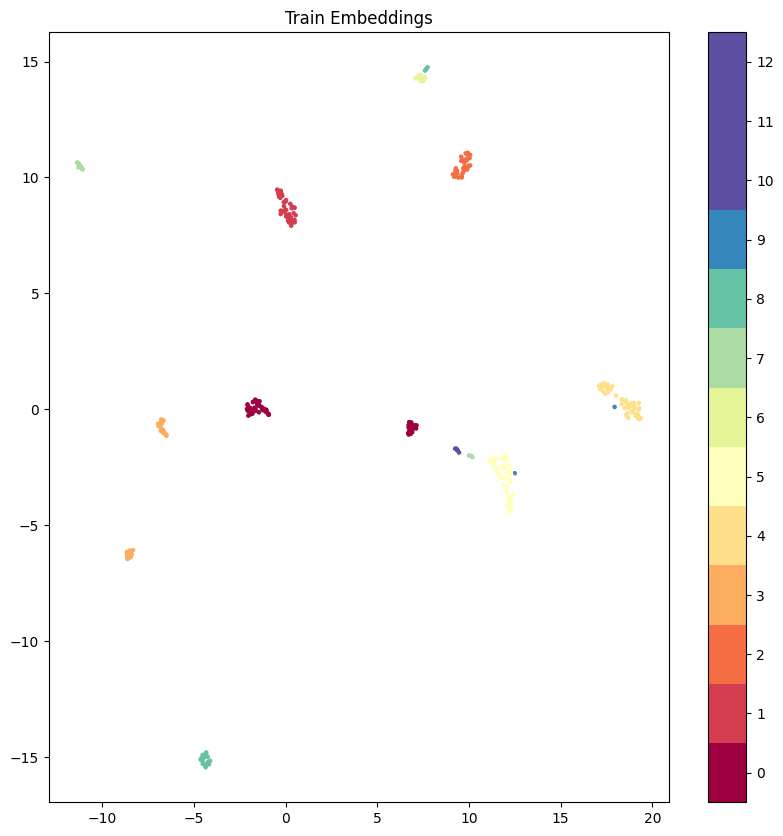

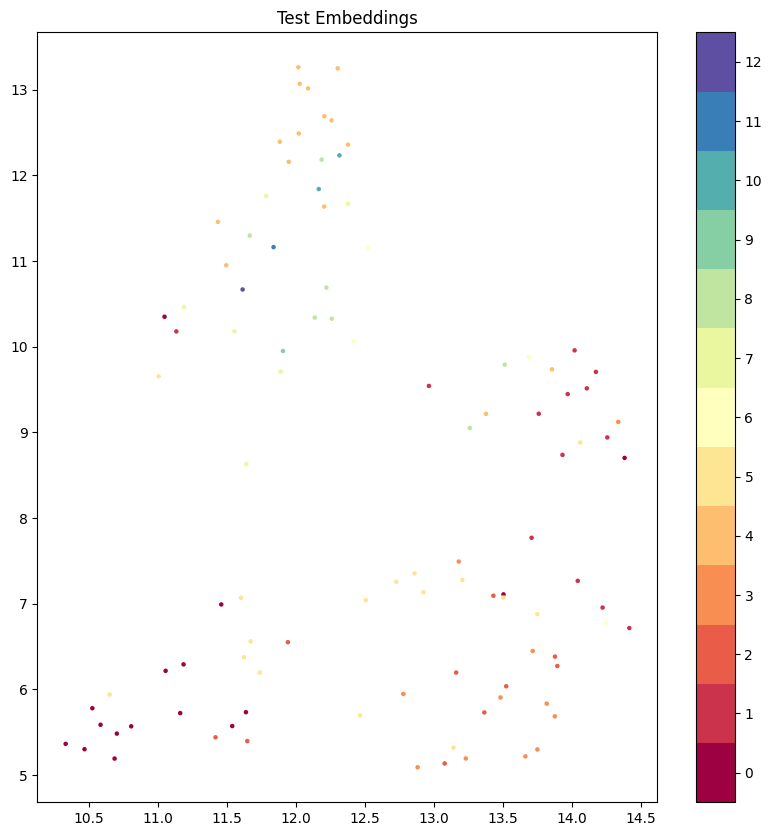

Epoch 61: Average Loss = 0.0048507824540138245


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 12/12 [00:02<00:00,  6.42it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5643564356435644
Test set accuracy (r_precision) = 0.5269979526909355


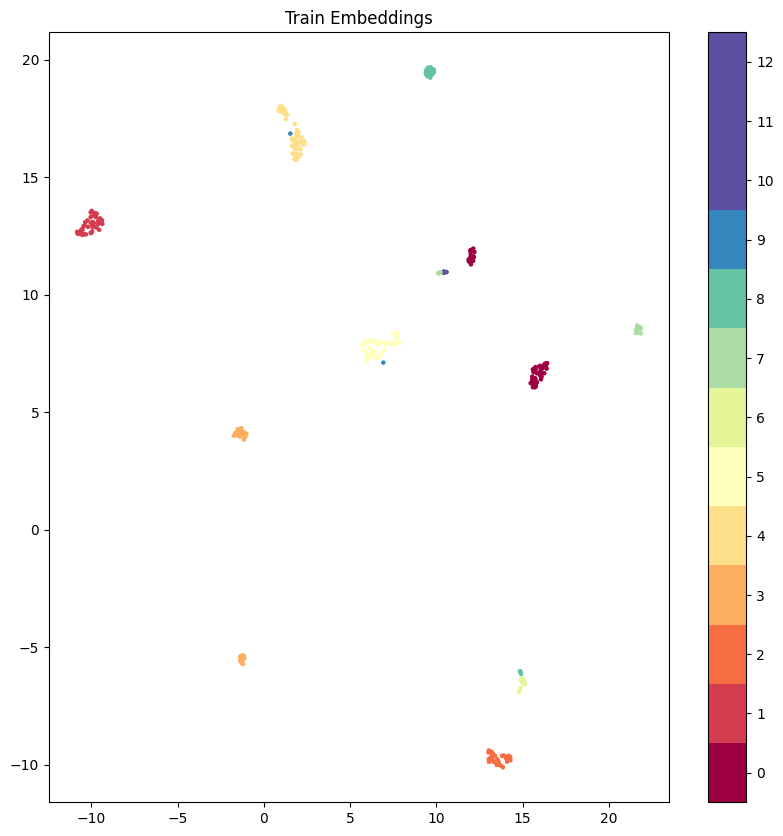

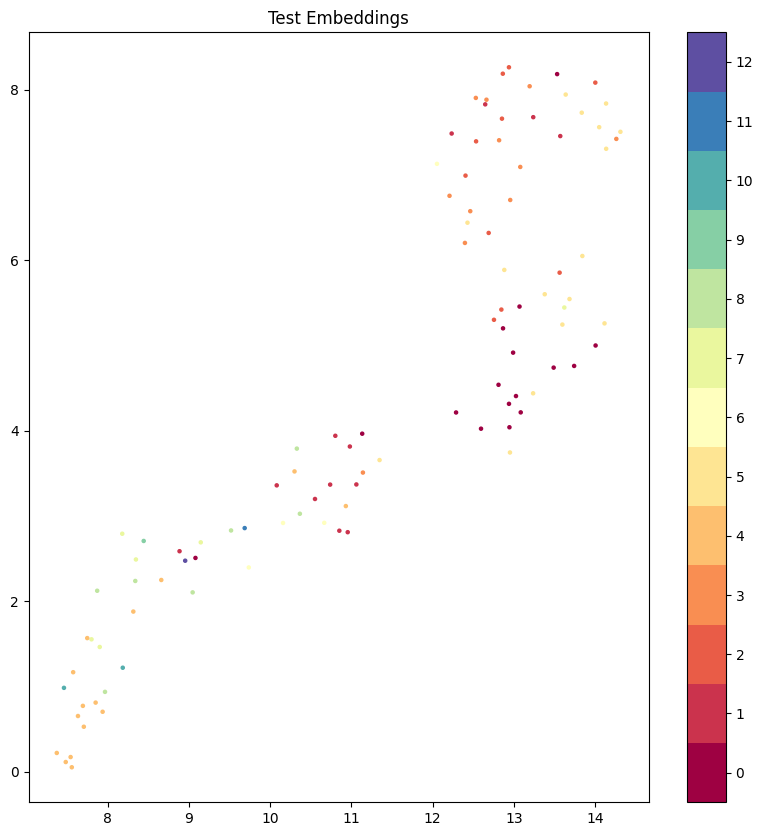

Epoch 62: Average Loss = 0.012905724346637726


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  6.54it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5445544554455446
Test set accuracy (r_precision) = 0.5225338280572932


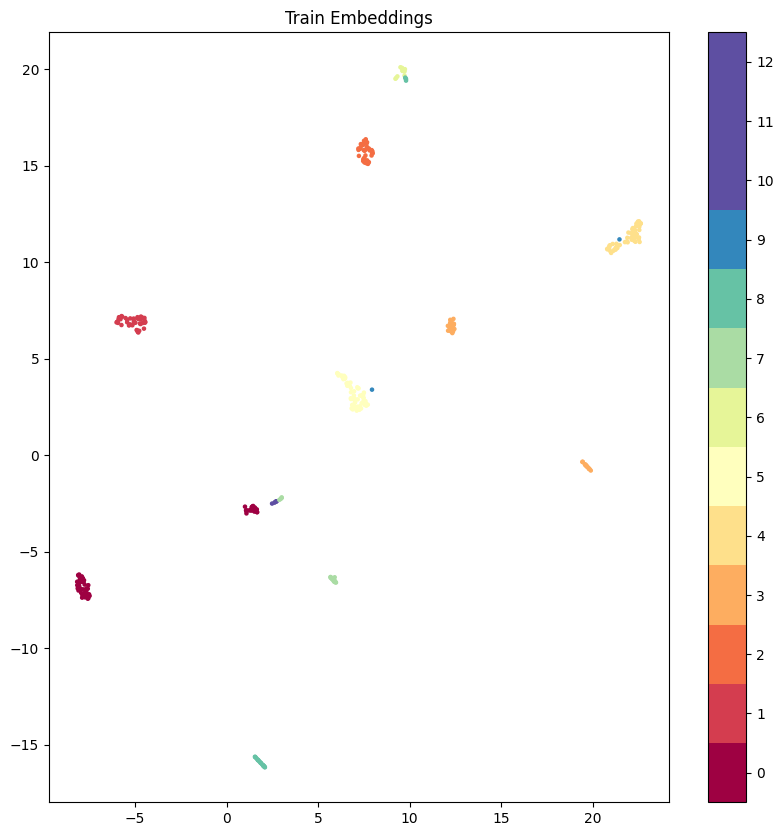

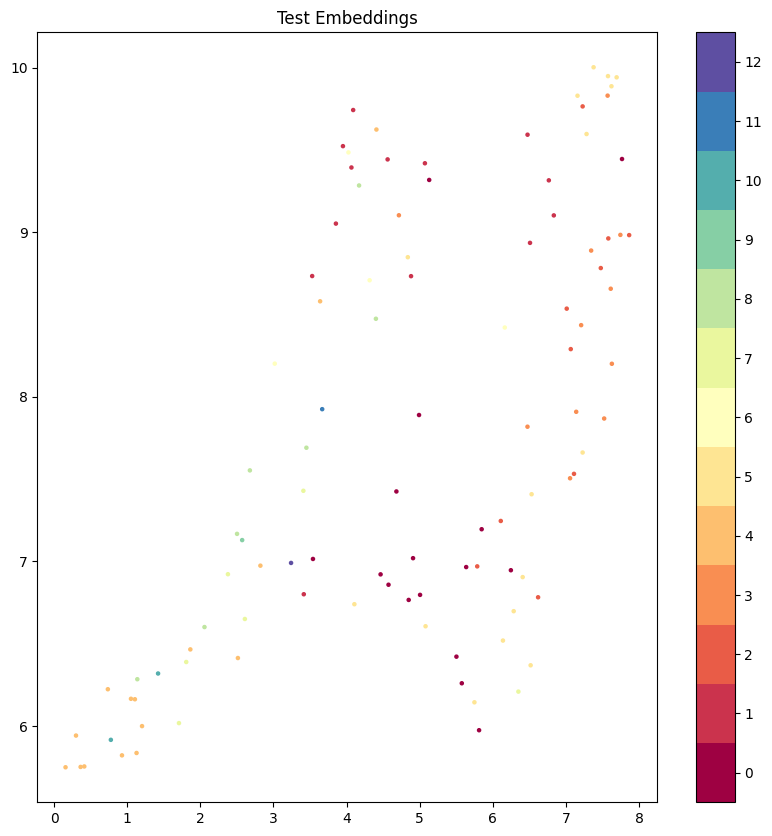

Epoch 63: Average Loss = 0.03148841019719839


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 12/12 [00:02<00:00,  6.80it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5544554455445545
Test set accuracy (r_precision) = 0.5181955265371723


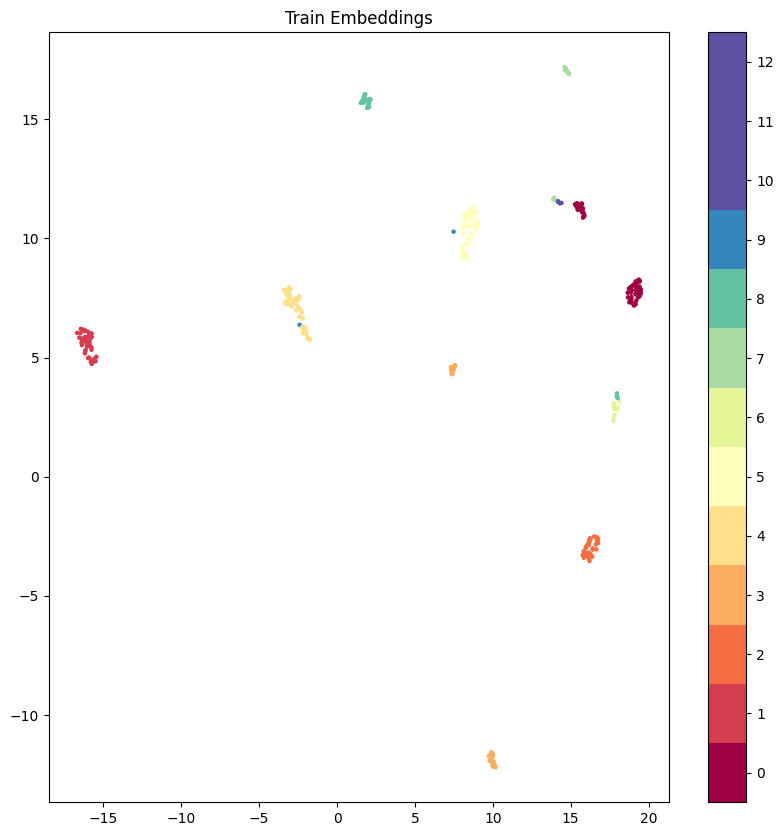

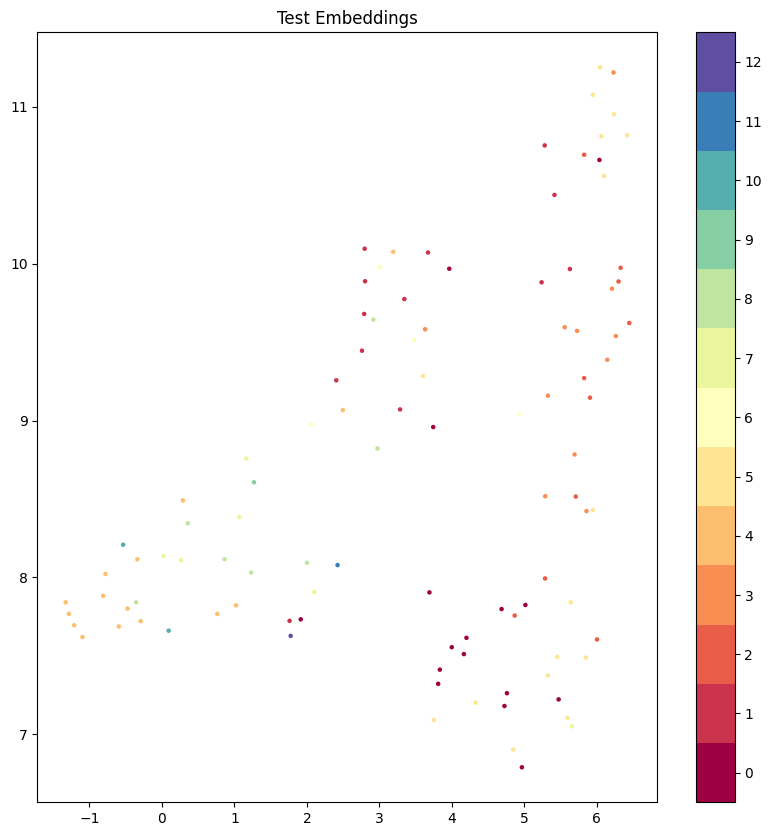

Epoch 64: Average Loss = 0.012074615806341171


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 12/12 [00:02<00:00,  7.12it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5247524752475248
Test set accuracy (r_precision) = 0.5099343673753243


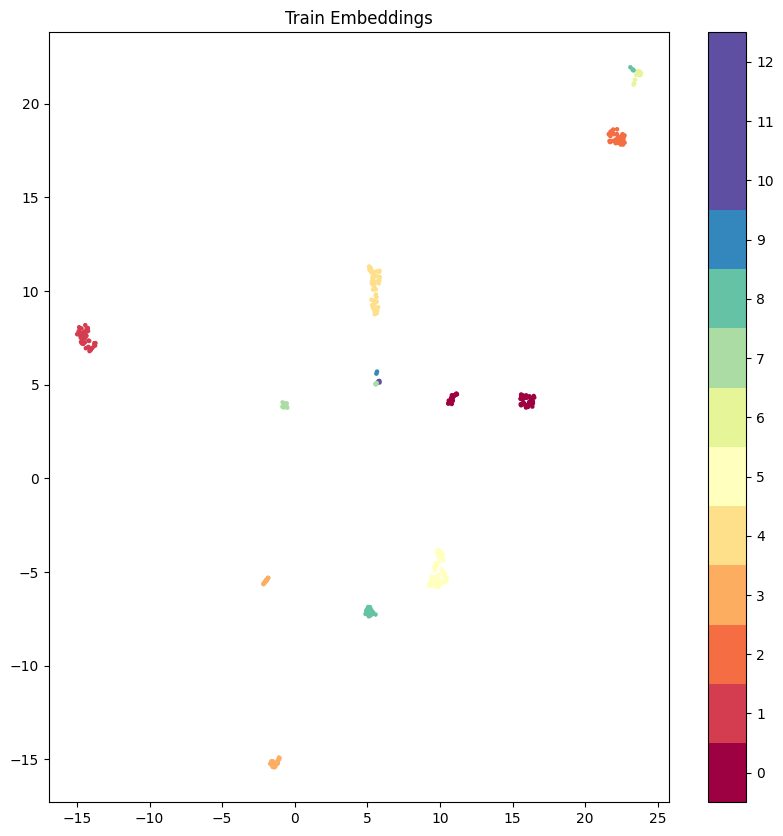

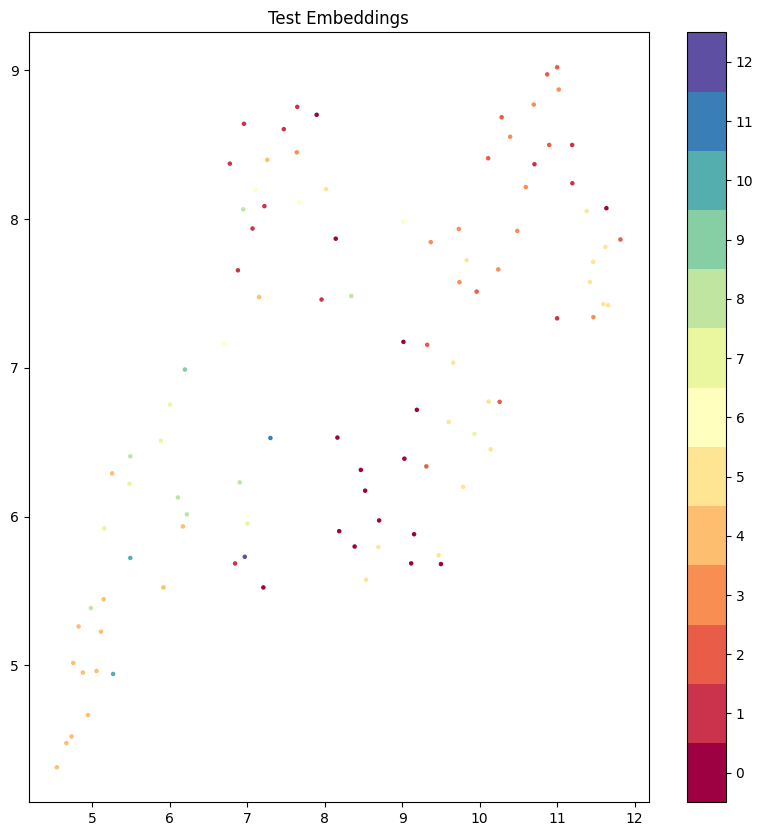

Epoch 65: Average Loss = 0.01699185185134411


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  7.01it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5247524752475248
Test set accuracy (r_precision) = 0.5031371230532062


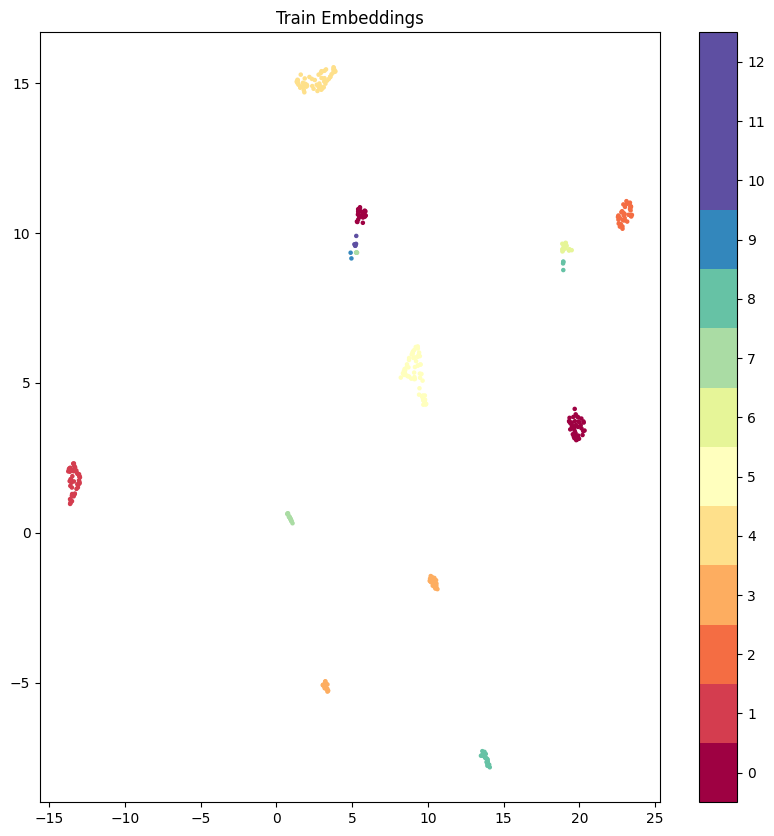

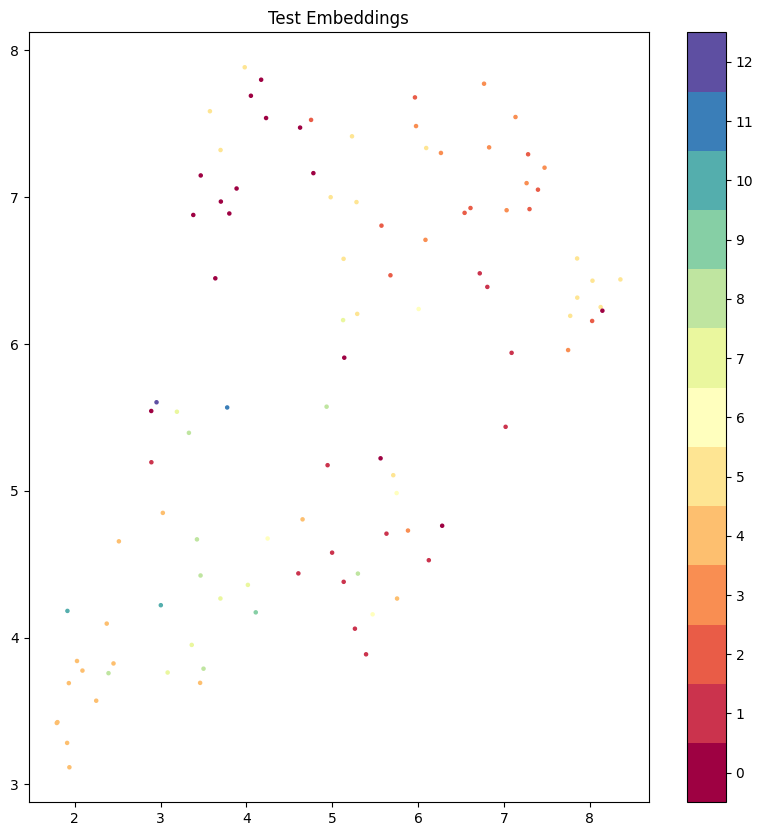

Epoch 66: Average Loss = 0.01743929088115692


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  5.82it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5247524752475248
Test set accuracy (r_precision) = 0.5024162644897698


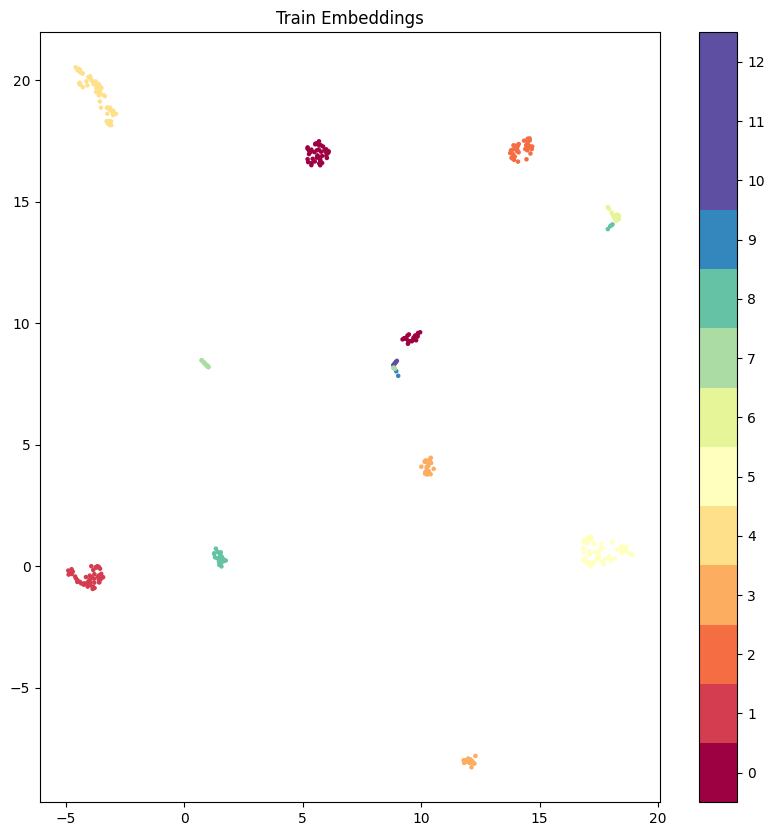

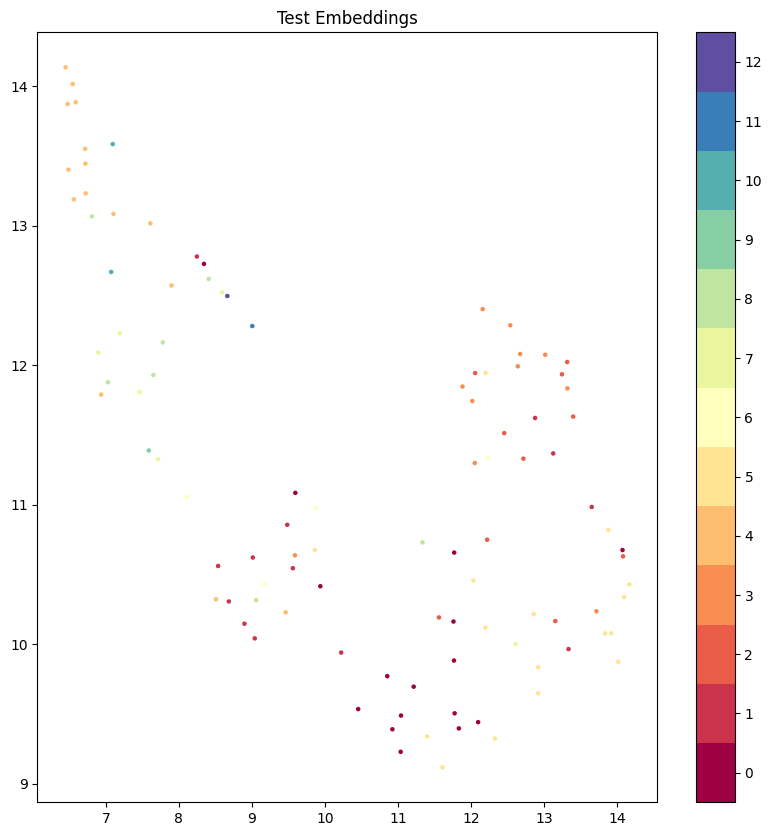

Epoch 67: Average Loss = 0.02303363848477602


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  5.61it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5247524752475248
Test set accuracy (r_precision) = 0.5011552964652954


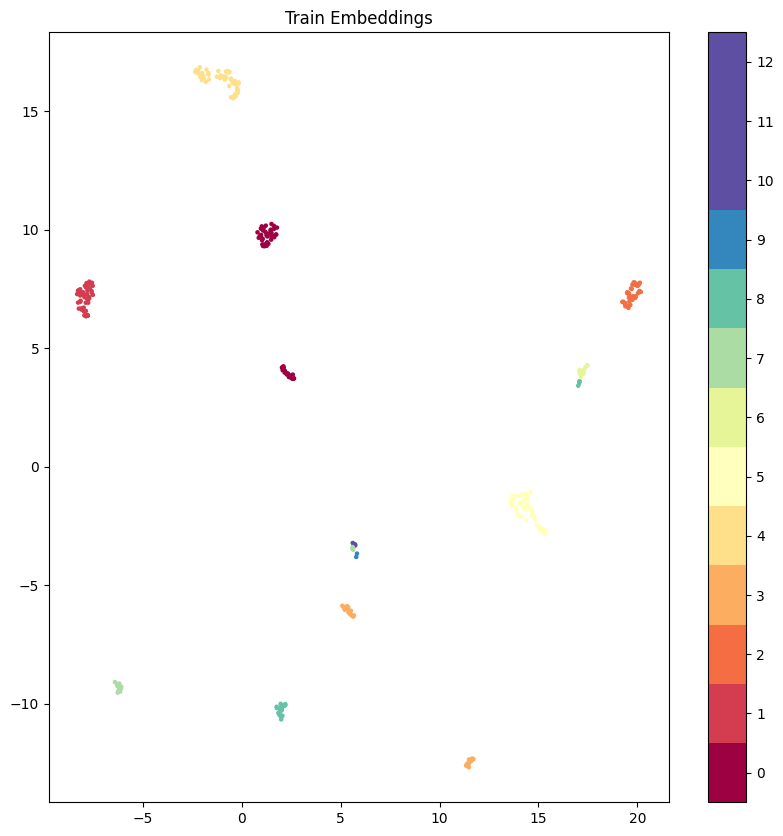

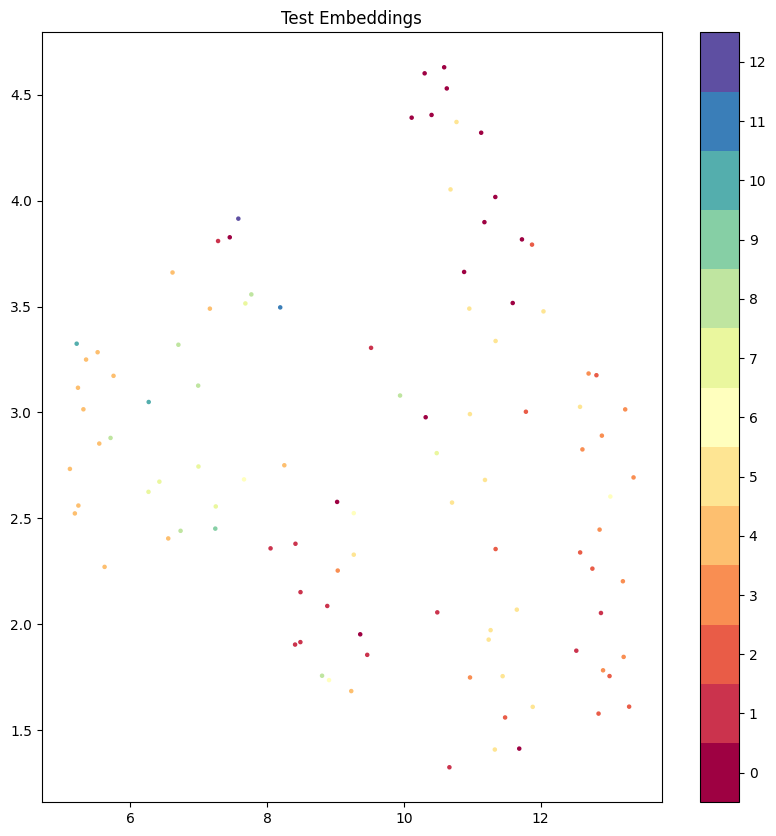

Epoch 68: Average Loss = 0.005037166178226471


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  5.94it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5148514851485149
Test set accuracy (r_precision) = 0.49674728554141967


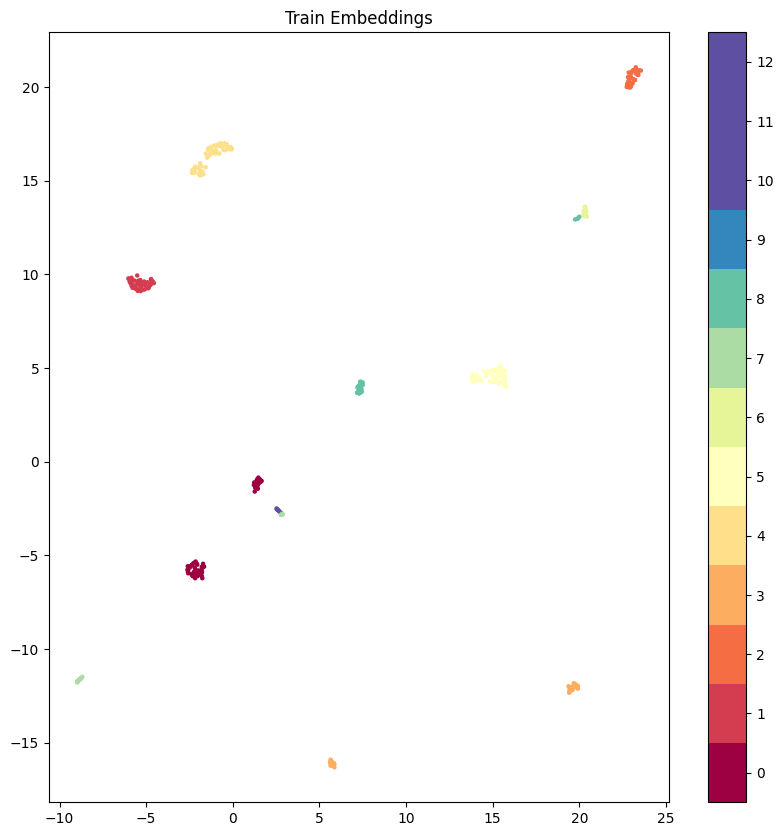

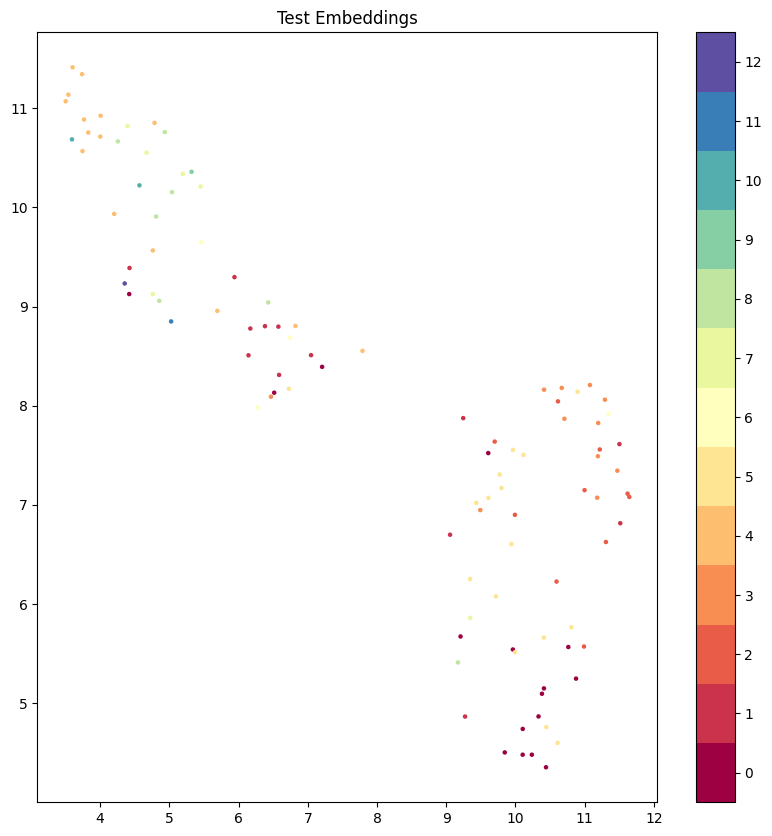

Epoch 69: Average Loss = 0.007462602108716965


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  5.63it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5247524752475248
Test set accuracy (r_precision) = 0.4931708824668104


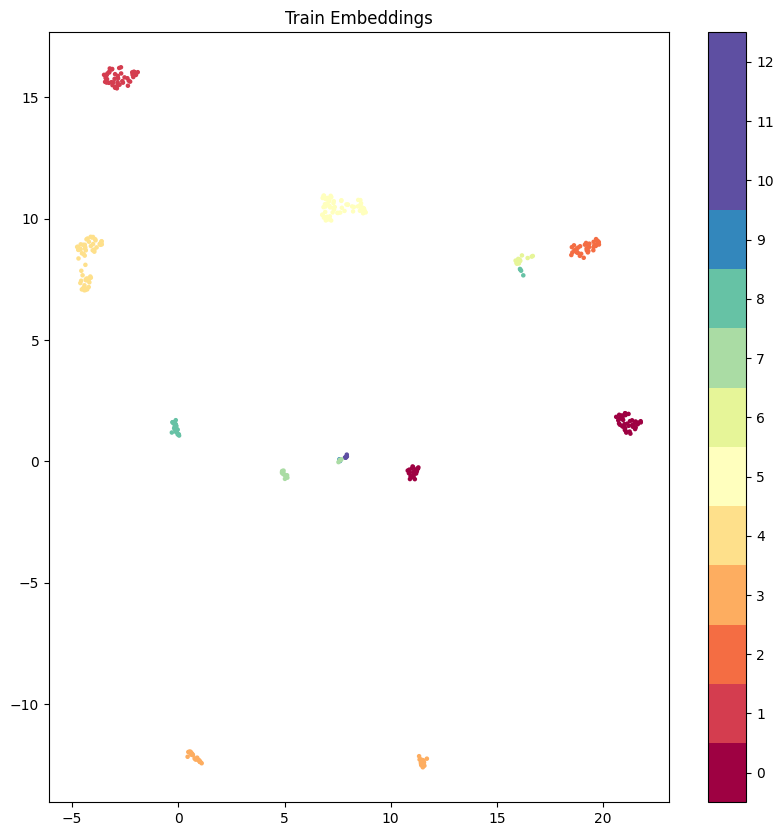

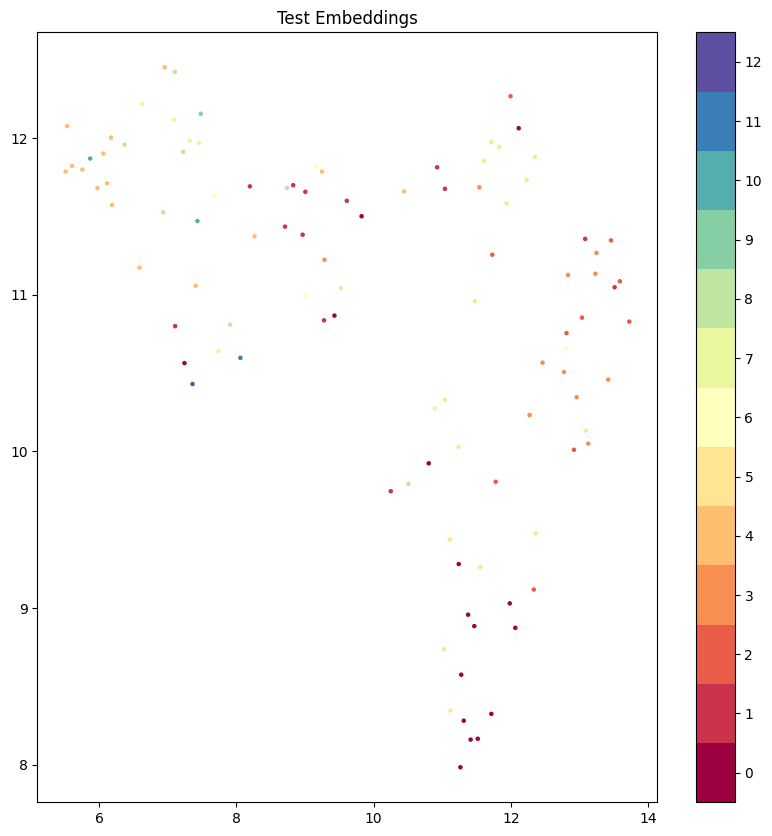

Epoch 70: Average Loss = 0.0


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 12/12 [00:02<00:00,  6.75it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5148514851485149
Test set accuracy (r_precision) = 0.4864663105985109


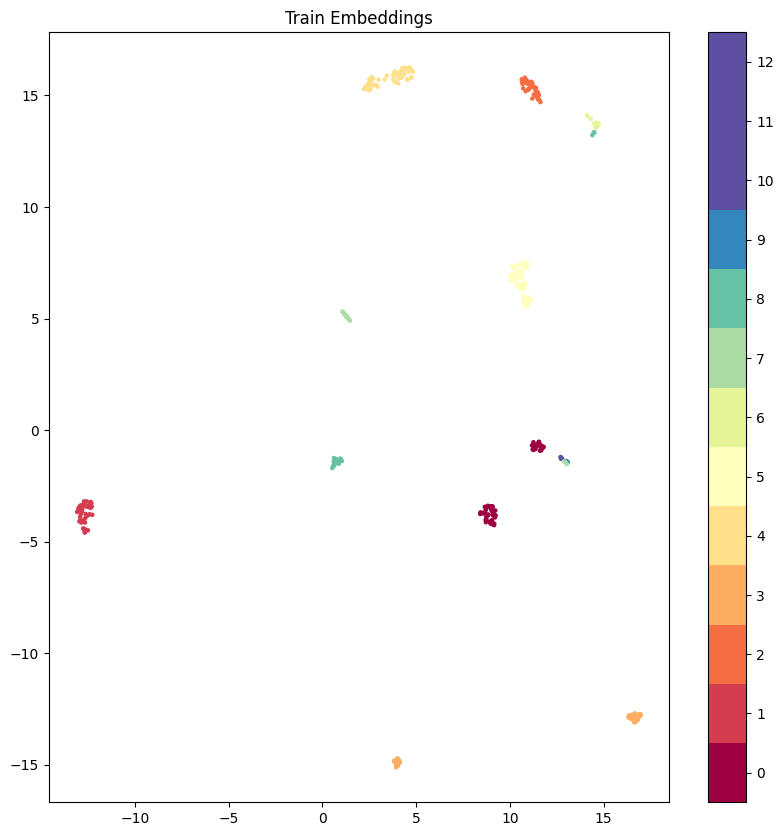

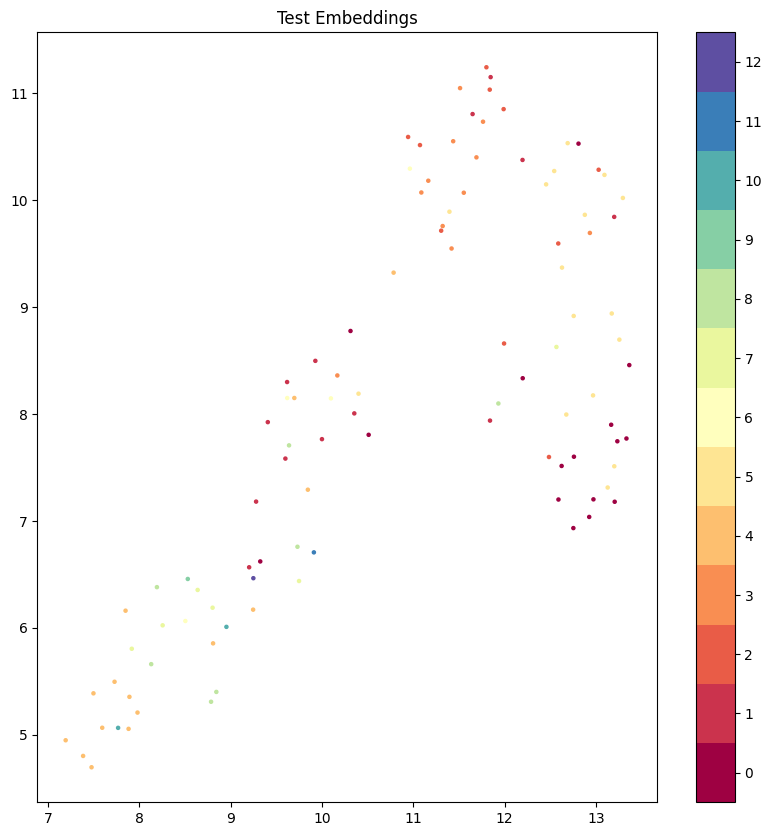

Epoch 71: Average Loss = 0.0014580264687538147


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  5.71it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5346534653465347
Test set accuracy (r_precision) = 0.4892981387492528


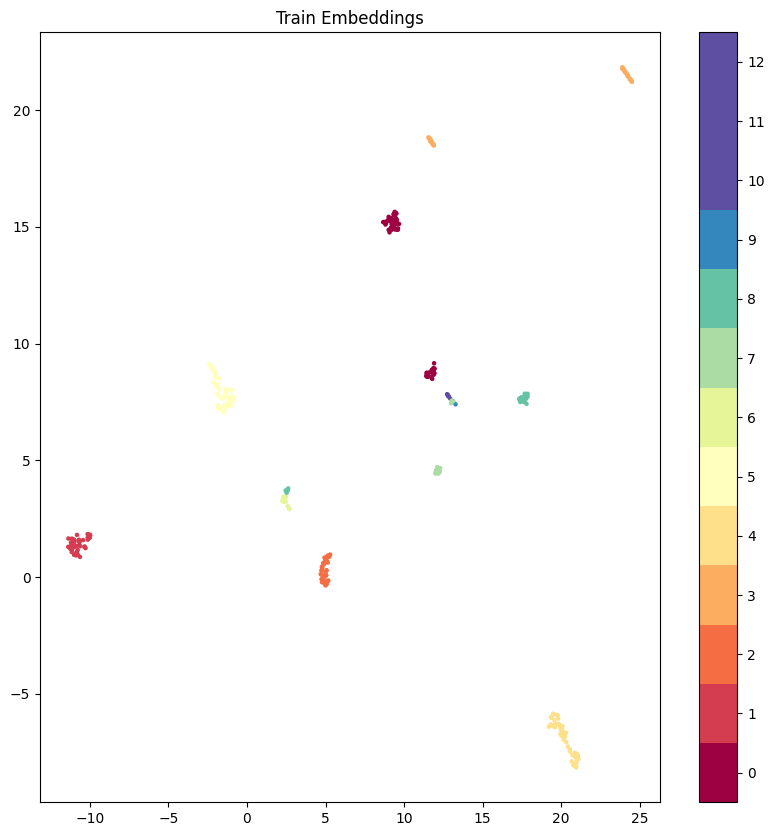

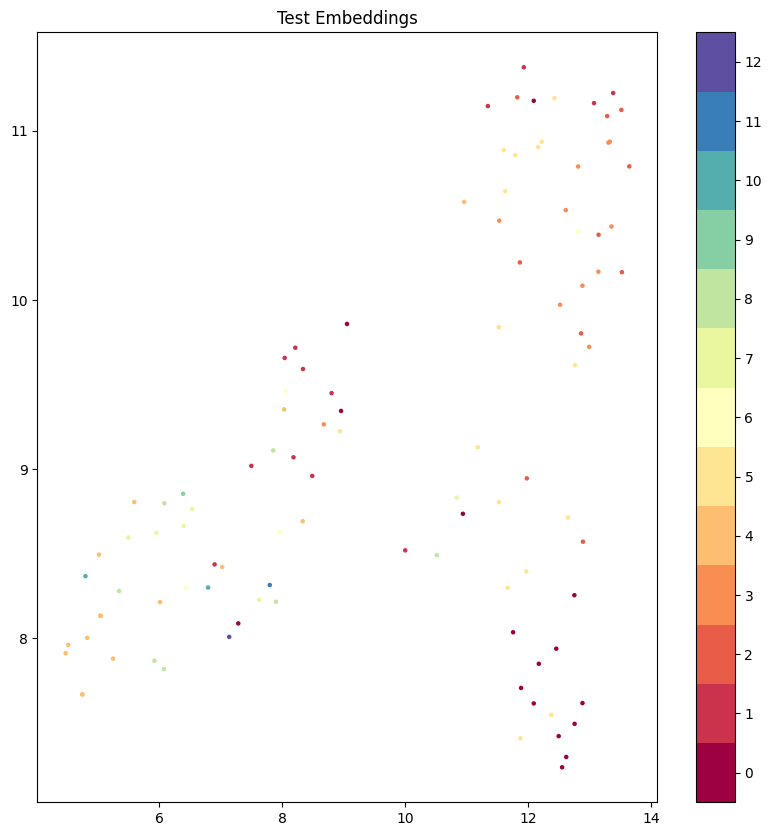

Epoch 72: Average Loss = 0.0


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  6.43it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.78it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5544554455445545
Test set accuracy (r_precision) = 0.4916148083725149


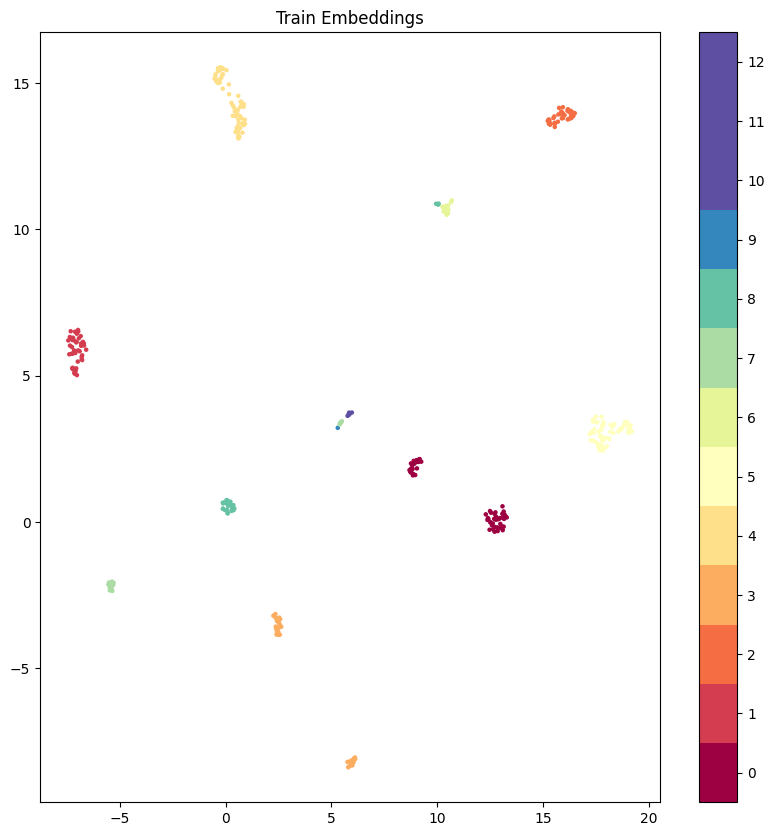

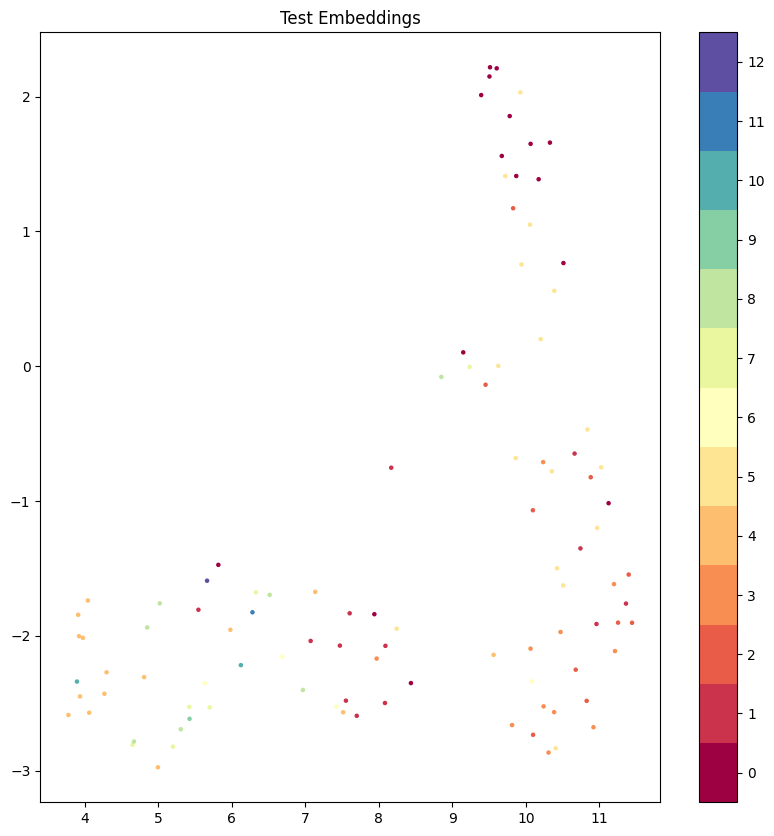

Epoch 73: Average Loss = 0.012050691060721874


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5445544554455446
Test set accuracy (r_precision) = 0.49688080947658675


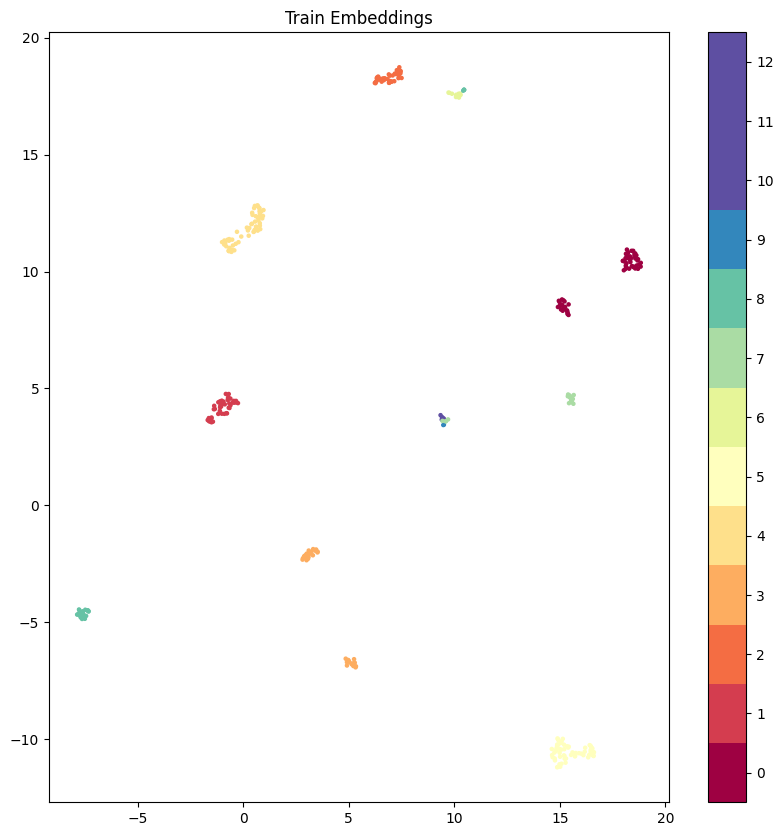

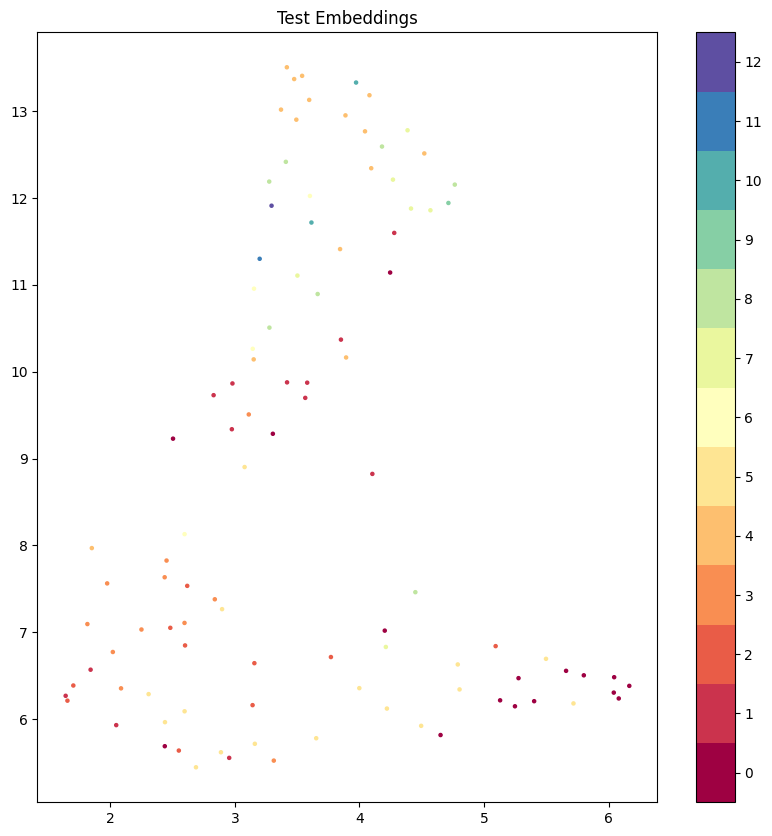

Epoch 74: Average Loss = 0.005535848438739777


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  6.30it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5544554455445545
Test set accuracy (r_precision) = 0.5023514163645935


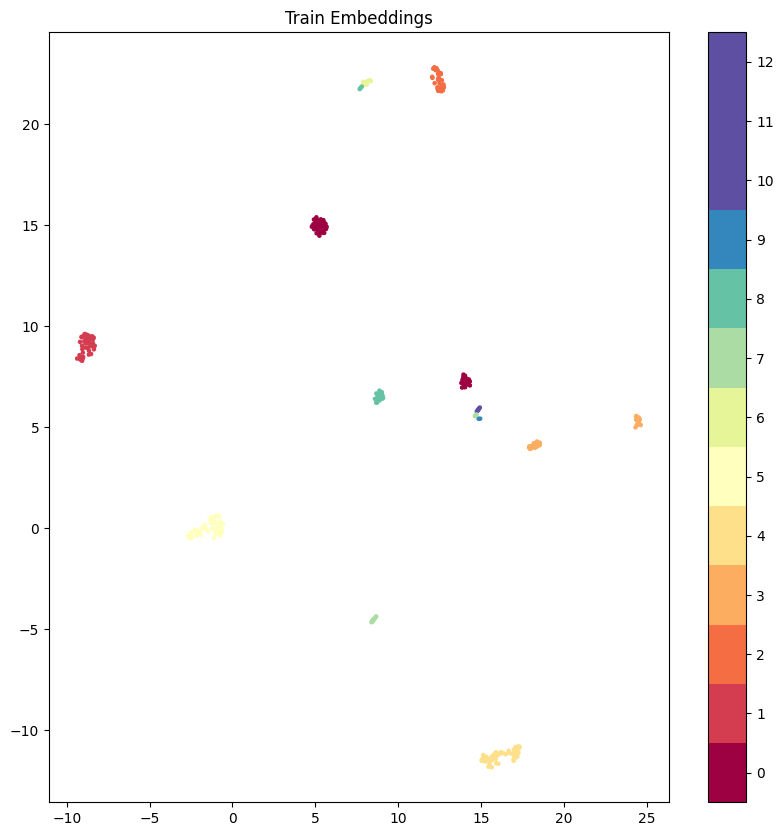

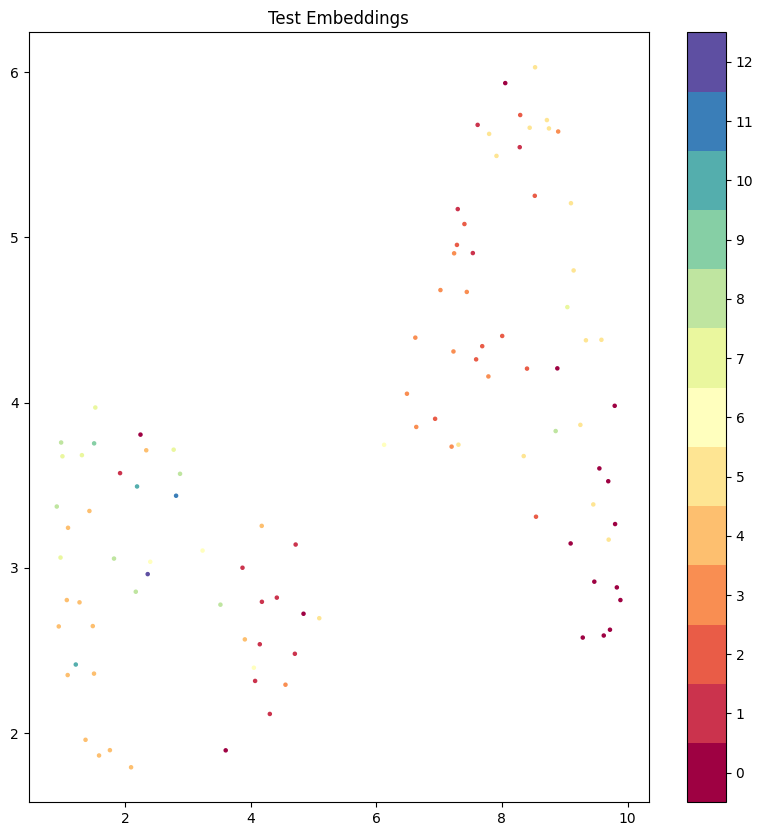

Epoch 75: Average Loss = 0.00567539781332016


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  6.38it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.00it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5445544554455446
Test set accuracy (r_precision) = 0.5099118763975345


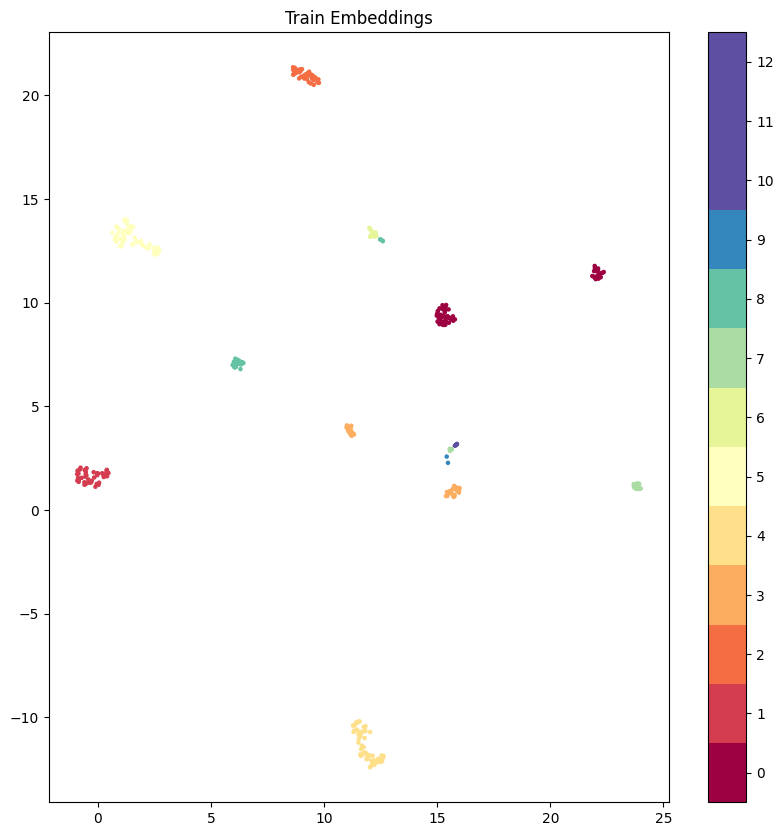

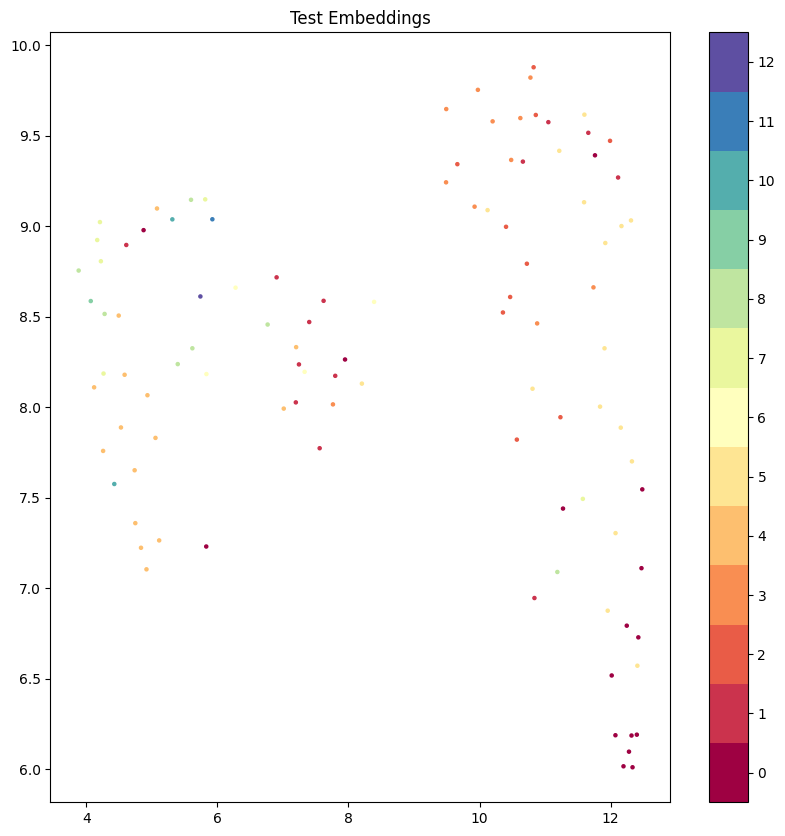

Epoch 76: Average Loss = 0.004312748787924647


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 12/12 [00:02<00:00,  6.39it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5742574257425742
Test set accuracy (r_precision) = 0.5177132779591872


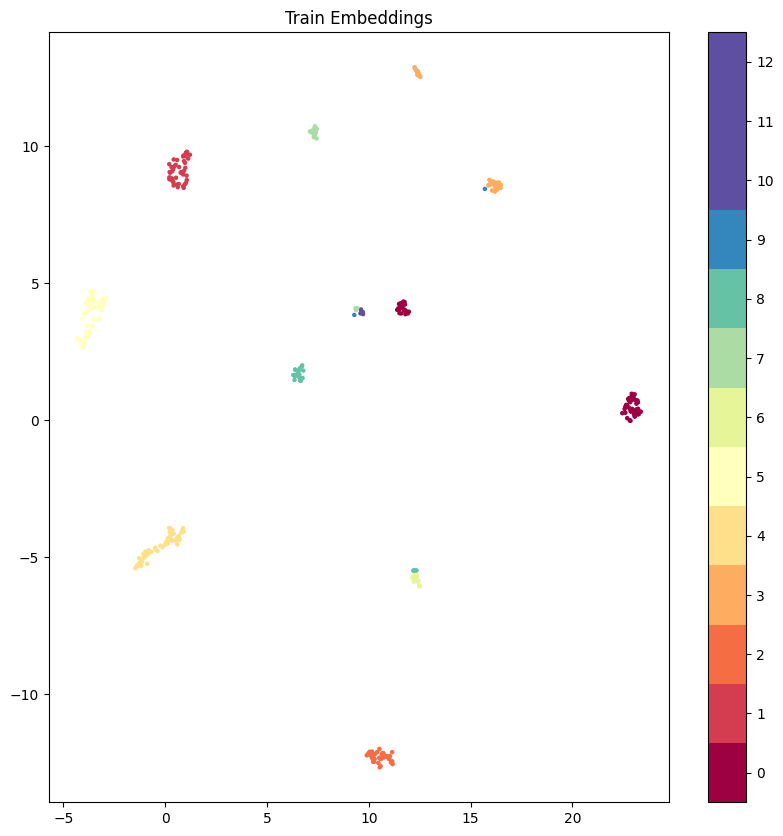

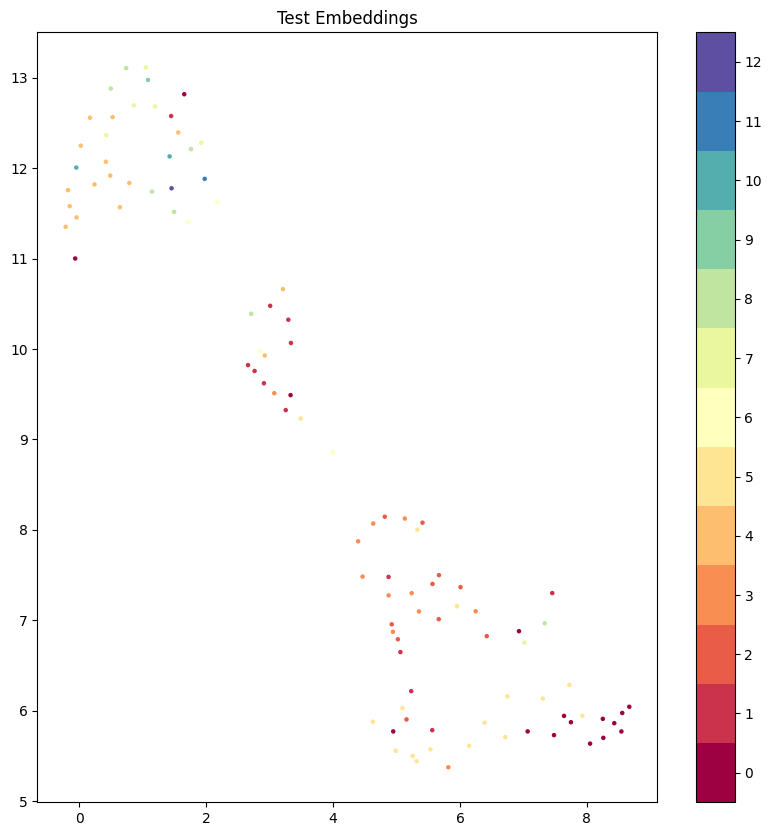

Epoch 77: Average Loss = 0.023412402719259262


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  6.03it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5445544554455446
Test set accuracy (r_precision) = 0.527000534152407


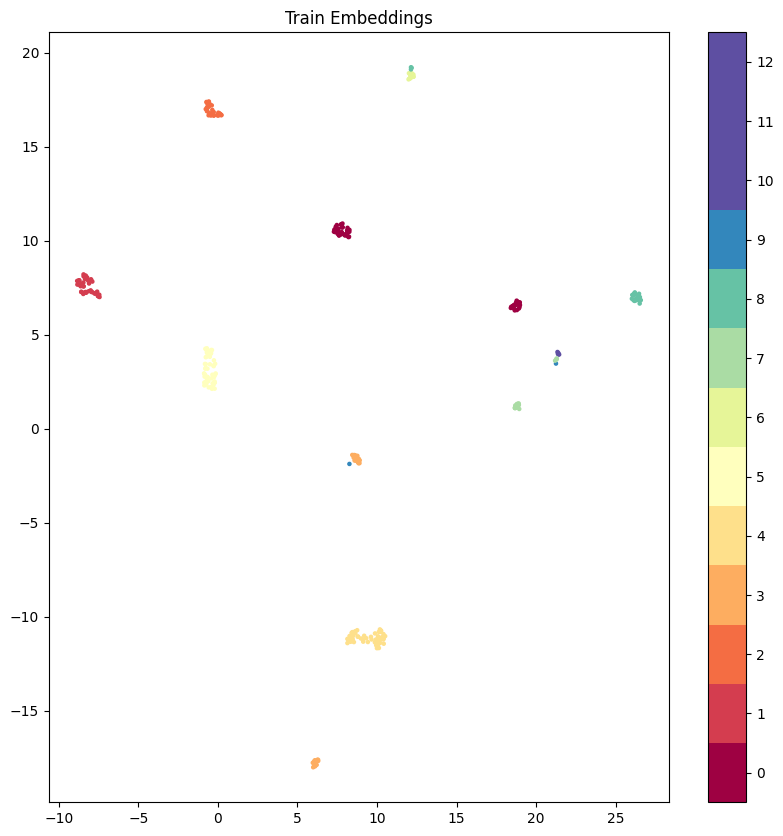

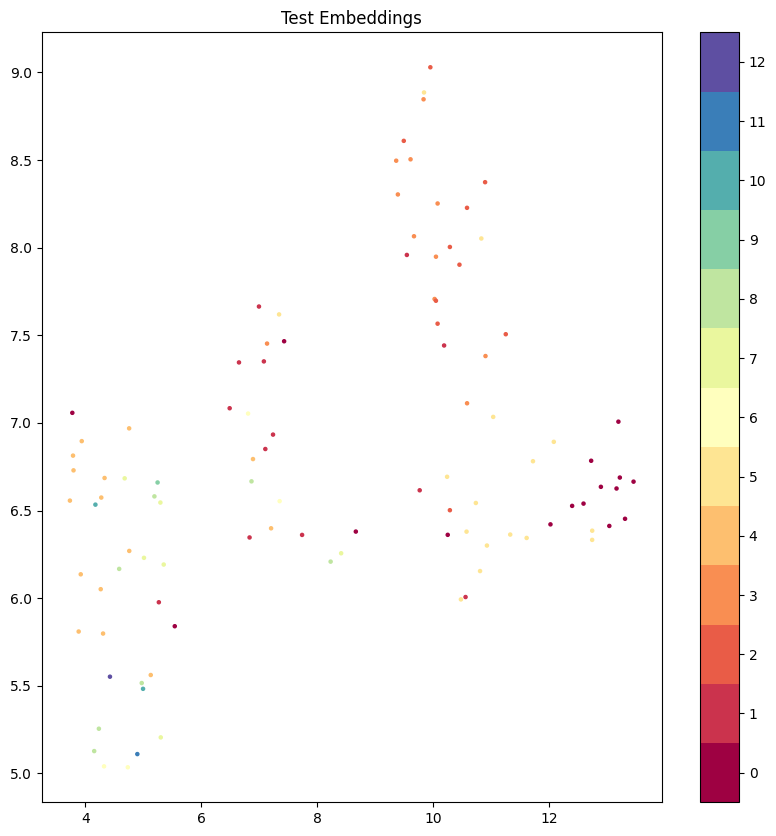

Epoch 78: Average Loss = 0.00941421277821064


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  5.80it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5742574257425742
Test set accuracy (r_precision) = 0.5340994966529613


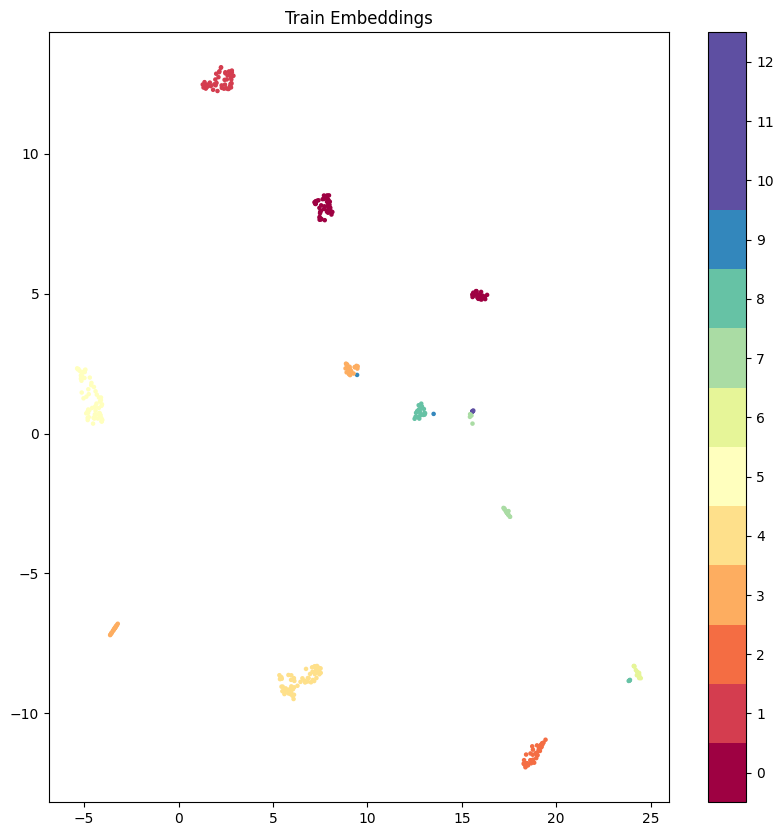

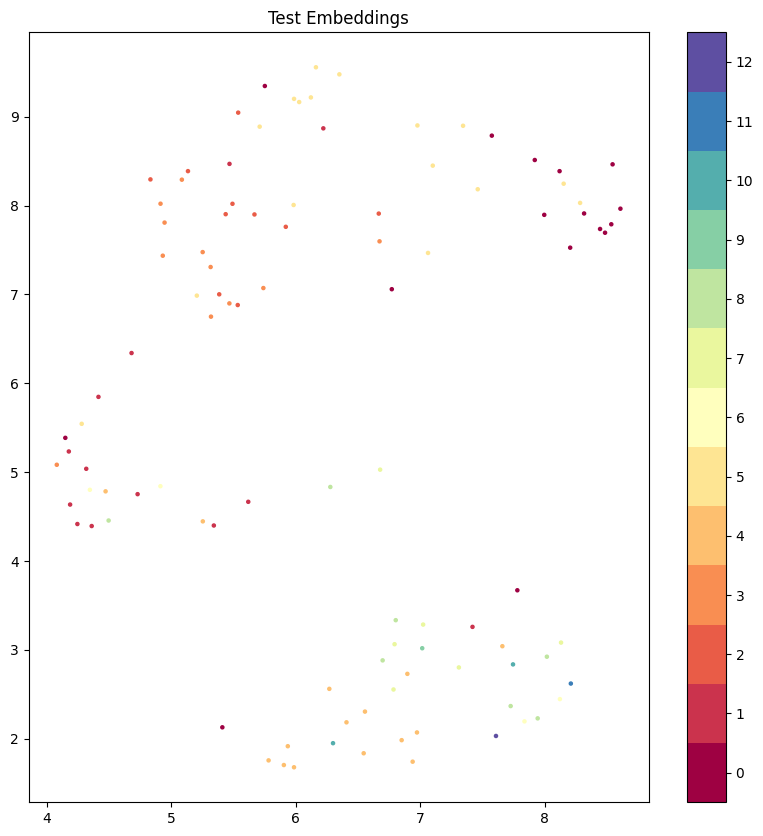

Epoch 79: Average Loss = 0.003522135317325592


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  5.79it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5742574257425742
Test set accuracy (r_precision) = 0.535863619080666


Epoch 80: Average Loss = 0.010827817022800446


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  5.39it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.594059405940594
Test set accuracy (r_precision) = 0.5399481770986811


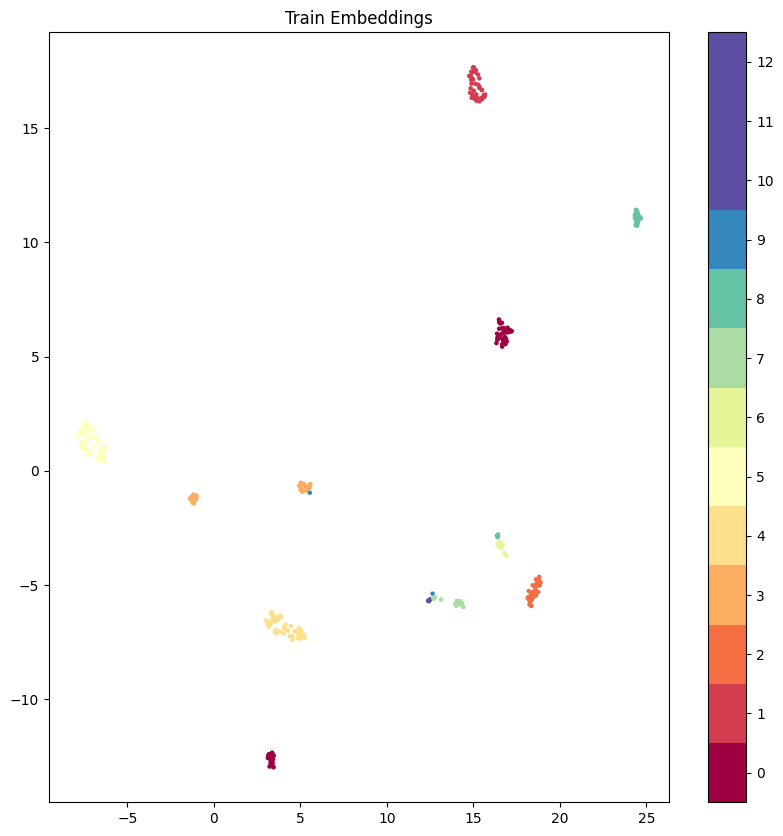

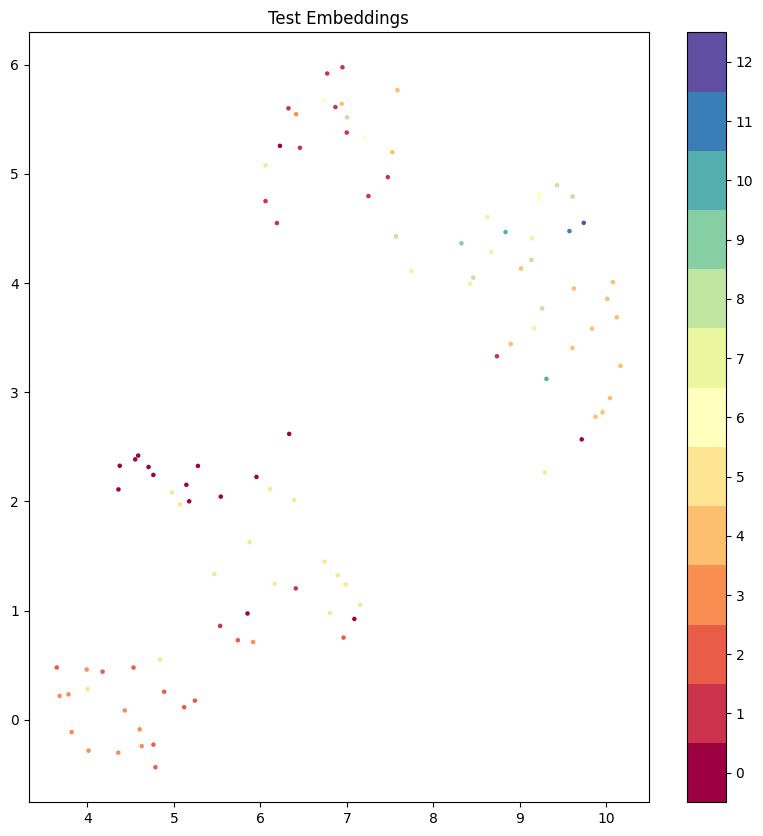

Epoch 81: Average Loss = 0.004457143601030111


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:03<00:00,  3.79it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5841584158415841
Test set accuracy (r_precision) = 0.5449082697846299


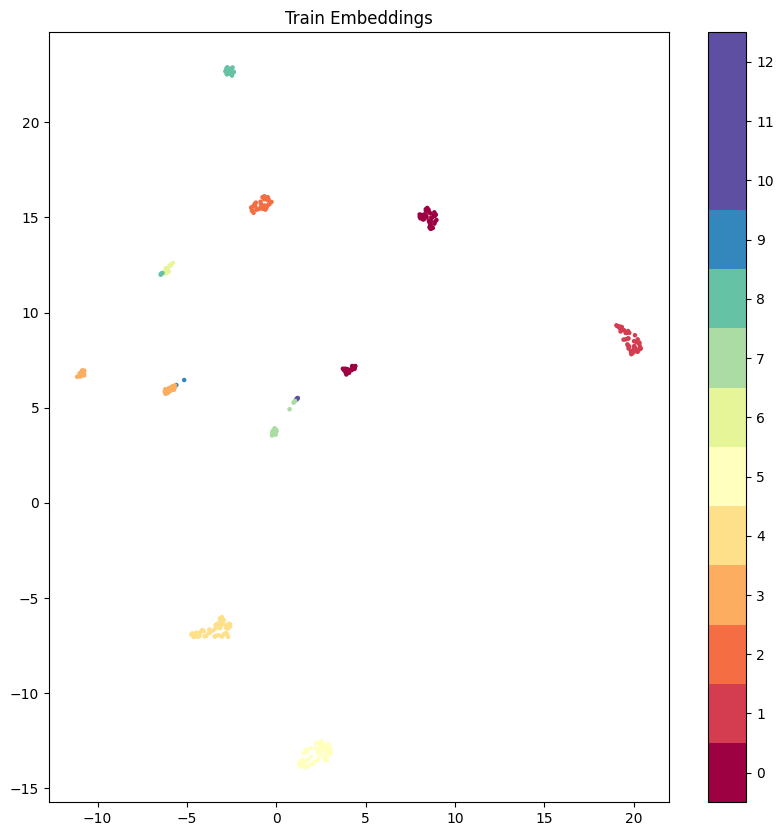

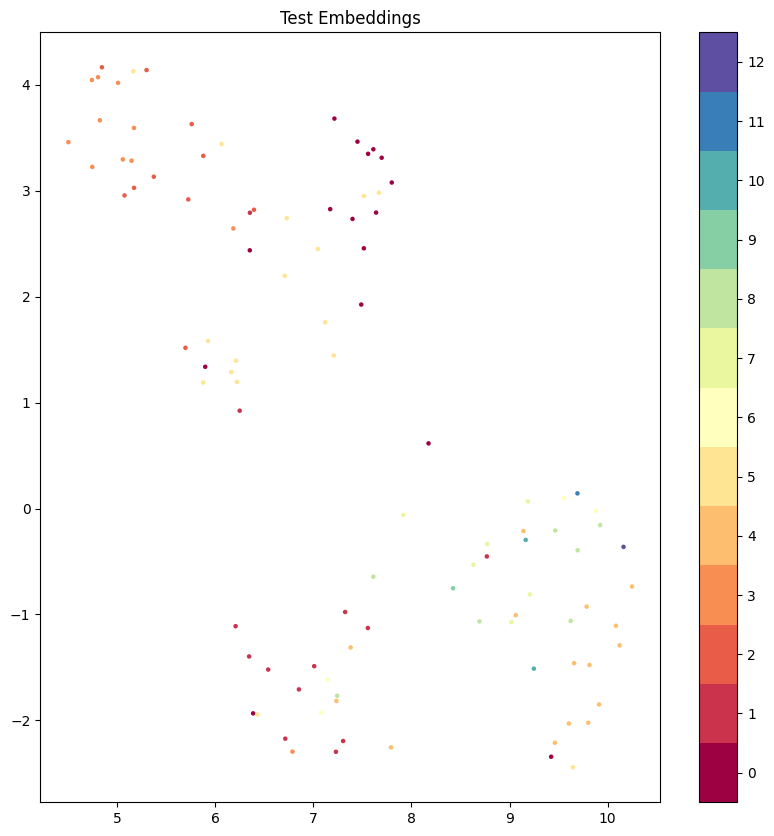

Epoch 82: Average Loss = 0.007695615291595459


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  4.19it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6039603960396039
Test set accuracy (r_precision) = 0.544042413019169


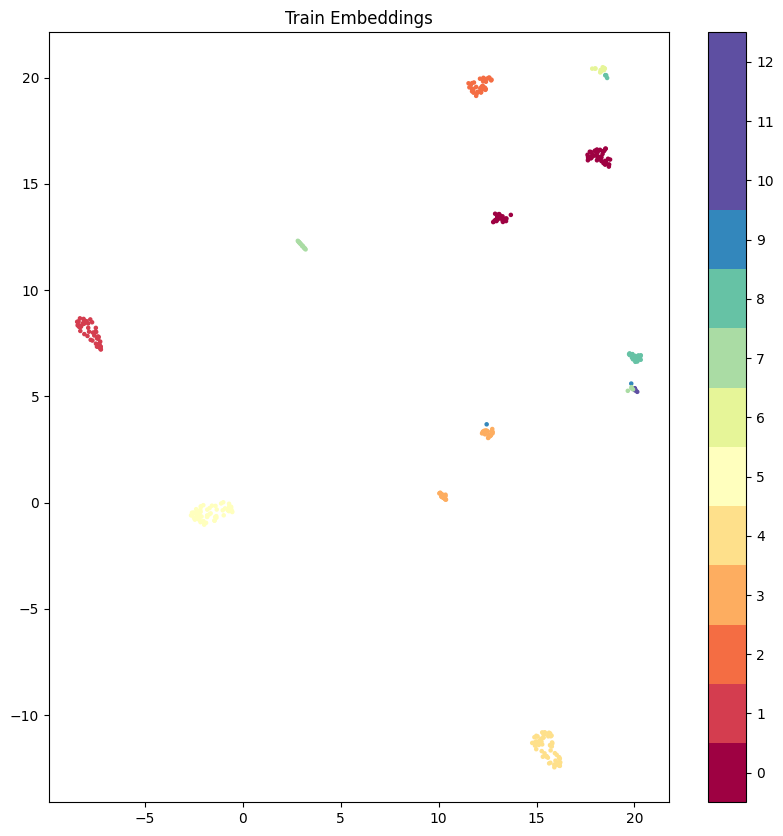

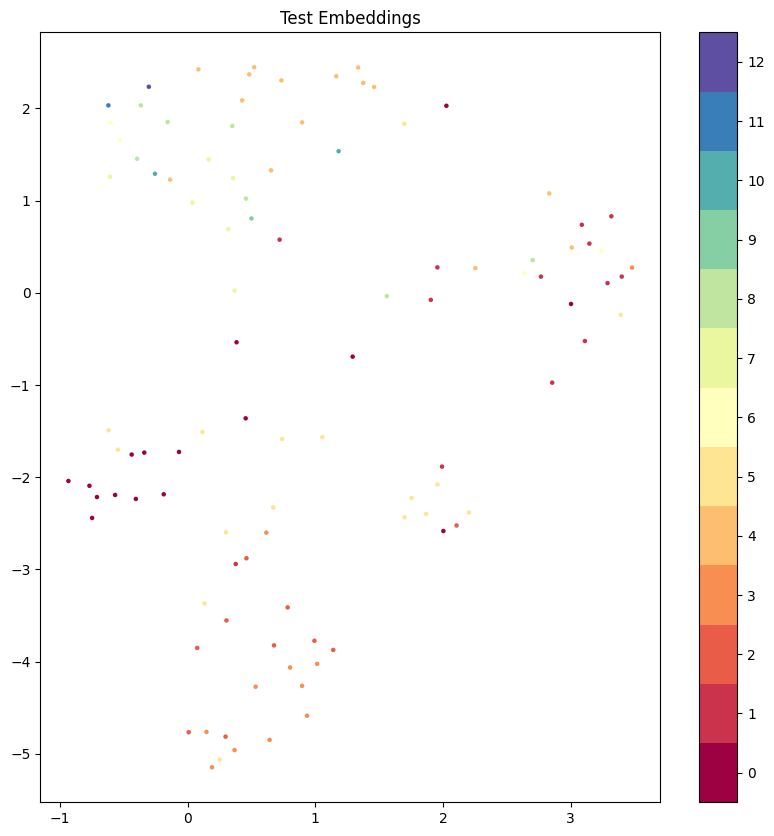

Epoch 83: Average Loss = 0.019603950437158346


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  5.38it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.594059405940594
Test set accuracy (r_precision) = 0.5365883779886139


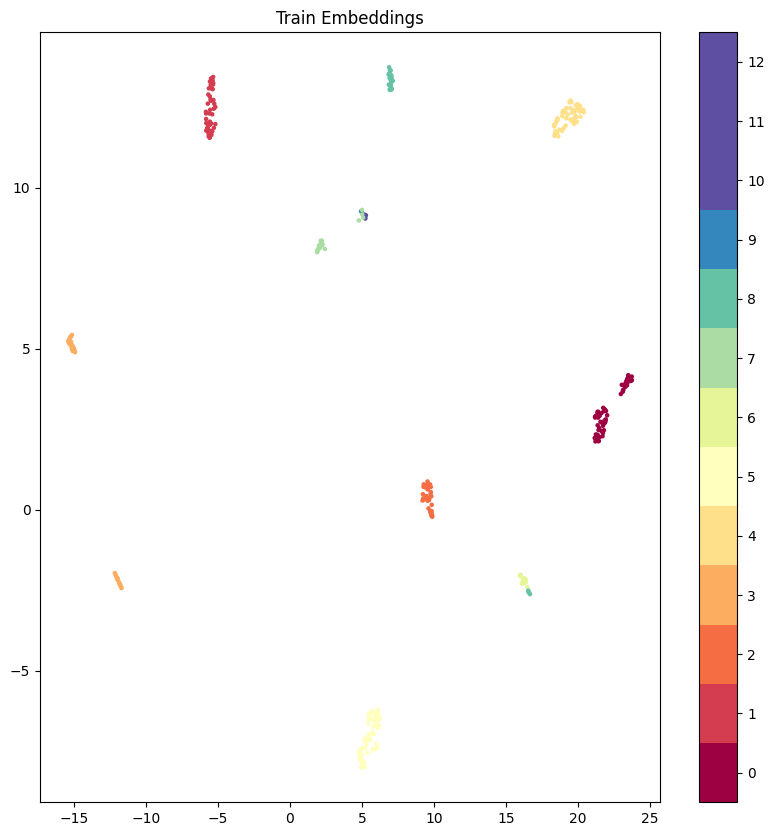

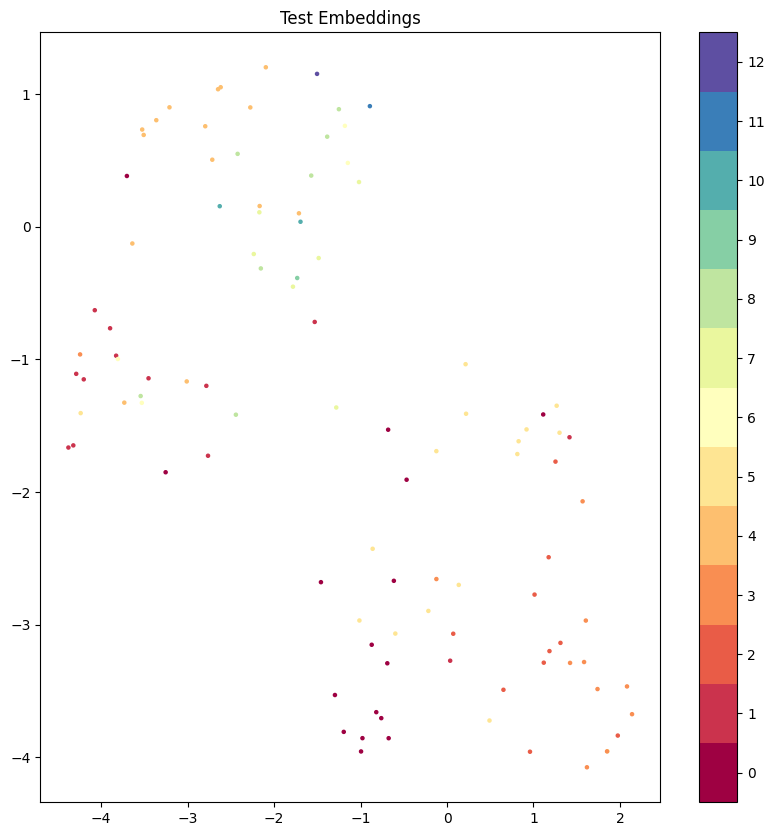

Epoch 84: Average Loss = 0.03810782078653574


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  6.24it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6138613861386139
Test set accuracy (r_precision) = 0.5389263168795401


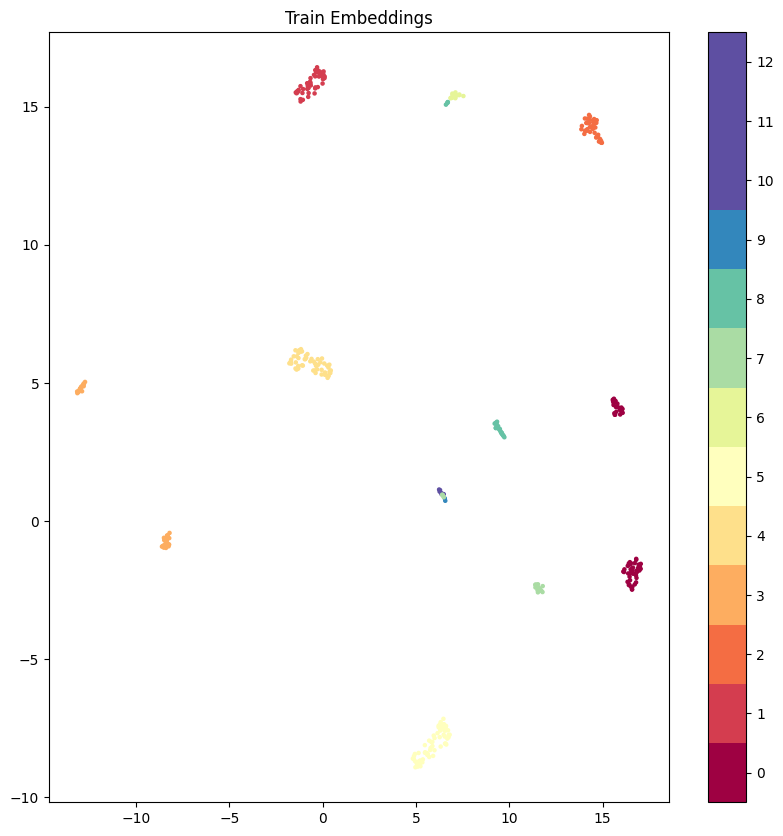

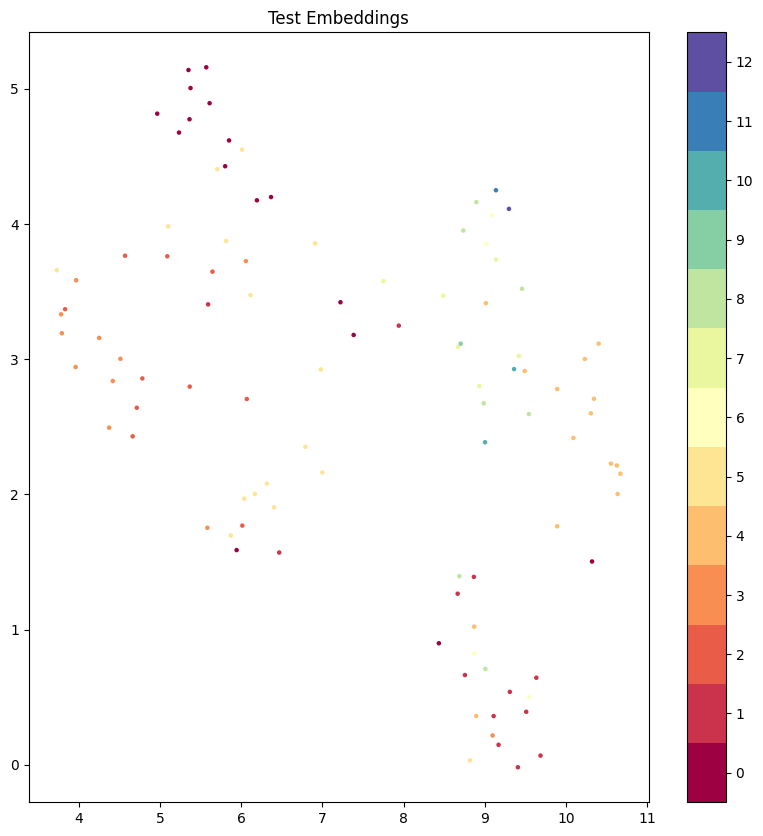

Epoch 85: Average Loss = 0.012274333275854588


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  6.39it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6138613861386139
Test set accuracy (r_precision) = 0.5498157242417661


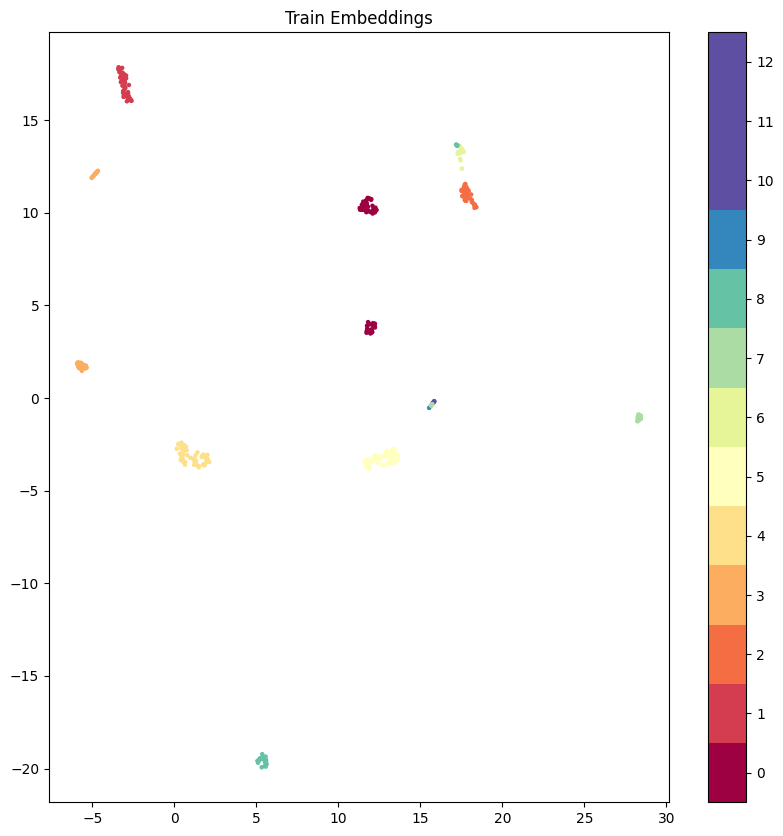

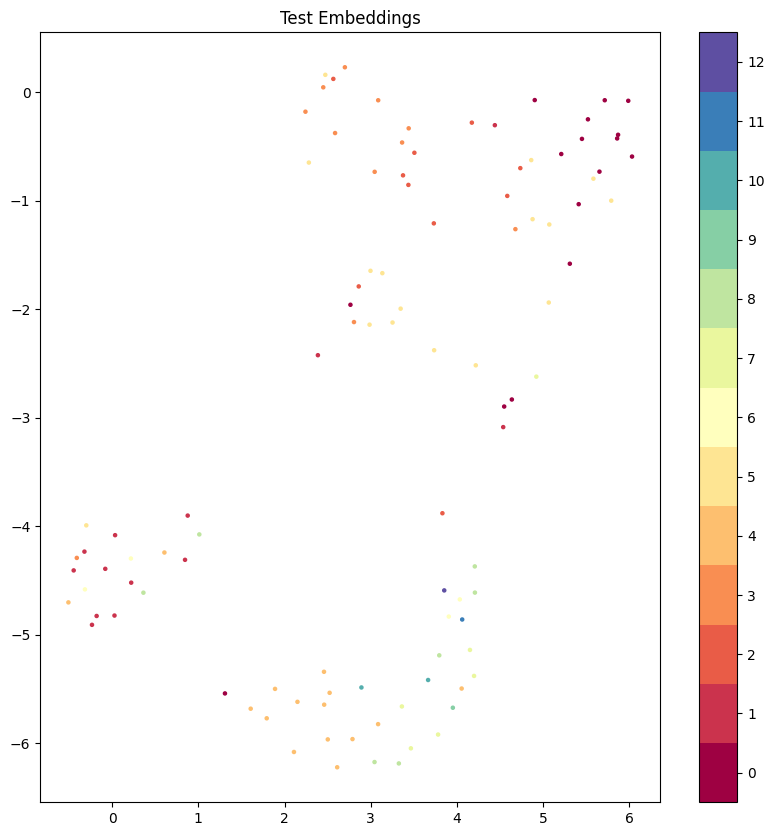

Epoch 86: Average Loss = 0.01687093824148178


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  6.19it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6237623762376238
Test set accuracy (r_precision) = 0.5516793670769563


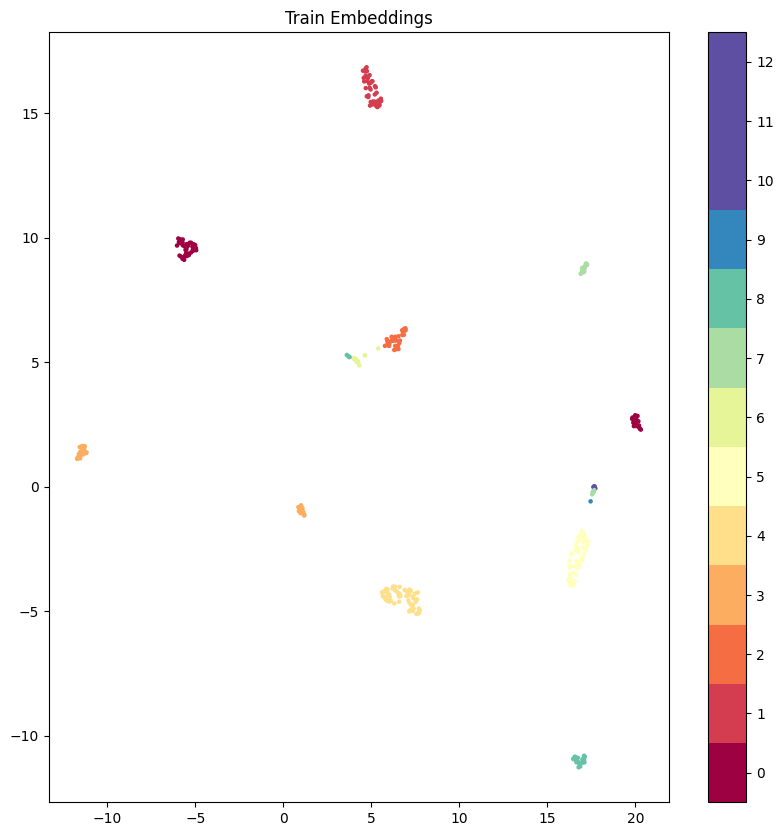

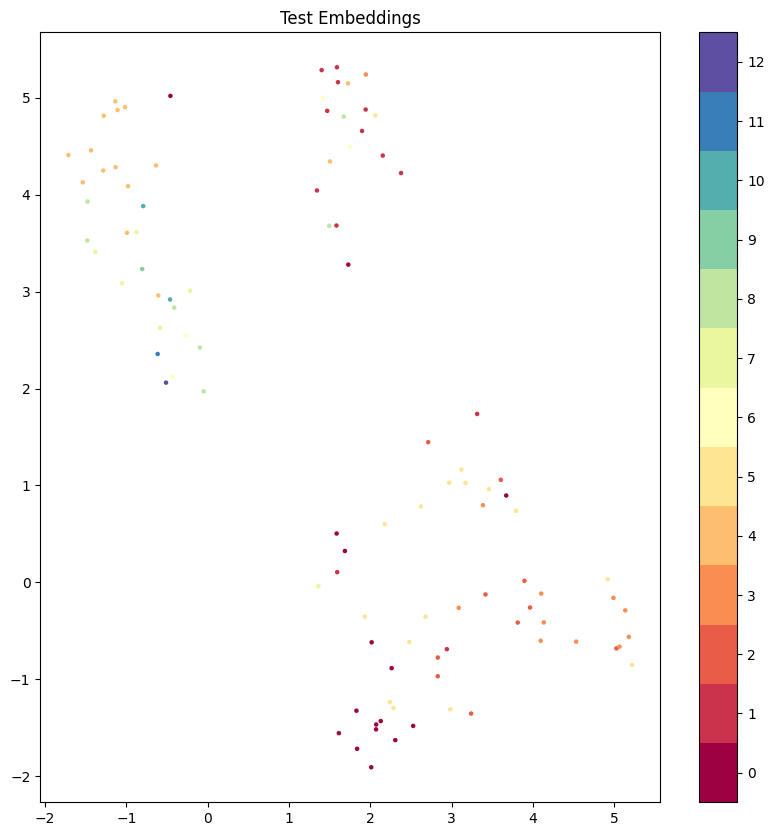

Epoch 87: Average Loss = 0.0028008446097373962


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 12/12 [00:02<00:00,  6.73it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6039603960396039
Test set accuracy (r_precision) = 0.5482916688545693


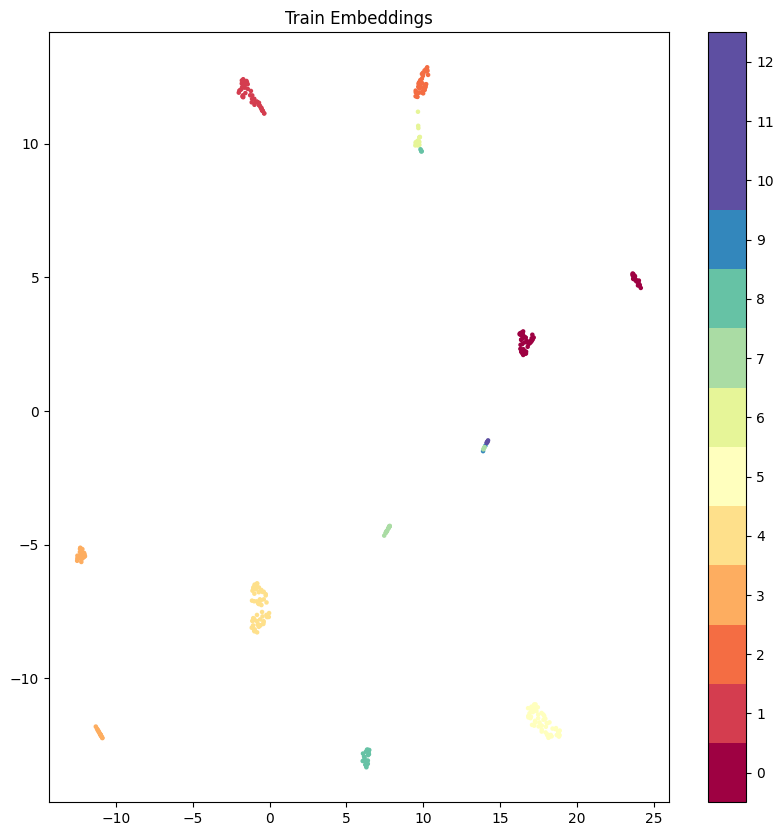

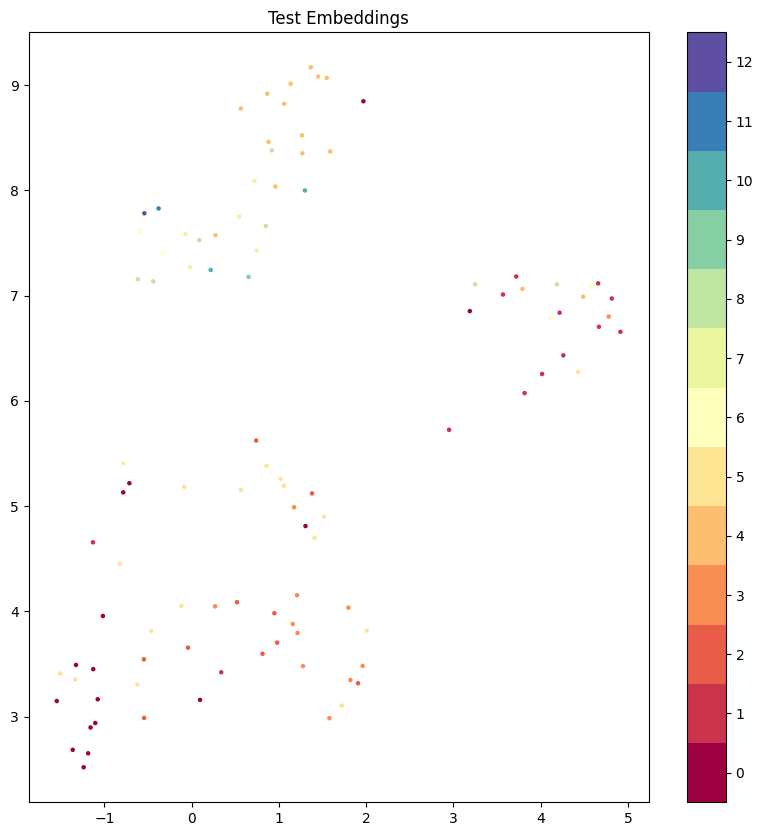

Epoch 88: Average Loss = 0.018590829335153103


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  6.26it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6039603960396039
Test set accuracy (r_precision) = 0.5530232090033804


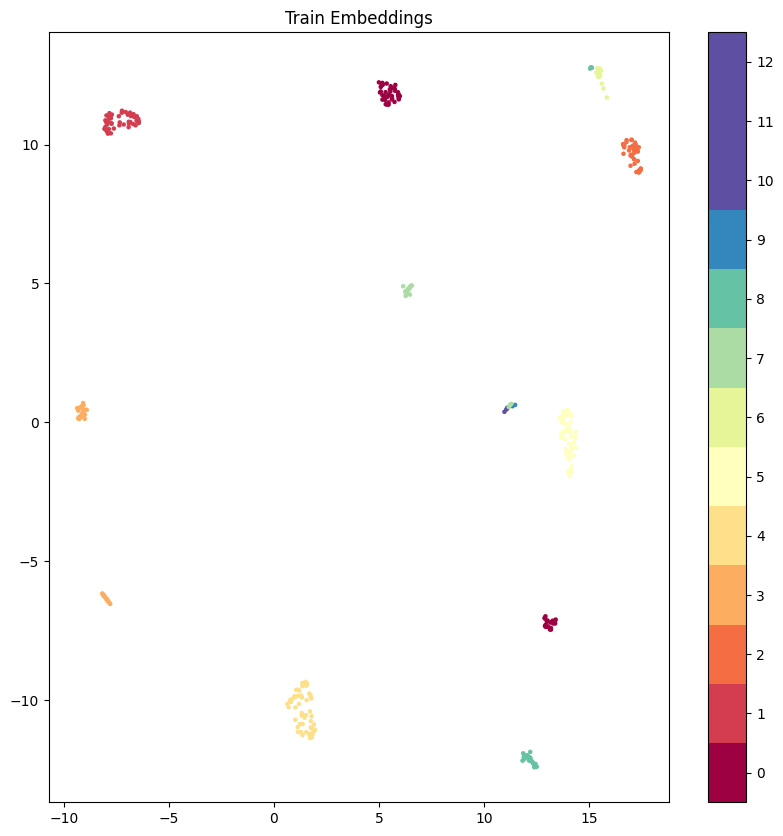

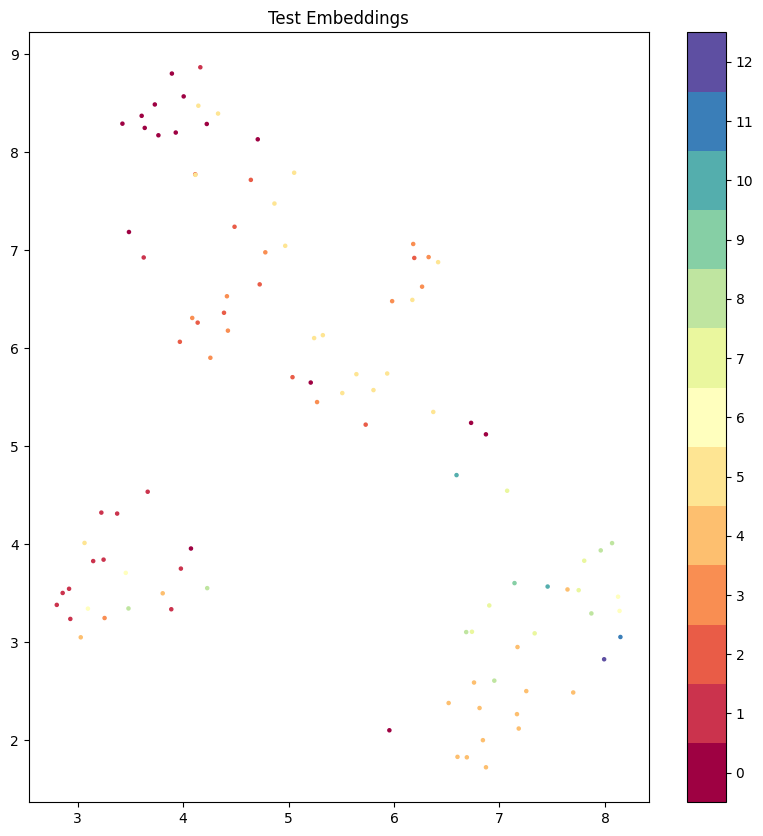

Epoch 89: Average Loss = 0.019119545817375183


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  5.66it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6138613861386139
Test set accuracy (r_precision) = 0.55620756840924


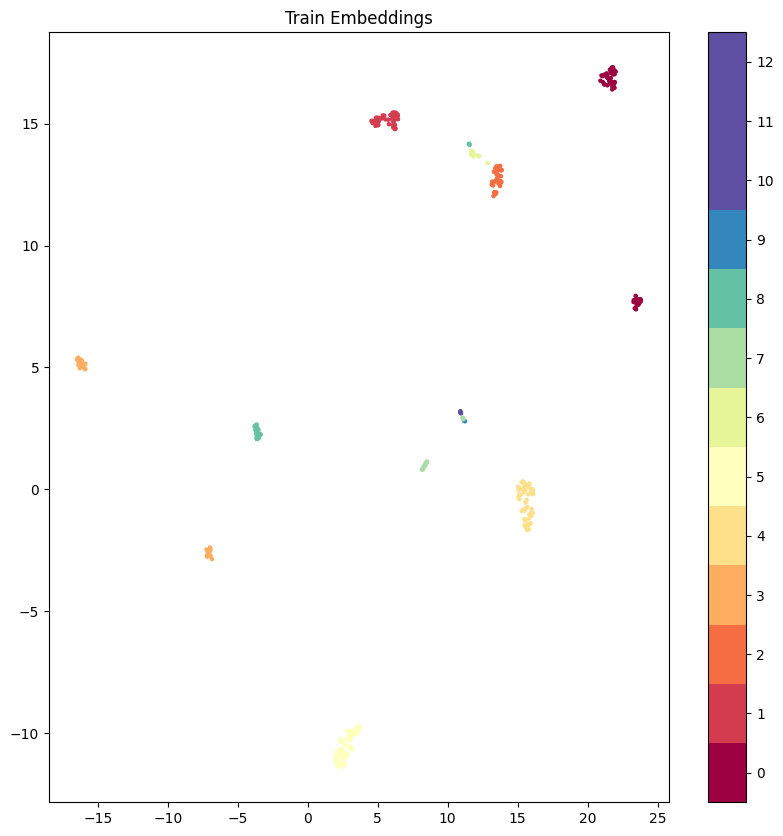

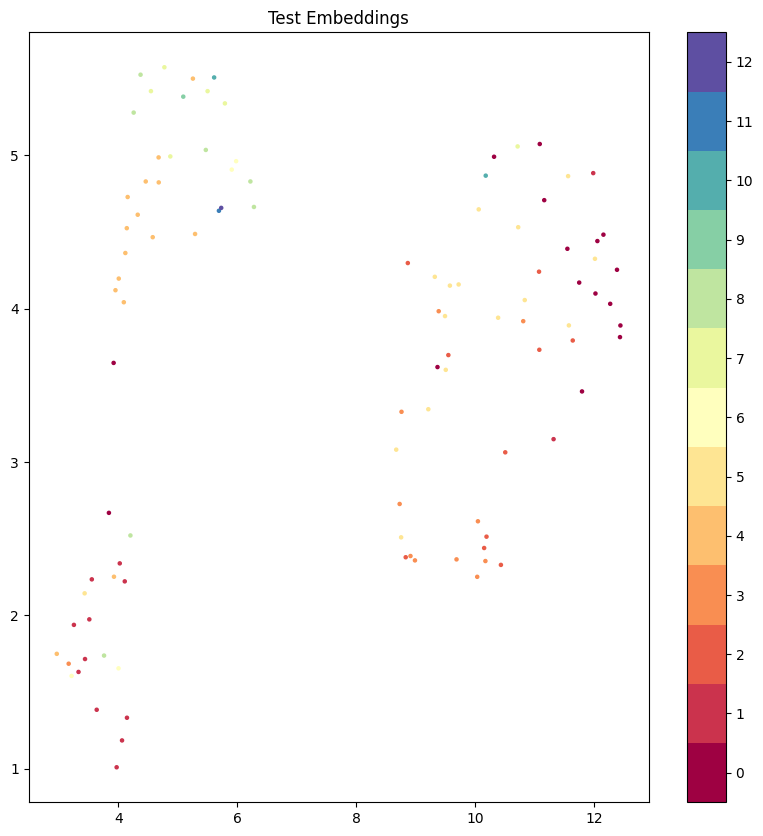

Epoch 90: Average Loss = 0.018686274997889996


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 12/12 [00:02<00:00,  7.06it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.594059405940594
Test set accuracy (r_precision) = 0.5480638038845419


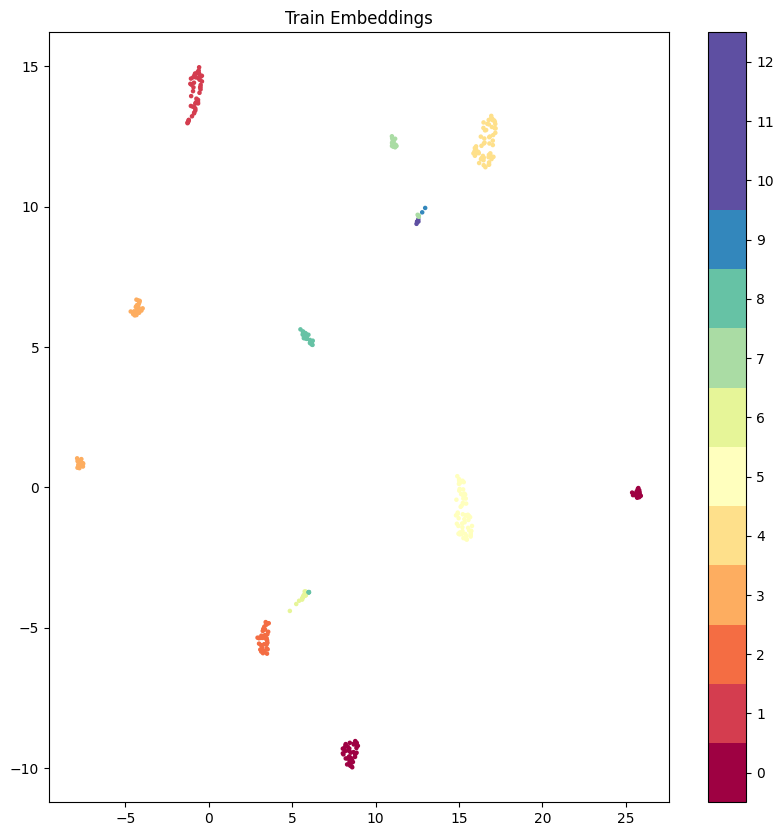

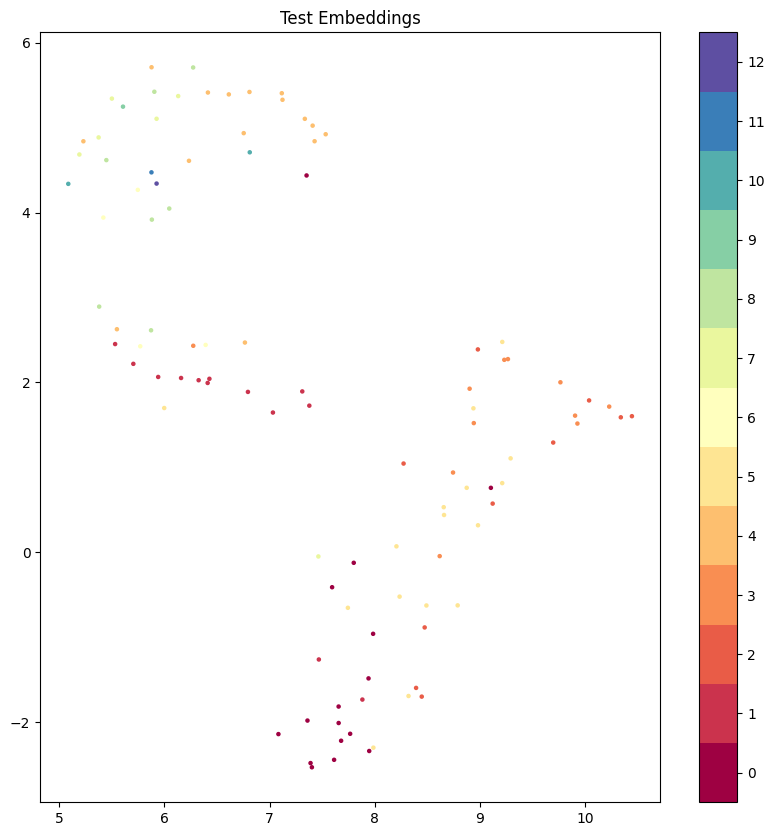

Epoch 91: Average Loss = 0.012848581187427044


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  5.31it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5742574257425742
Test set accuracy (r_precision) = 0.5291611038611554


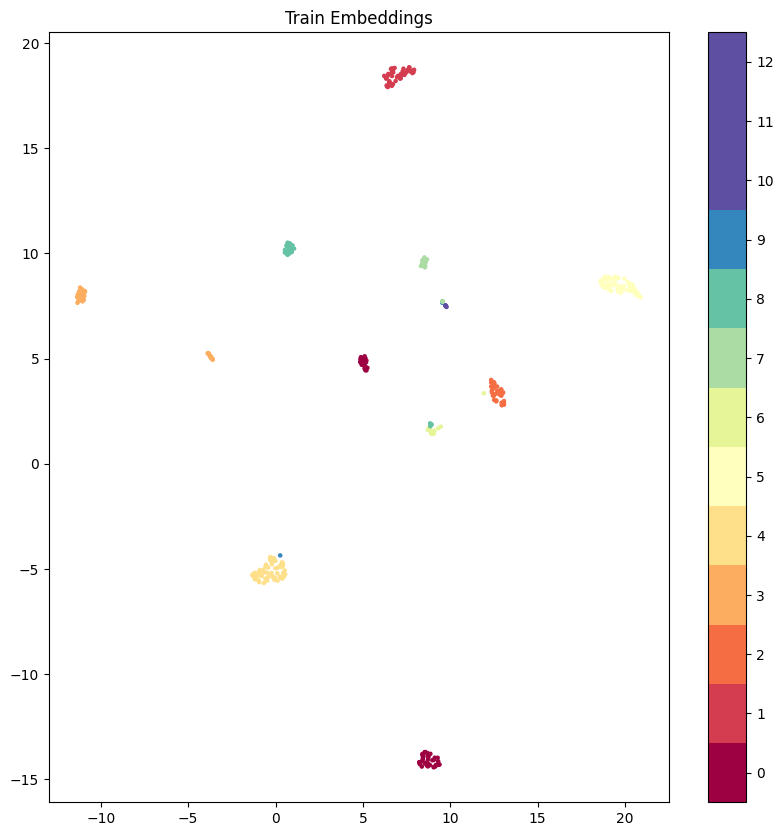

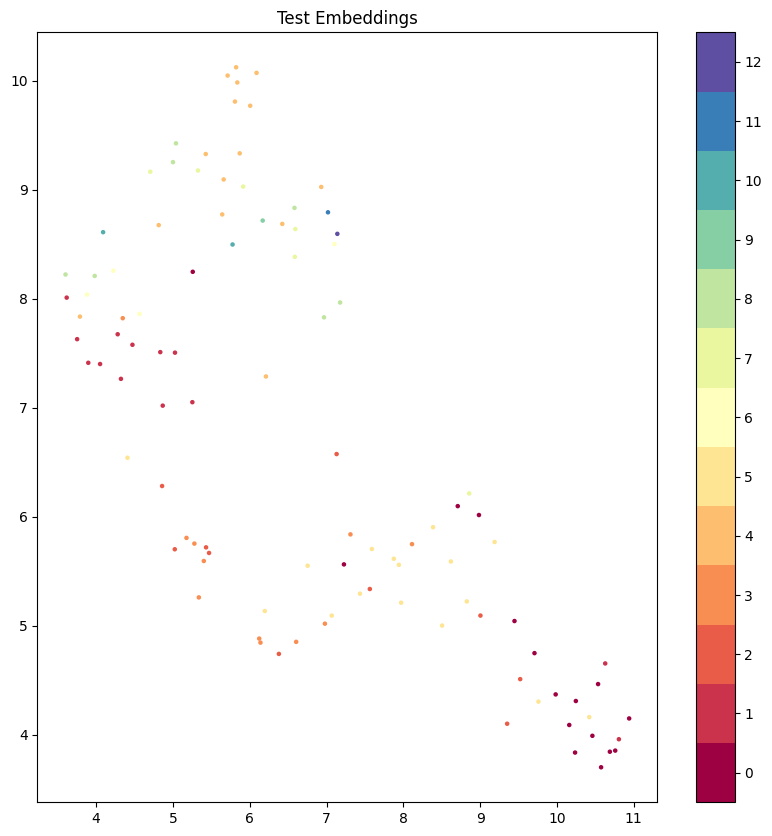

Epoch 92: Average Loss = 0.015340730547904968


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 12/12 [00:02<00:00,  6.22it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5643564356435644
Test set accuracy (r_precision) = 0.5170709287228559


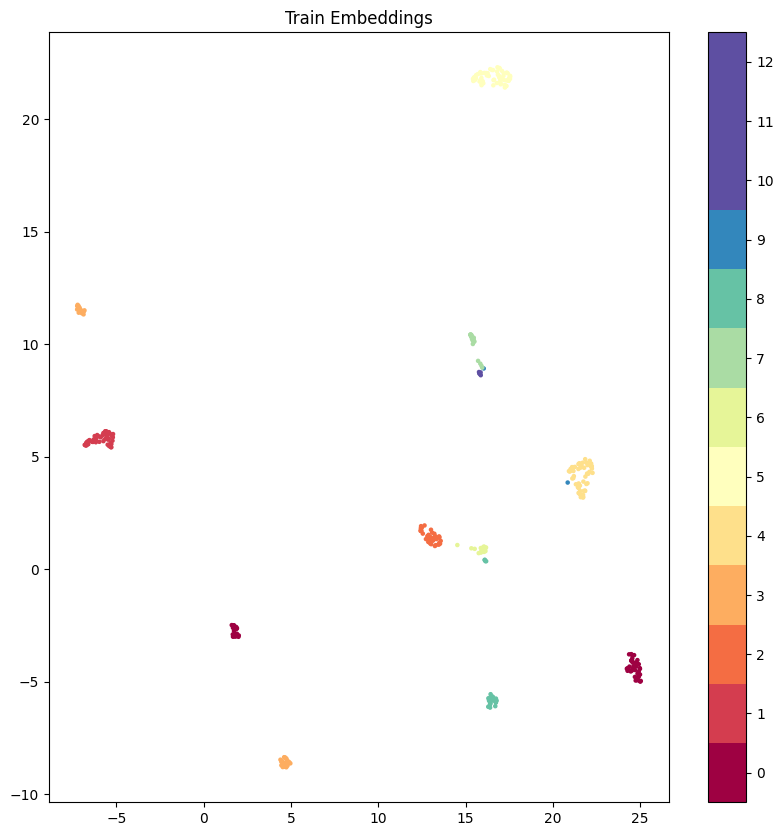

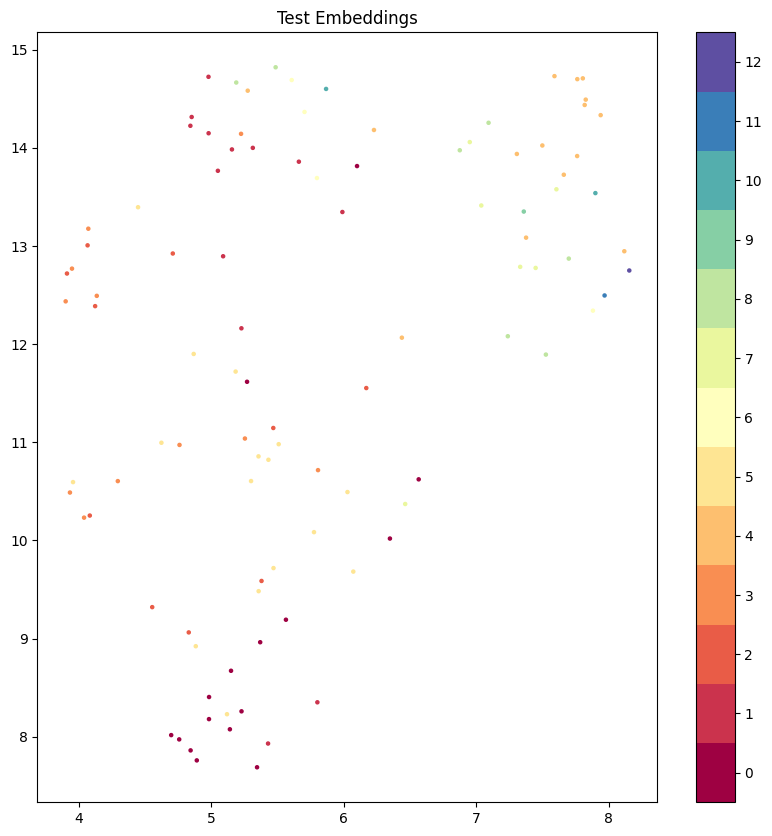

Epoch 93: Average Loss = 0.012567408382892609


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  5.48it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5742574257425742
Test set accuracy (r_precision) = 0.511413307184477


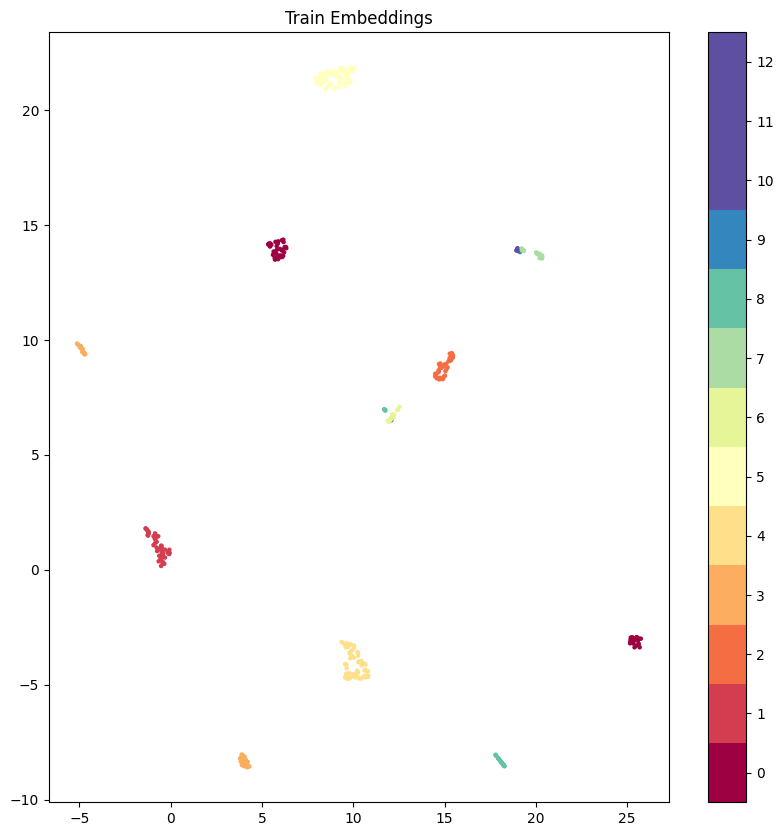

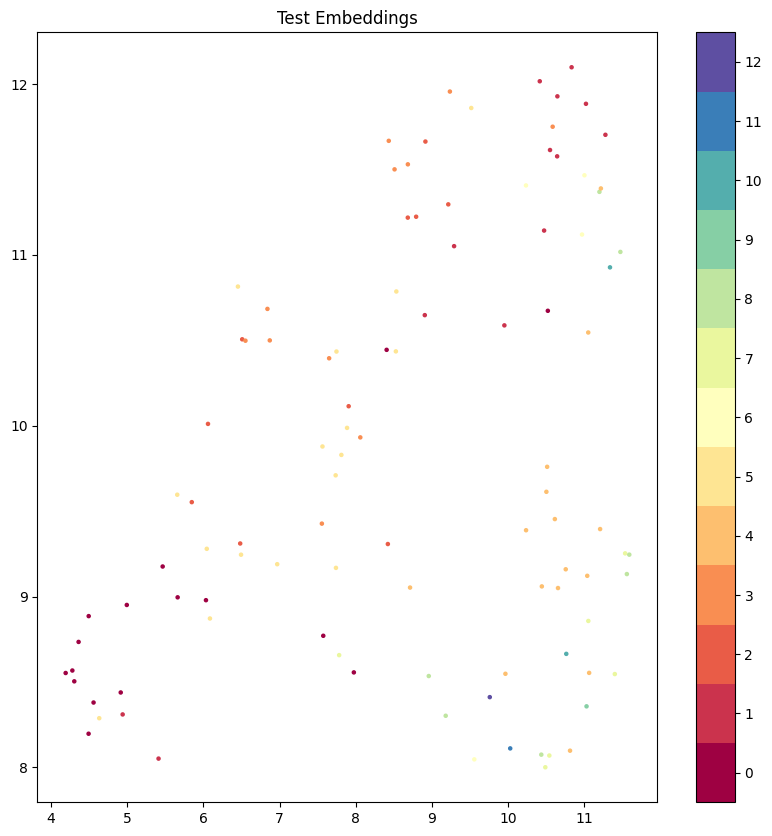

Epoch 94: Average Loss = 0.007423004601150751


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  5.75it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5643564356435644
Test set accuracy (r_precision) = 0.5113138821602151


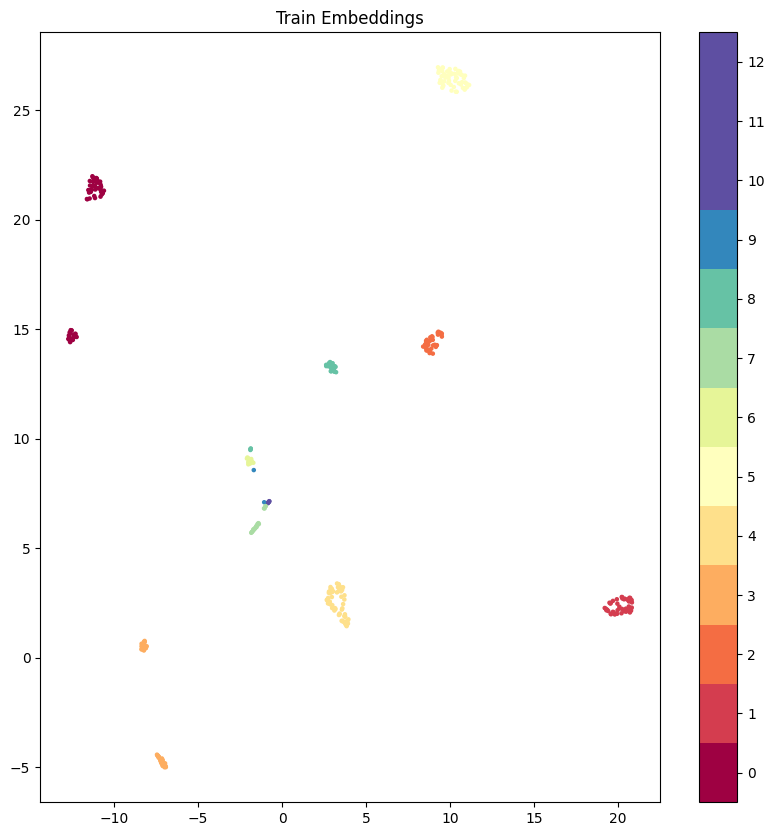

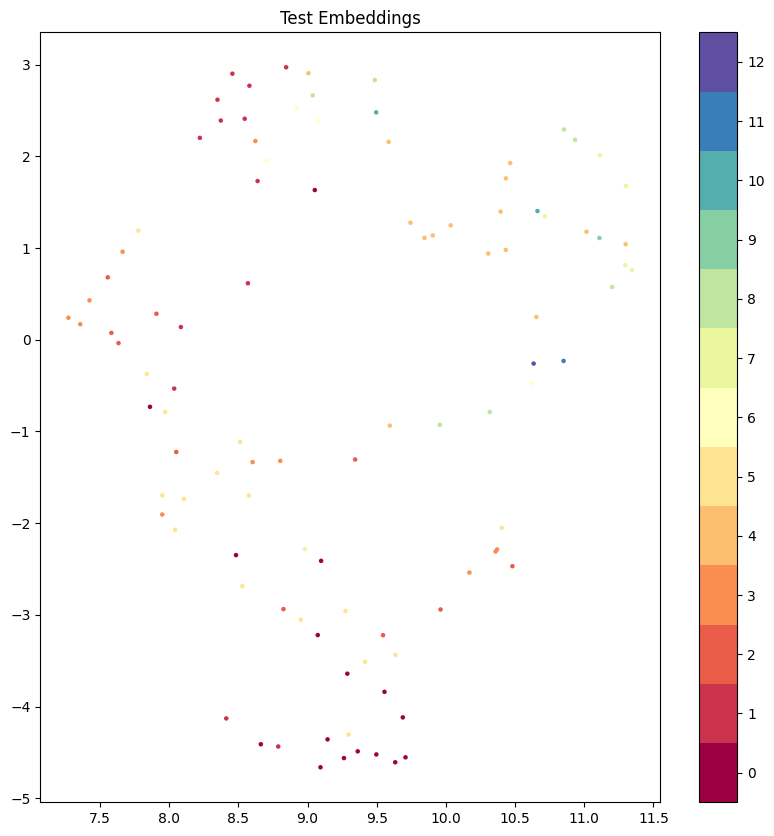

Epoch 95: Average Loss = 0.038841888308525085


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  6.16it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5841584158415841
Test set accuracy (r_precision) = 0.5185165930444345


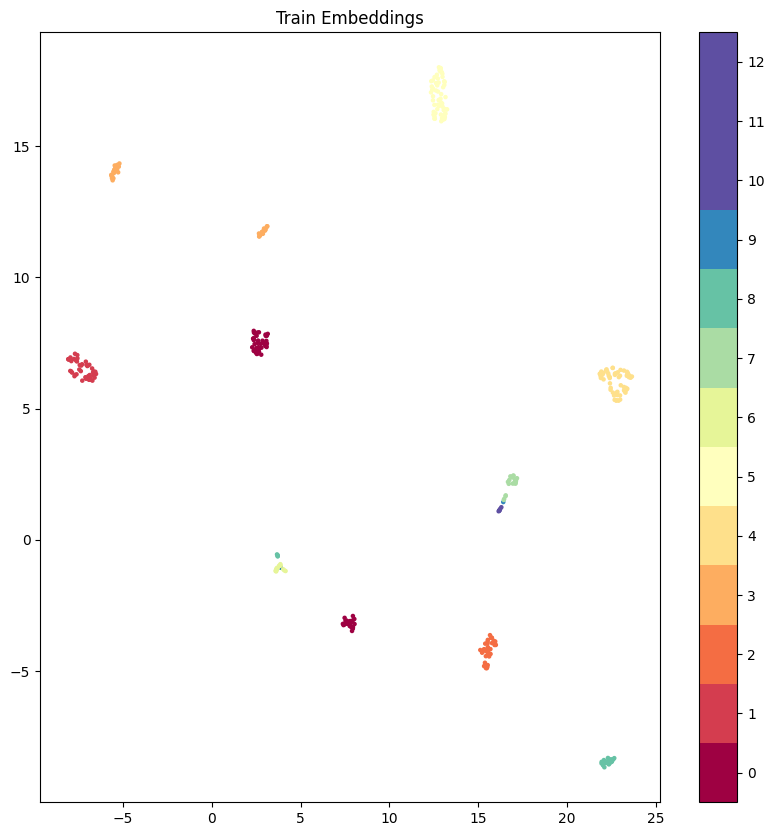

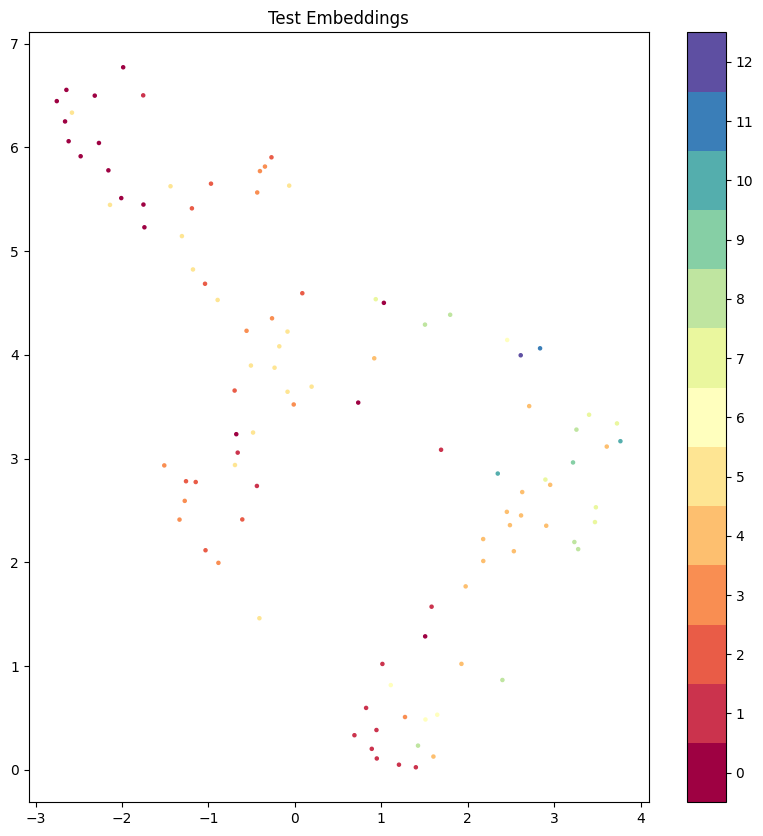

Epoch 96: Average Loss = 0.009980394504964352


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  5.67it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.594059405940594
Test set accuracy (r_precision) = 0.5214345597206744


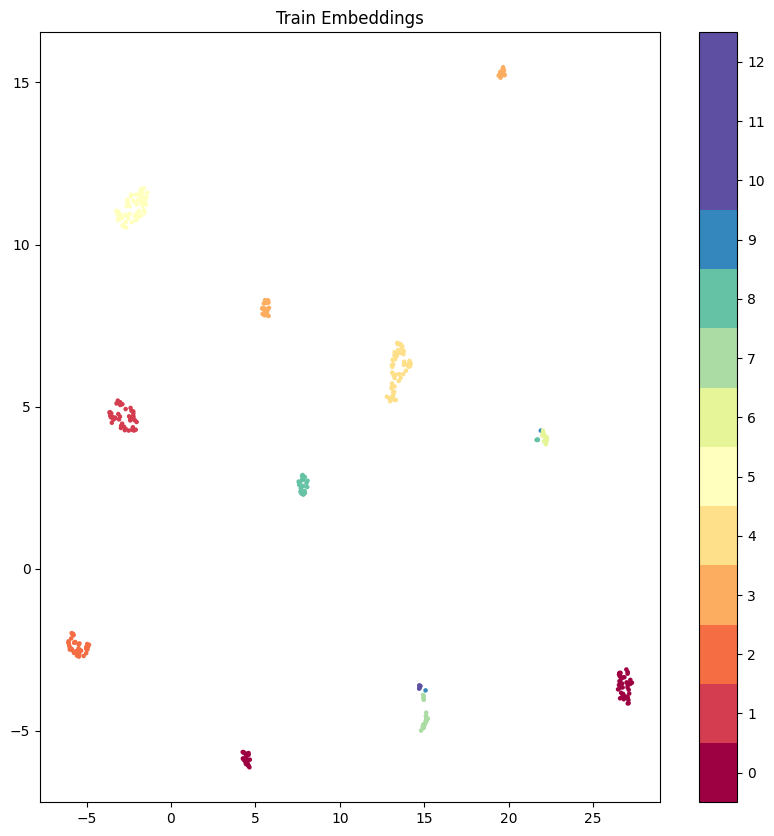

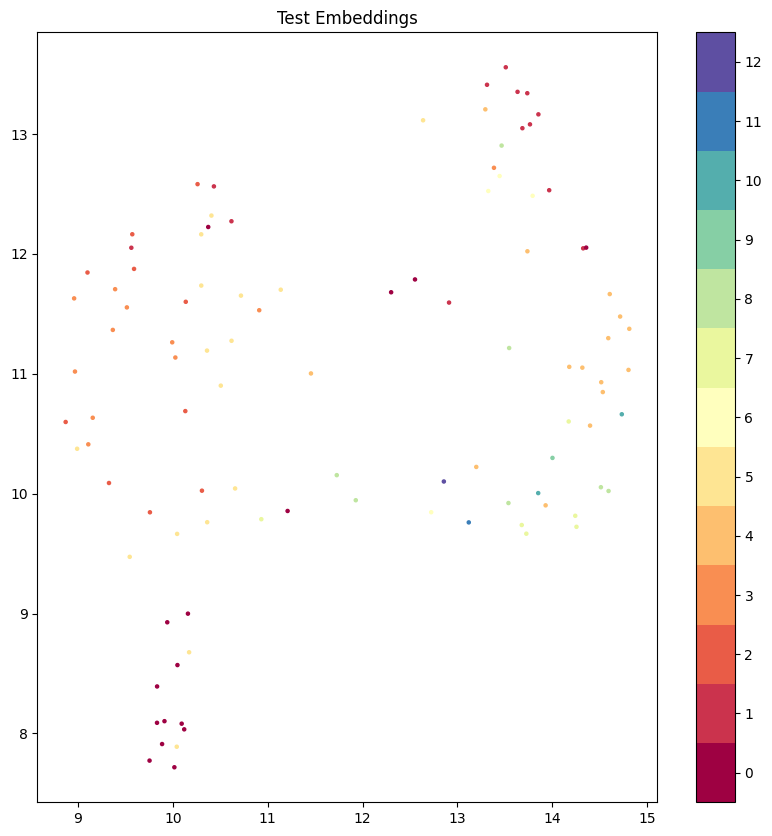

Epoch 97: Average Loss = 0.010656311176717281


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  5.41it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00,  4.00it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5841584158415841
Test set accuracy (r_precision) = 0.5381466228293075


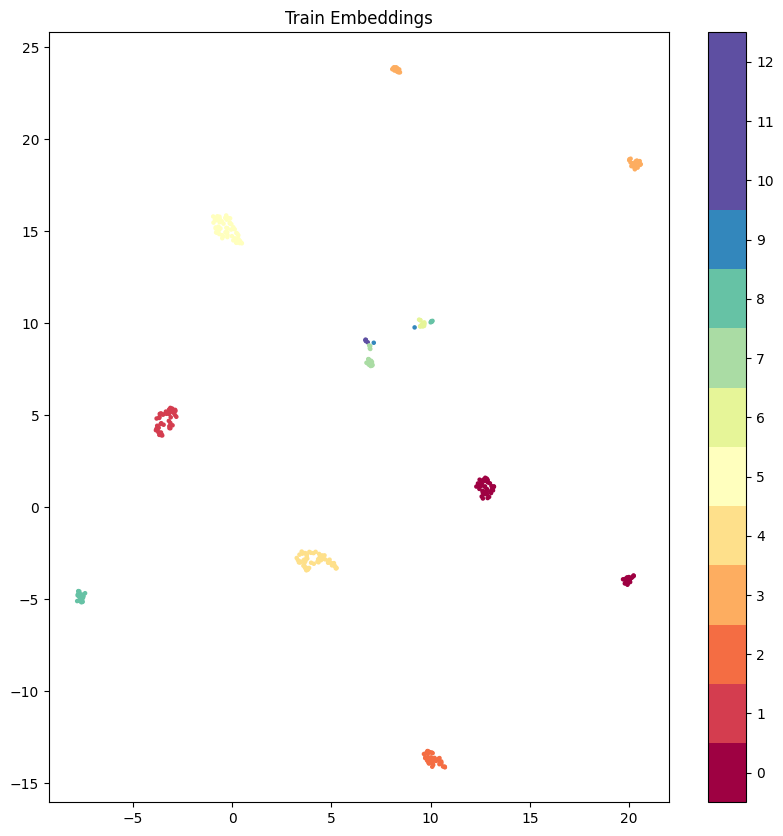

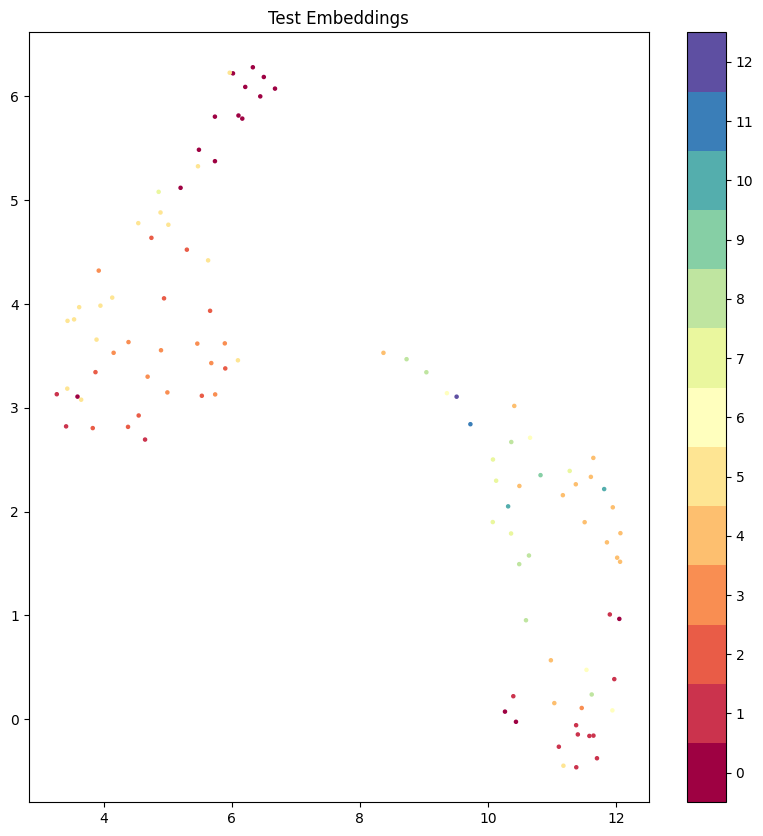

Epoch 98: Average Loss = 0.014438353478908539


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  5.89it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.75it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6039603960396039
Test set accuracy (r_precision) = 0.5432243236528904


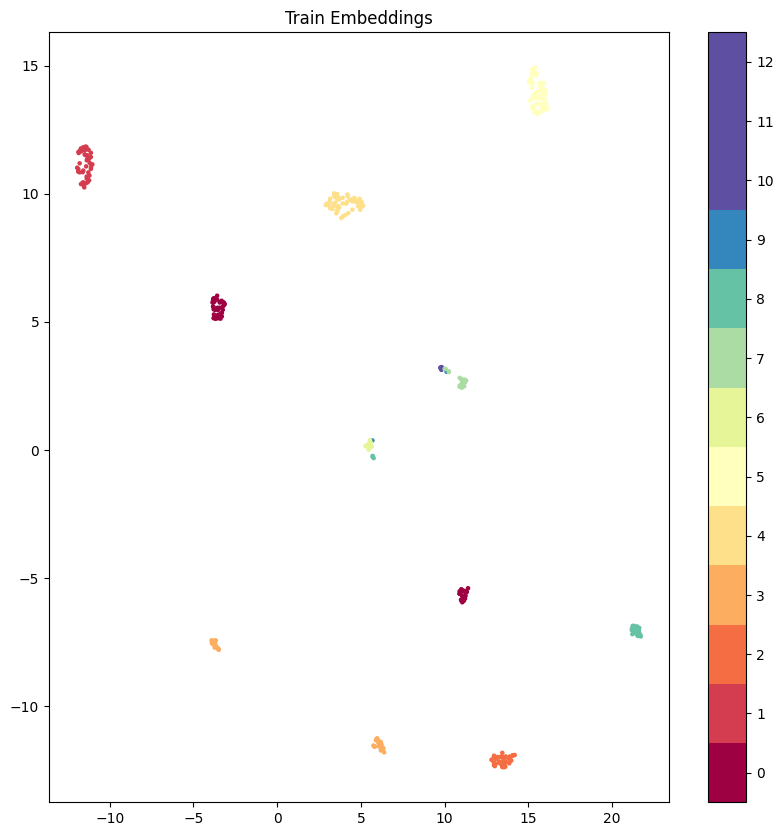

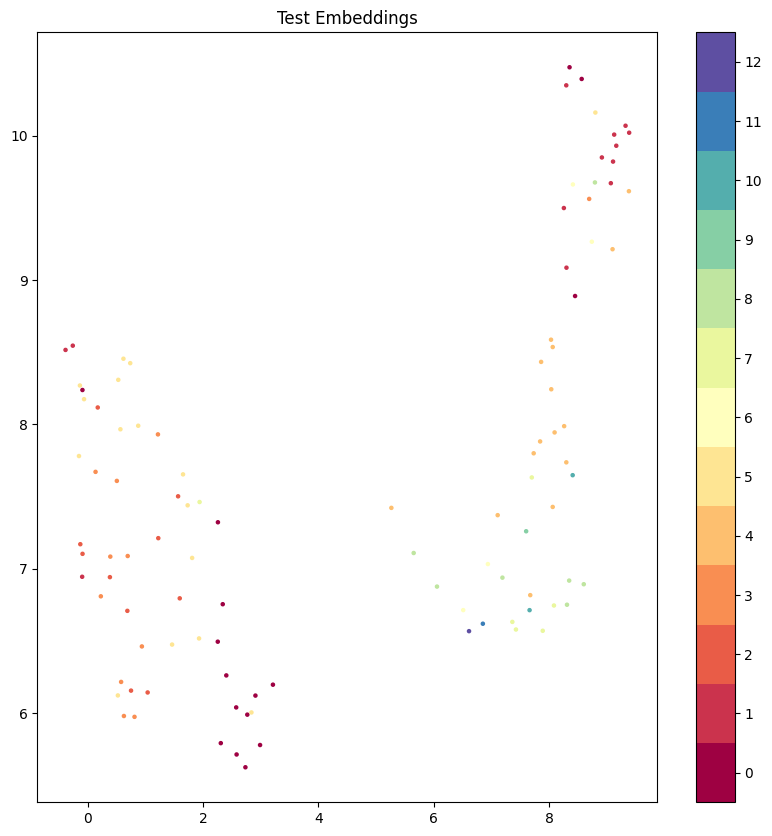

Epoch 99: Average Loss = 0.0006001368165016174


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 12/12 [00:02<00:00,  6.45it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6138613861386139
Test set accuracy (r_precision) = 0.5464632586477631


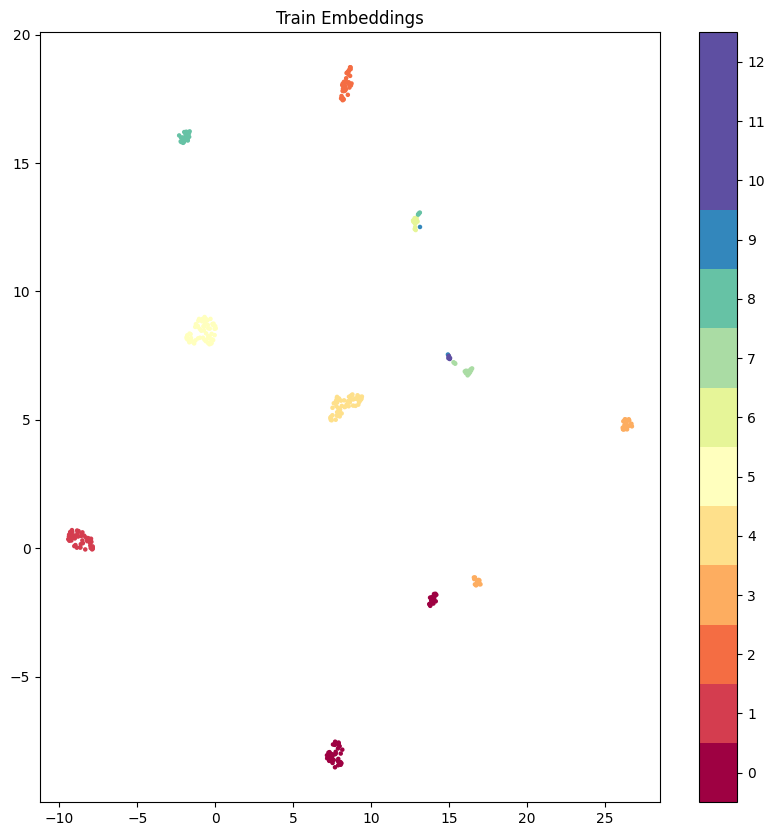

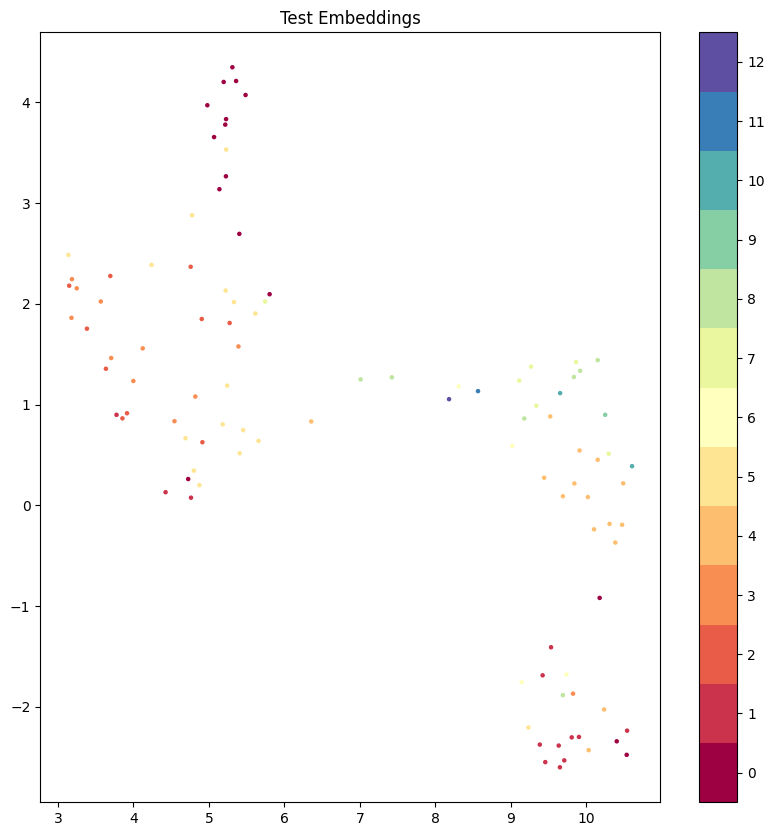

Epoch 100: Average Loss = 0.0


  0%|          | 0/12 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 11/12 [00:02<00:00,  5.70it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.594059405940594
Test set accuracy (r_precision) = 0.5469012988650617


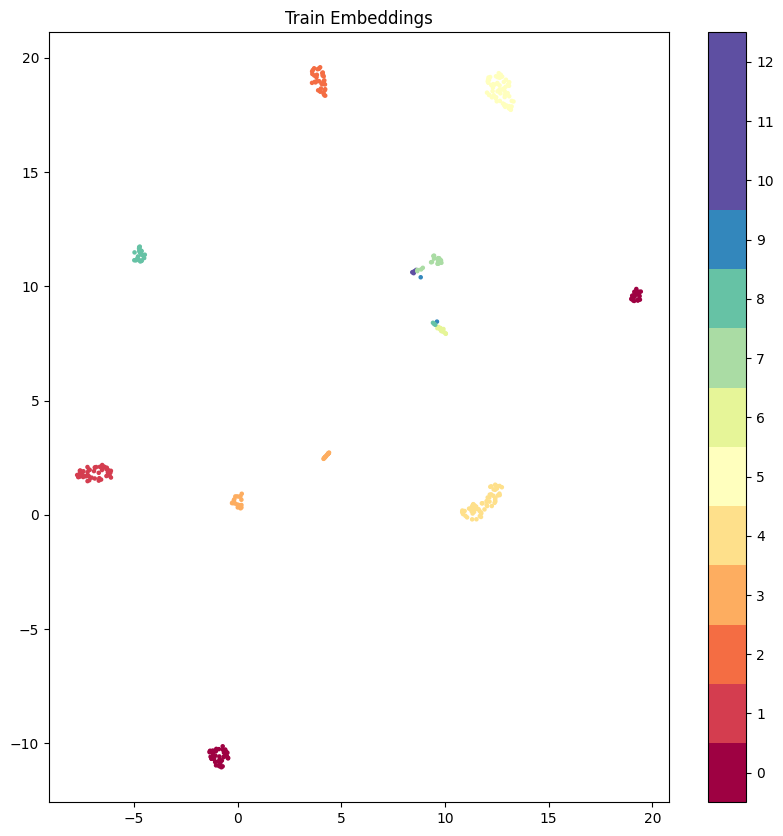

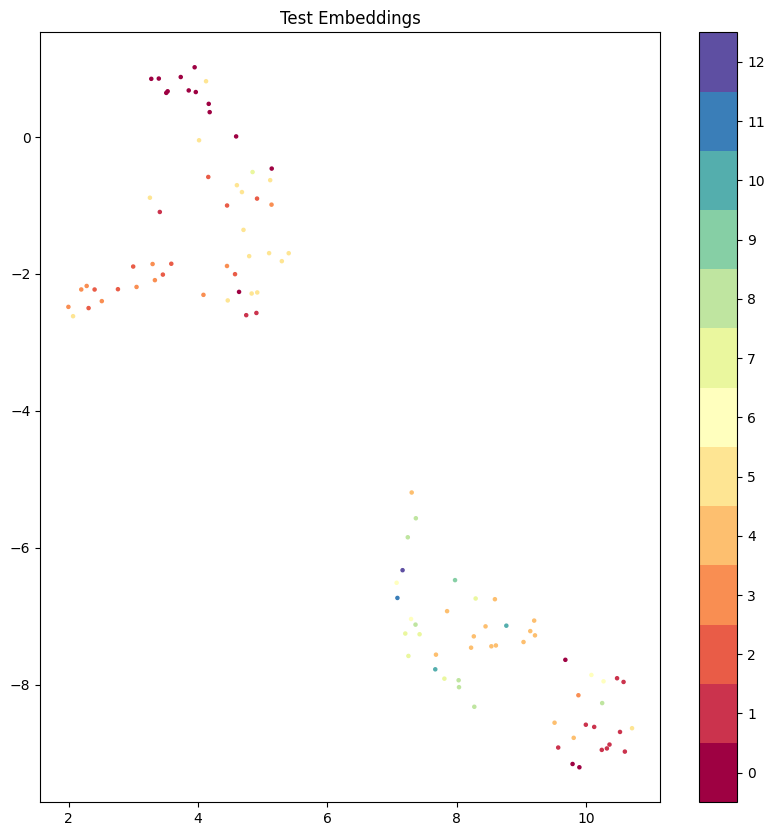

[0.2292463481426239, 0.14133034646511078, 0.1167726032435894, 0.0880940668284893, 0.06285841763019562, 0.05475268512964249, 0.10910275019705296, 0.047315094619989395, 0.022972382605075836, 0.025572442798875272, 0.03375292755663395, 0.03506624139845371, 0.014877233654260635, 0.03560774587094784, 0.027398088946938515, 0.057289544492959976, 0.013017025776207447, 0.0436696819961071, 0.05541749484837055, 0.010703569278120995, 0.014656759798526764, 0.021750968880951405, 0.03143032919615507, 0.009504744783043861, 0.01839674706570804, 0.029565878212451935, 0.032120734453201294, 0.028153796680271626, 0.014237442053854465, 0.04199907183647156, 0.03714750520884991, 0.021939152851700783, 0.0041136667132377625, 0.008326821029186249, 0.012351213954389095, 0.032779550179839134, 0.0053749410435557365, 0.03146641980856657, 0.023260733112692833, 0.031901974231004715, 0.013834266923367977, 0.016861104406416416, 0.011009765788912773, 0.013495586812496185, 0.003315150737762451, 0.018321121111512184, 0.0444

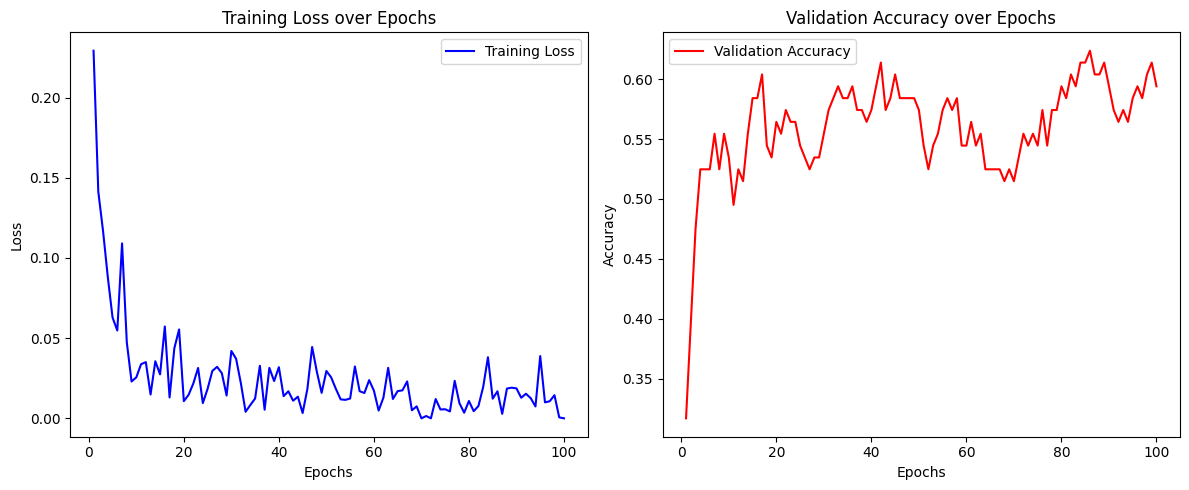

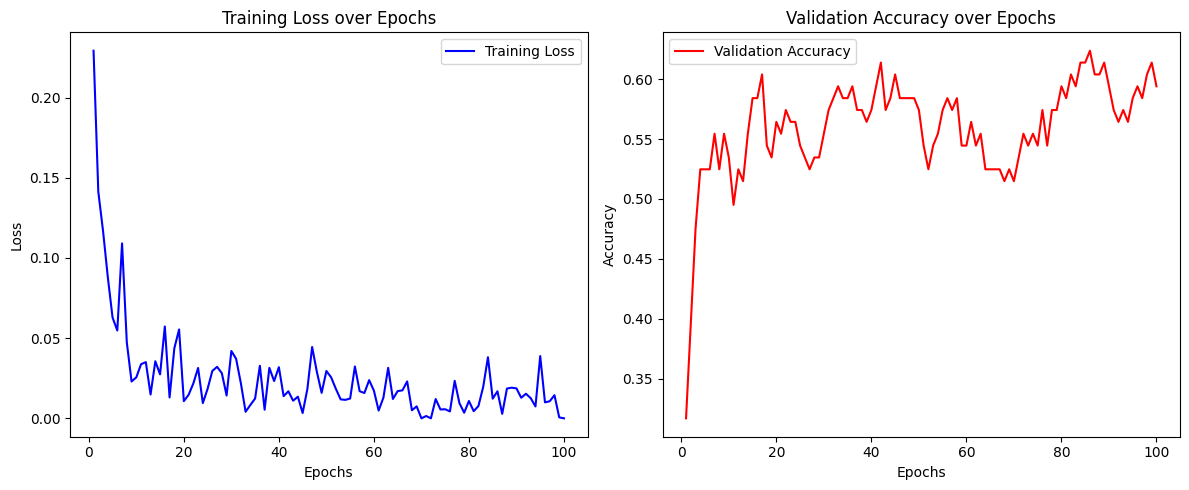

In [35]:
model = Net(NUM_CLASSES).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# Pytorch-metric-learning configurations
distance = CosineSimilarity()
reducer = ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)

mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="semi-hard" # probar all (20 epohs) easy mes i hard encara mes
)

losses_over_epochs = []
acc_over_epochs=[]
num_epochs = 100
# Training and testing
for epoch in range(1, num_epochs + 1):
    epoch_loss = train(model, loss_func, mining_func, device, train_loader, optimizer, epoch)
    losses_over_epochs.append(epoch_loss)
    acc = test(train_dataset, test_dataset, model, accuracy_calculator)
    acc_over_epochs.append(acc)

print(losses_over_epochs)
print(acc_over_epochs)
plot_metrics(losses_over_epochs, acc_over_epochs)
plot_metrics(losses_over_epochs,acc_over_epochs)

In [ ]:
weights = model.resnet.fc.weight

# Suponiendo que las clases se derivan de las filas de los pesos
unique_classes = set(weights.argmax(dim=1).tolist())

# Imprimir las clases únicas
print("Clases únicas en el modelo:", len(unique_classes))
for class_index in unique_classes:
    print(class_index)

Clases únicas en el modelo: 12
1187
291
1979
1091
1051
526
1653
1847
857
1050
507
1182


# Evaluate for one artist

In [ ]:
import os
import glob

train_folder = os.path.join(folder, "TEST")
all_files = glob.glob(os.path.join(train_folder, "*"))

ll_imatges = []

for i in all_files:
  ll_imatges.append(i.split("/")[-1])

df_filtered = df[df['new_filename'].isin(ll_imatges)]

ll_artistes = list(set(df_filtered['artist'].tolist()))

print("Artistes:",ll_artistes)

Artistes: ['Vincent van Gogh']


In [ ]:
artist_counts = df_filtered.groupby('artist').size().reset_index(name='count')
artist_counts_sorted = artist_counts.sort_values(by='count', ascending=False)
artist_counts_sorted

artist  count
0  Vincent van Gogh    103

In [ ]:
df_artist = df_filtered[df_filtered['artist'] == 'Vincent van Gogh']
df_artist_filtered = df_artist[['new_filename', 'date']]
df_artist_filtered

new_filename  date
12     62470.jpg  1884
19     57934.jpg  1888
21     87410.jpg  1888
24      5202.jpg  1887
27     21498.jpg  1887
..           ...   ...
472    21375.jpg  1887
475    37286.jpg  1885
477    84569.jpg  1889
478    56264.jpg  1887
482    10078.jpg  1882

[103 rows x 2 columns]

In [ ]:
artists_images = df_artist['new_filename'].tolist()
artists_images

['62470.jpg',
 '57934.jpg',
 '87410.jpg',
 '5202.jpg',
 '21498.jpg',
 '41943.jpg',
 '36628.jpg',
 '47589.jpg',
 '78696.jpg',
 '34660.jpg',
 '32044.jpg',
 '56913.jpg',
 '75795.jpg',
 '36995.jpg',
 '89721.jpg',
 '76519.jpg',
 '41419.jpg',
 '61079.jpg',
 '18162.jpg',
 '38455.jpg',
 '41579.jpg',
 '2168.jpg',
 '87736.jpg',
 '28695.jpg',
 '35084.jpg',
 '103128.jpg',
 '23738.jpg',
 '93244.jpg',
 '61301.jpg',
 '5980.jpg',
 '72858.jpg',
 '59150.jpg',
 '27087.jpg',
 '8045.jpg',
 '31455.jpg',
 '55860.jpg',
 '73016.jpg',
 '32352.jpg',
 '32472.jpg',
 '76154.jpg',
 '14576.jpg',
 '53507.jpg',
 '23601.jpg',
 '99432.jpg',
 '59231.jpg',
 '14997.jpg',
 '46192.jpg',
 '51624.jpg',
 '69137.jpg',
 '5867.jpg',
 '74245.jpg',
 '60960.jpg',
 '28104.jpg',
 '85589.jpg',
 '17702.jpg',
 '50373.jpg',
 '61023.jpg',
 '70505.jpg',
 '90289.jpg',
 '61383.jpg',
 '60546.jpg',
 '43885.jpg',
 '82771.jpg',
 '64102.jpg',
 '53714.jpg',
 '28203.jpg',
 '29736.jpg',
 '12594.jpg',
 '63936.jpg',
 '99645.jpg',
 '45581.jpg',
 '83938.jp

In [ ]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms


# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ajusta el tamaño de la imagen según la entrada del modelo
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4902860351171657, 0.4327027123349515, 0.3679902021355657],
                         std=[0.22134062718873712, 0.20430693703606892, 0.18851782142531143])
])

# Función para predecir la clase de una imagen
def predict_class(image_path, model, transform, device):
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)  # Añade una dimensión adicional para el batch
    image = image.to(device)

    with torch.no_grad():
        model.eval()
        output = model(image)

    probabilities = torch.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities).item()

    return predicted_class

i = 0
ll_predicted = []
ll_real = []
# Iterar sobre todas las imágenes en la carpeta de prueba
for filename in artists_images:
      image_path = os.path.join(folder+"/TEST", filename)
      predicted_class = predict_class(image_path, model, transform, device)

      # Obtener la clase real
      real_class = test_dataframe[test_dataframe['new_filename'] == filename]['date'].tolist()[0]

      predicted = idx2date[predicted_class]
      real = idx2date[real_class]
      if predicted == real:
          i += 1

      ll_predicted.append(predicted)
      ll_real.append(real)
      print(f"Imagen: {filename}")
      print(f"Clase predicha: {predicted}")
      print(f"Clase real: {real}")
      print("-------------------------")



Imagen: 62470.jpg
Clase predicha: 1873
Clase real: 1884
-------------------------
Imagen: 57934.jpg
Clase predicha: 1882
Clase real: 1888
-------------------------
Imagen: 87410.jpg
Clase predicha: 1889
Clase real: 1888
-------------------------
Imagen: 5202.jpg
Clase predicha: 1885
Clase real: 1887
-------------------------
Imagen: 21498.jpg
Clase predicha: 1889
Clase real: 1887
-------------------------
Imagen: 41943.jpg
Clase predicha: 1883
Clase real: 1887
-------------------------
Imagen: 36628.jpg
Clase predicha: 1878
Clase real: 1885
-------------------------
Imagen: 47589.jpg
Clase predicha: 1883
Clase real: 1888
-------------------------
Imagen: 78696.jpg
Clase predicha: 1890
Clase real: 1885
-------------------------
Imagen: 34660.jpg
Clase predicha: 1885
Clase real: 1889
-------------------------
Imagen: 32044.jpg
Clase predicha: 1873
Clase real: 1890
-------------------------
Imagen: 56913.jpg
Clase predicha: 1879
Clase real: 1887
-------------------------
Imagen: 75795.jpg

In [ ]:
import numpy as np

def calculate_mae(ll_predicted, ll_real):
    # Asegurarse de que las listas tengan la misma longitud
    assert len(ll_predicted) == len(ll_real), "Las listas deben tener la misma longitud"

    # Convertir listas a numpy arrays para facilitar el cálculo
    ll_predicted = np.array(ll_predicted)
    ll_real = np.array(ll_real)

    # Calcular el MAE
    mae = np.mean(np.abs(ll_predicted - ll_real))

    return mae


print("Total acertades:",str(i)+"/"+str(len(artists_images)))
print("Percetnatge acertat:",str((i * 100)/len(artists_images))+"%")
mae = calculate_mae(ll_predicted, ll_real)
print(f"MAE: {mae}")


Total acertades: 6/103
Percetnatge acertat: 5.825242718446602%
MAE: 4.495145631067961
